In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from Evaluate import Evaluate

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('ranf',_type='class')
le = LabelEncoder()

In [3]:
X,Y = model.preprocessing.load_data('../Agg_data_from_frame_163.xlsx',labels=False,sheet_name="Sheet1")
Y= model.preprocessing.load_Y('./classification_targets.xlsx',video_name=False,column_name="diff")

In [4]:
Y['Video Name'] = Y.index.values

In [5]:
X = X.set_index(X['Video Name'])
X = X.drop('Unnamed: 0',1)
Y = Y.set_index(Y['Video Name'])

Y = Y[Y['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y = Y[Y['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
X = X[X['Campaign']=='Surface']
Y = Y.drop('Video Name',1)
Y = Y.loc[X.index.values,:]
# Y = Y.iloc[:,11:]

In [6]:
Y.dropna(how='all')
X = X[X.index != 'Song for Surface NFL Fans - Surface SP4 30 TV US']
X,Y= model.preprocessing.clean_data(X,Y)

In [7]:
# surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
# for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
#     cols = [col+suf for col in surface_pro_frames[:10]]
#     X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
# X = X.drop(surface_pro_frames,axis=1)

In [8]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')

In [9]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'Age: 0-15_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Female_frame_count',
 'Male_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell_sub_brand_group',
 'HP_group',
 'Lenovo_group',
 'Macbook_group',
 'Surface_group',
 'Windows',
 'Yoga',
 'Asus_text',
 'Currys PCs world_text',
 'Dell_text',
 'Hp_text',
 'Lenovo_text',
 'Apple',
 'Asus',
 'Dell',
 'Hp',
 'Microsoft_text',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [10]:
# new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-15_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-15_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
# age_cols = ['Age: 0-15_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
# ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
# gender_cols = ["Female_dur","Male_dur"]
# emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# X = model.preprocessing.addNewFeature(X,new_features,_type='per')
# X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [11]:
X.columns.values

array(['Video Name', 'African_dur', 'Caucasian_dur', 'Eastasian_dur',
       'Latino_dur', 'Angry_dur', 'Disgust_dur', 'Fear_dur',
       'Happiness_dur', 'Neutral_dur', 'Sadness_dur', 'Surprise_dur',
       'length_of_ad_15', 'Female_dur', 'Male_dur', 'Age: 0-15_dur',
       'Age: 15-24_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
       'Age: 45-60_dur', 'microsoft_dur', 'microsoft_first_ocr',
       'microsoft_last_ocr', 'microsoft_total_ocr', 'Intel', 'Intel_dur',
       'Intel_first_ocr', 'Intel_last_ocr', 'Intel_total_ocr',
       'ASUS T102_dur', 'Dell_sub_brand_group_dur', 'HP_group_dur',
       'Lenovo_group_dur', 'Macbook_group_dur', 'Surface_group_dur',
       'Windows_dur', 'Yoga_dur', 'ASUS T102_first_ocr',
       'ASUS T102_last_ocr', 'ASUS T102_total_ocr',
       'Dell_sub_brand_group_first_ocr', 'Dell_sub_brand_group_last_ocr',
       'Dell_sub_brand_group_total_ocr', 'HP_group_first_ocr',
       'HP_group_last_ocr', 'HP_group_total_ocr',
       'Lenovo_group_first_ocr', '

In [12]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

African_dur         79.365079
Age: 35-44_dur      74.603175
Sadness_dur         61.904762
Tablet_last_ocr     46.031746
Tablet_total_ocr    46.031746
dtype: float64

In [13]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [14]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [15]:
a=['Video Name', 'African_dur', 'Caucasian_dur', 'Eastasian_dur',
       'Happiness_dur', 'Neutral_dur', 'Sadness_dur', 'length_of_ad_15',
       'Female_dur', 'Male_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
       'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
       'microsoft_total_ocr', 'ASUS T102_dur', 'Dell_sub_brand_group_dur',
       'HP_group_dur', 'Lenovo_group_dur', 'Macbook_group_dur',
       'Surface_group_dur', 'Windows_dur', 'Yoga_dur',
       'Surface_group_first_ocr', 'Surface_group_last_ocr',
       'Surface_group_total_ocr', 'Laptop_dur', 'Laptop_first_ocr',
       'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur', 'Tablet_first_ocr',
       'Tablet_last_ocr', 'Tablet_total_ocr']

b=['Video Name', 'African_dur', 'Caucasian_dur', 'Eastasian_dur',
        'Happiness_dur', 'Neutral_dur', 'Sadness_dur', 'length_of_ad_15',
        'Female_dur', 'Male_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
        'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
        'microsoft_total_ocr', 'ASUS T102_dur', 'Dell_sub_brand_group_dur',
        'HP_group_dur', 'Lenovo_group_dur', 'Macbook_group_dur',
        'Surface_group_dur', 'Windows_dur', 'Yoga_dur',
        'Surface_group_first_ocr', 'Surface_group_last_ocr',
        'Surface_group_total_ocr', 'Laptop_dur', 'Laptop_first_ocr',
        'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur',
        'Tablet_first_ocr', 'Tablet_last_ocr', 'Tablet_total_ocr',
        'Surface_dur', 'Surface_first_ocr', 'Surface_last_ocr',
        'Surface_total_ocr']

In [16]:
# Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                    0
Brand_Cues__Mean                    0
Aided_Branding__Mean                0
Active_Involvement__Mean            0
New_Information__Mean               0
Enjoyment__Mean                     0
Brand_Appeal__Mean                  0
Understanding__Mean                 0
Relevance_of_Information__Mean      0
Credibility_of_Information__Mean    0
Brand_Difference__Mean              0
dtype: int64

In [17]:
Y.columns = 'Bin_'+Y.columns

In [18]:
X_res=[]
Y_res=[]
x_train,y_train,x_test,y_test=[],[],[],[]
for i,target in enumerate(Y.columns.values):
    x,y = model.preprocessing.overSampling(X,Y[[target]],col_as_label =target ,each_Col=False,rmCols=['Video Name',target],size=400,random_state=12,sampling_dict={1:400,2:400,3:400},neigh=3)
    X_res.append(x)
    Y_res.append(y)
    x_tr,x_t,y_tr,y_t = train_test_split(X_res[-1],Y_res[-1],random_state = 123,test_size=0.3)
    x_train.append(x_tr),x_test.append(x_t),y_train.append(y_tr),y_test.append(y_t)

###### Random Forest

In [19]:
print("------------------------ 11 Models RF Training ----------------------------\n")
models_11=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_11.append(model.train(x_train[i],y_train[i],x_test[i],y_test[i],metrics='accuracy',plot_error=False))

------------------------ 11 Models RF Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.997619
For test set
accuracy_score: 0.994444


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.998802
For test set
accuracy_score: 1.000000


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.995245
For test set
accuracy_score: 1.000000


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.997633
For test set
accuracy_score: 1.000000


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.995252
For test set
accuracy_score: 0.997222


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.995252
For test set
accuracy_score: 0.994444


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.992878
For test set
accuracy_score: 0.988889


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.997626
For test set
accuracy_score: 1.000000


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.997612
For test set
accuracy_score: 0.997222


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.995259
For test set
accuracy_score: 0.997222


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
accuracy_score: 0.997633
For test set
accuracy_score: 0.997222




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
m = [m1[0] for m1 in models_11]

In [194]:
model.evaluate(x_test,y_test,m,metrics='accuracy')

Bin_Unaided_Branding
[1.   0.97 0.99] 

Bin_Brand_Cues__Mean
[1. 1. 1.] 

Bin_Aided_Branding__Mean
[1. 1. 1.] 

Bin_Active_Involvement__Mean
[1.   1.   0.99] 

Bin_New_Information__Mean


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.98 0.99 0.98] 

Bin_Enjoyment__Mean
[1.   0.99 0.98] 

Bin_Brand_Appeal__Mean
[1.   1.   0.96] 

Bin_Understanding__Mean
[1. 1. 1.] 

Bin_Relevance_of_Information__Mean
[1.   1.   0.99] 

Bin_Credibility_of_Information__Mean
[1.   1.   0.99] 

Bin_Brand_Difference__Mean
[1.   0.99 1.  ] 



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


# Predictions

In [169]:
cnt=0
j=0
for i in y_test[j].index.values:
    print("True value:",y_test[j].loc[i].values,"Prediction:",models_11[j][0].predict(x_test[j].loc[[i]]))
    if(y_test[j].loc[i].values == models_11[j][0].predict(x_test[j].loc[[i]])):
        cnt+=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [3.] Prediction: [3.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [170]:
print(cnt,len(y_test[j]),cnt/len(y_test[j]))

356 360 0.9888888888888889


## Feature Importance and Shap Analysis

In [20]:
m = [m1[0] for m1 in models_11]

Bin_Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
Surface_group_dur
length_of_ad_15
Sadness_dur
microsoft_last_ocr
Caucasian_dur
Female_dur
Surface_group_last_ocr
Laptop_last_ocr
Surface_group_total_ocr
Male_dur
microsoft_dur
Happiness_dur
Age: 25-34_dur
Neutral_dur
Eastasian_dur
Surface_group_first_ocr
Age: 35-44_dur
Laptop_dur
Laptop_total_ocr
microsoft_total_ocr
Tablet_last_ocr
Tablet_total_ocr
African_dur
Tablet_dur
Macbook_group_dur
Tablet_first_ocr
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


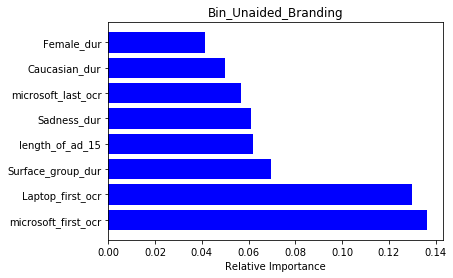

Bin_Brand_Cues__Mean
Feature ranking:
Laptop_total_ocr
microsoft_first_ocr
Surface_group_last_ocr
Laptop_first_ocr
Laptop_dur
African_dur
Neutral_dur
Surface_group_first_ocr
Caucasian_dur
Eastasian_dur
Laptop_last_ocr
Male_dur
microsoft_dur
Age: 25-34_dur
Happiness_dur
microsoft_total_ocr
Female_dur
Surface_group_dur
Tablet_first_ocr
Tablet_last_ocr
Tablet_dur
Tablet_total_ocr
Sadness_dur
microsoft_last_ocr
Age: 35-44_dur
Surface_group_total_ocr
Macbook_group_dur
length_of_ad_15
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


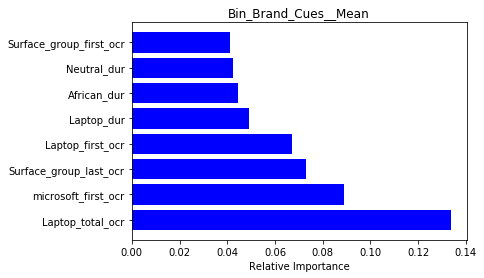

Bin_Aided_Branding__Mean
Feature ranking:
Laptop_total_ocr
Surface_group_last_ocr
Tablet_first_ocr
Tablet_last_ocr
Laptop_dur
microsoft_last_ocr
Tablet_dur
Surface_group_first_ocr
microsoft_first_ocr
Tablet_total_ocr
Laptop_last_ocr
Age: 25-34_dur
Laptop_first_ocr
Male_dur
African_dur
Happiness_dur
Female_dur
microsoft_dur
Sadness_dur
Macbook_group_dur
Neutral_dur
Eastasian_dur
Age: 35-44_dur
microsoft_total_ocr
Caucasian_dur
Surface_group_dur
length_of_ad_15
Surface_group_total_ocr
Lenovo_group_dur
Yoga_dur
HP_group_dur
Windows_dur
ASUS T102_dur
Dell_sub_brand_group_dur


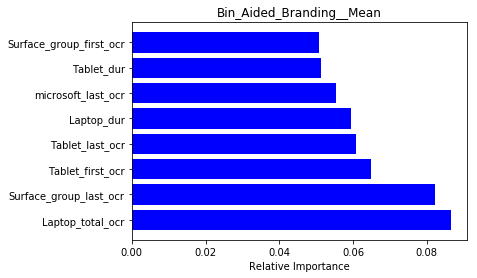

Bin_Active_Involvement__Mean
Feature ranking:
Surface_group_last_ocr
microsoft_last_ocr
Surface_group_first_ocr
Tablet_dur
microsoft_total_ocr
Caucasian_dur
Laptop_last_ocr
Eastasian_dur
microsoft_dur
microsoft_first_ocr
length_of_ad_15
Laptop_total_ocr
Tablet_total_ocr
Laptop_dur
Tablet_first_ocr
Tablet_last_ocr
Surface_group_dur
Age: 35-44_dur
Male_dur
African_dur
Neutral_dur
Age: 25-34_dur
Surface_group_total_ocr
Laptop_first_ocr
Female_dur
Happiness_dur
Sadness_dur
Macbook_group_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


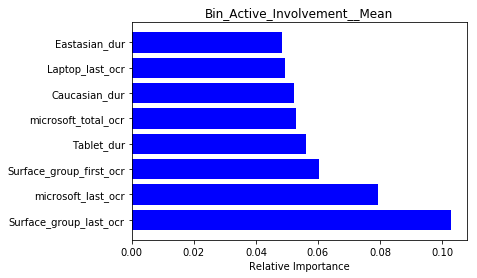

Bin_New_Information__Mean
Feature ranking:
Surface_group_total_ocr
Surface_group_first_ocr
Surface_group_last_ocr
Surface_group_dur
African_dur
Sadness_dur
Tablet_total_ocr
Neutral_dur
Tablet_last_ocr
Happiness_dur
microsoft_first_ocr
Laptop_last_ocr
Age: 25-34_dur
Female_dur
microsoft_dur
Laptop_total_ocr
Laptop_first_ocr
Tablet_dur
microsoft_total_ocr
Laptop_dur
Tablet_first_ocr
microsoft_last_ocr
Eastasian_dur
Caucasian_dur
Male_dur
Age: 35-44_dur
Macbook_group_dur
length_of_ad_15
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


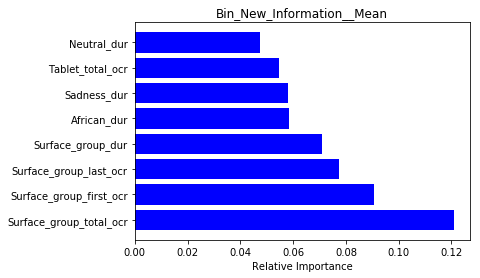

Bin_Enjoyment__Mean
Feature ranking:
Neutral_dur
microsoft_total_ocr
microsoft_dur
Macbook_group_dur
Laptop_dur
Surface_group_dur
Surface_group_first_ocr
microsoft_last_ocr
length_of_ad_15
Age: 25-34_dur
microsoft_first_ocr
Laptop_first_ocr
Surface_group_last_ocr
African_dur
Laptop_total_ocr
Caucasian_dur
Happiness_dur
Laptop_last_ocr
Sadness_dur
Tablet_last_ocr
Tablet_total_ocr
Tablet_dur
Male_dur
Tablet_first_ocr
Female_dur
Eastasian_dur
Surface_group_total_ocr
Age: 35-44_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


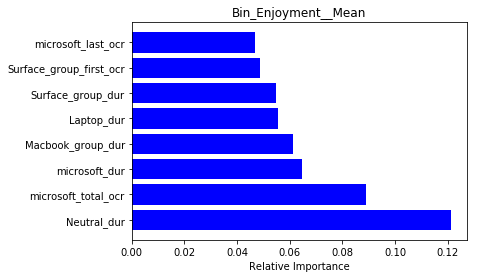

Bin_Brand_Appeal__Mean
Feature ranking:
African_dur
Laptop_last_ocr
Surface_group_dur
microsoft_first_ocr
Neutral_dur
Surface_group_last_ocr
Surface_group_total_ocr
Caucasian_dur
Tablet_first_ocr
microsoft_last_ocr
length_of_ad_15
Laptop_total_ocr
Laptop_dur
microsoft_dur
Male_dur
Female_dur
microsoft_total_ocr
Sadness_dur
Age: 25-34_dur
Surface_group_first_ocr
Laptop_first_ocr
Tablet_last_ocr
Eastasian_dur
Tablet_dur
Macbook_group_dur
Tablet_total_ocr
Happiness_dur
Age: 35-44_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


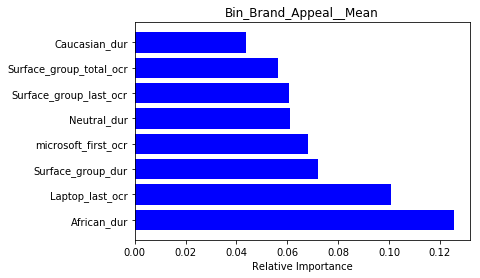

Bin_Understanding__Mean
Feature ranking:
African_dur
Surface_group_dur
microsoft_first_ocr
Laptop_first_ocr
Tablet_first_ocr
Neutral_dur
Female_dur
microsoft_dur
Caucasian_dur
Laptop_last_ocr
Surface_group_total_ocr
length_of_ad_15
microsoft_last_ocr
Tablet_total_ocr
Tablet_last_ocr
Male_dur
microsoft_total_ocr
Surface_group_last_ocr
Tablet_dur
Age: 25-34_dur
Laptop_dur
Surface_group_first_ocr
Sadness_dur
Macbook_group_dur
Laptop_total_ocr
Eastasian_dur
Age: 35-44_dur
Happiness_dur
Lenovo_group_dur
Yoga_dur
Windows_dur
ASUS T102_dur
HP_group_dur
Dell_sub_brand_group_dur


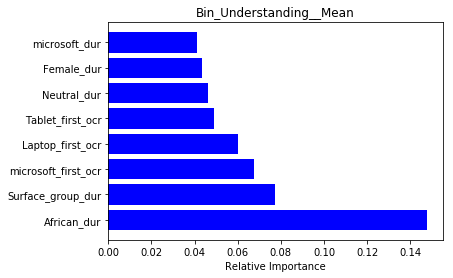

Bin_Relevance_of_Information__Mean
Feature ranking:
Male_dur
Caucasian_dur
African_dur
Surface_group_last_ocr
Tablet_dur
Tablet_last_ocr
microsoft_dur
microsoft_first_ocr
Age: 25-34_dur
Laptop_dur
microsoft_last_ocr
Laptop_first_ocr
Tablet_first_ocr
Eastasian_dur
Laptop_total_ocr
Surface_group_first_ocr
Laptop_last_ocr
Tablet_total_ocr
Macbook_group_dur
microsoft_total_ocr
Happiness_dur
Female_dur
Neutral_dur
Surface_group_dur
Surface_group_total_ocr
Age: 35-44_dur
Sadness_dur
length_of_ad_15
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


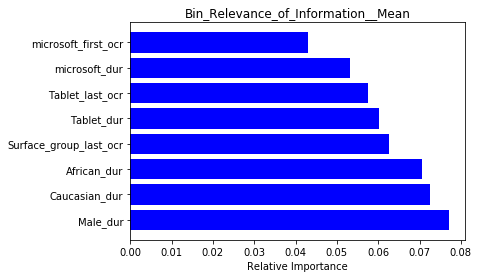

Bin_Credibility_of_Information__Mean
Feature ranking:
Macbook_group_dur
Laptop_first_ocr
African_dur
Tablet_first_ocr
Surface_group_last_ocr
Eastasian_dur
Male_dur
Laptop_total_ocr
Caucasian_dur
Tablet_last_ocr
Neutral_dur
microsoft_total_ocr
Laptop_dur
Laptop_last_ocr
Tablet_total_ocr
Surface_group_first_ocr
Tablet_dur
Surface_group_dur
microsoft_first_ocr
Female_dur
microsoft_last_ocr
Age: 25-34_dur
Sadness_dur
Happiness_dur
Surface_group_total_ocr
microsoft_dur
length_of_ad_15
Age: 35-44_dur
Lenovo_group_dur
Yoga_dur
HP_group_dur
Windows_dur
ASUS T102_dur
Dell_sub_brand_group_dur


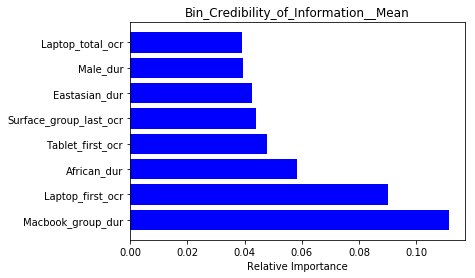

Bin_Brand_Difference__Mean
Feature ranking:
Surface_group_last_ocr
Surface_group_first_ocr
Neutral_dur
length_of_ad_15
Surface_group_dur
Tablet_first_ocr
microsoft_last_ocr
microsoft_first_ocr
Age: 25-34_dur
Laptop_last_ocr
African_dur
Tablet_last_ocr
Happiness_dur
Male_dur
Tablet_total_ocr
Female_dur
Laptop_first_ocr
Caucasian_dur
Laptop_dur
microsoft_dur
Tablet_dur
Laptop_total_ocr
Surface_group_total_ocr
Sadness_dur
microsoft_total_ocr
Macbook_group_dur
Eastasian_dur
Age: 35-44_dur
Lenovo_group_dur
HP_group_dur
Yoga_dur
Windows_dur
ASUS T102_dur
Dell_sub_brand_group_dur


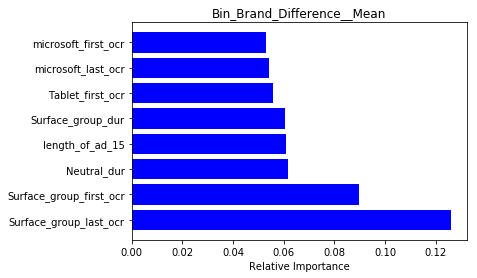

In [21]:
imp_features = model.plot_feature_importance(m,10,Y.columns,x_train[0].columns[:],savefig=False)

In [22]:
shap.initjs()
explainer=[]
shap_values=[]
for i in range(11):
    explainer.append(shap.TreeExplainer(models_11[i][0],))
    shap_values.append(explainer[-1].shap_values(x_train[i]))
    print(i)

0
1
2
3
4
5
6
7
8
9
10


In [63]:
(x_train[0].columns)

Index(['African_dur', 'Eastasian_dur', 'Happiness_dur', 'Neutral_dur',
       'Sadness_dur', 'length_of_ad_15', 'Female_dur', 'Male_dur',
       'Age: 15-24_dur', 'Age: 25-34_dur', 'Age: 35-44_dur', 'microsoft_dur',
       'microsoft_first_ocr', 'microsoft_last_ocr', 'microsoft_total_ocr',
       'ASUS T102_dur', 'Dell_sub_brand_group_dur', 'HP_group_dur',
       'Lenovo_group_dur', 'Macbook_group_dur', 'Surface_group_dur',
       'Windows_dur', 'Yoga_dur', 'Windows_first_ocr', 'Windows_last_ocr',
       'Windows_total_ocr', 'Asus_text_dur', 'Currys PCs world_text_dur',
       'Dell_text_dur', 'Hp_text_dur', 'Lenovo_text_dur', 'Hp_text_first_ocr',
       'Hp_text_last_ocr', 'Hp_text_total_ocr', 'Apple_dur', 'Asus_dur',
       'Dell_dur', 'Hp_dur', 'Hp_first_ocr', 'Hp_last_ocr', 'Hp_total_ocr',
       'Laptop_dur', 'Laptop_first_ocr', 'Laptop_last_ocr', 'Laptop_total_ocr',
       'Tablet_dur', 'Tablet_first_ocr', 'Tablet_last_ocr',
       'Tablet_total_ocr'],
      dtype='object')

In [23]:
imp_features_shap=[]
for i in range(11):
    shap_imp_cols=[]
    shap_val=[]
    for j,col in enumerate(x_train[0]):
        sv = np.absolute(shap_values[i][0][:,j]).mean()+np.absolute(shap_values[i][1][:,j]).mean()+np.absolute(shap_values[i][2][:,j]).mean()        
        shap_val.append(sv)
    shap_imp_cols = x_train[0].columns[np.argsort(shap_val)[::-1]]
    imp_features_shap.append(shap_imp_cols[:10])

In [215]:
(imp_features_shap[0])

Index(['microsoft_first_ocr', 'length_of_ad_15', 'Laptop_first_ocr',
       'Surface_group_dur', 'Laptop_last_ocr', 'Caucasian_dur',
       'microsoft_last_ocr', 'microsoft_dur', 'Female_dur', 'Sadness_dur'],
      dtype='object')

In [63]:
indices=[[],[],[]]
for l,val in enumerate(y_train[0].values):
    indices[int(val)-1].append(l)

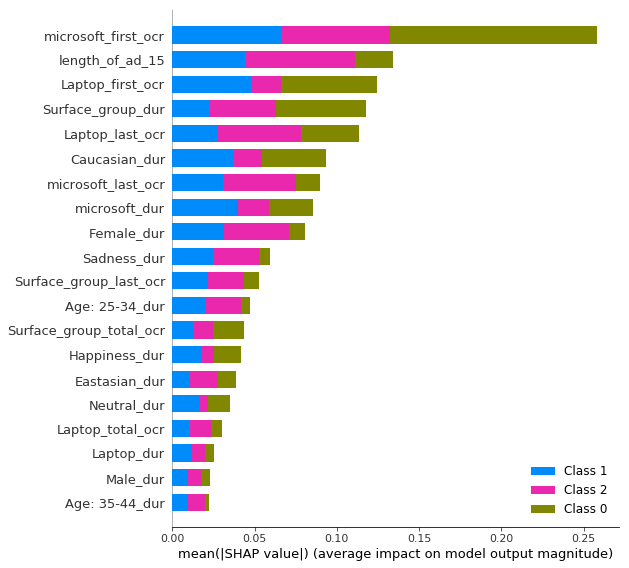

In [96]:
for i,col in enumerate(Y.columns):
    plt.figure()
    shap.summary_plot(shap_values[i],x_train[i],plot_type="dot",show=False)
    plt.savefig('./bin_shap_surface_dot/'+col,bbox_inches='tight')

In [85]:
i,j,k = 0,0,7
shap_values[i][j][indices[j],k].mean()+shap_values[i][j+1][indices[j+1],k].mean()+shap_values[i][j+2][indices[j+2],k].mean()

0.09154234372984131

In [120]:
model_rf.shap_analysis(shap_values,y_train,x_train[0].columns,imp_features[:,:10])

Bin_Unaided_Branding Bin_Unaided_Branding_val Bin_Unaided_Branding_val2  \
0     microsoft_first_ocr                 0.194518                 0.0738179   
1        Laptop_first_ocr                0.0798802                 0.0600765   
2         Laptop_last_ocr                  0.04493                 0.0335237   
3         length_of_ad_15                0.0308609                 0.0430153   
4       Surface_group_dur                0.0731348                  0.030404   
5      microsoft_last_ocr                 0.022792                 0.0336506   
6           microsoft_dur                0.0444512                 0.0461898   
7           Caucasian_dur                0.0445919                 0.0506569   
8  Surface_group_last_ocr               0.00955884                 0.0268939   
9              Female_dur                0.0106351                 0.0396378   

  Bin_Unaided_Branding_val3 Bin_Unaided_Branding_class  \
0                 0.0720469                          0   
1                 0.0202884                          0   
2                 0.0734832                          2   
3                 0.0703561                          2   
4                 0.0448838                          0   
5                 0.0590077                          2   
6                 0.0183714                          1   
7                 0.0188501                          1   
8                 0.0339381                          2   
9                 0.0412695                          2   

      Bin_Brand_Cues__Mean Bin_Brand_Cues__Mean_val Bin_Brand_Cues__Mean_val2  \
0         Laptop_total_ocr                 0.102123                  0.123099   
1         Laptop_first_ocr                0.0479816                 0.0537656   
2              Neutral_dur                0.0377341                 0.0511006   
3      microsoft_first_ocr                0.0318052                 0.0421303   
4   Surface_group_last_ocr                0.0392754                  0.022189   
5            Eastasian_dur                0.0438044                 0.0350616   
6              African_dur                0.0438089                 0.0243114   
7               Laptop_dur                0.0220677                 0.0359862   
8  Surface_group_first_ocr                0.0259711                 0.0232967   
9          Laptop_last_ocr                0.0288358                 0.0251184   

  Bin_Brand_Cues__Mean_val3 Bin_Brand_Cues__Mean_class  ...  \
0                 0.0514431                          1  ...   
1                  0.071804                          2  ...   
2                 0.0767633                          2  ...   
3                 0.0655494                          2  ...   
4                 0.0484473                          2  ...   
5                 0.0301055                          0  ...   
6                 0.0535636                          2  ...   
7                 0.0232181                          1  ...   
8                 0.0126612                          0  ...   
9                 0.0180794                          0  ...   

  Bin_Credibility_of_Information__Mean  \
0                     Laptop_first_ocr   
1               Surface_group_last_ocr   
2                    Macbook_group_dur   
3                        Caucasian_dur   
4                     Tablet_first_ocr   
5                          African_dur   
6                          Neutral_dur   
7                        Eastasian_dur   
8                           Tablet_dur   
9                      Laptop_last_ocr   

  Bin_Credibility_of_Information__Mean_val  \
0                                0.0298331   
1                                 0.042654   
2                                0.0759445   
3                                0.0217921   
4                                0.0699974   
5                                0.0208359   
6                                0.0177602   
7                                0.0188484   
8                     

In [79]:
np.array(sorted(shap_values[0][0][:,1])).sum()

-3.582511825656285

### Earlier Work

In [61]:
interaction_value = explainer[0].shap_interaction_values(x_train[0])

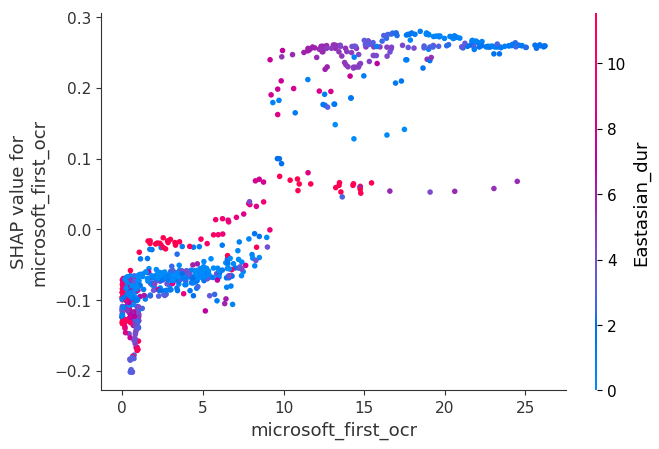

In [65]:
shap.dependence_plot("microsoft_first_ocr",shap_values[0][0],x_train[0],display_features="")

In [44]:
shap_analysis_pd = pd.DataFrame(index=[i for i in range(10)])
for k,target in enumerate(Y.columns):
    temp_dict = {}
    feature_impact=pd.DataFrame(columns=[target,target+'_val'],index=[i for i in range(10)])
    for i,col in enumerate(x_train[k].columns):
        temp_dict[col] = shap_values_xgb[k][0][:,i].mean()

    s = sorted(temp_dict,key = lambda x: abs(temp_dict[x]))
    temp_val = {temp_dict[col] for col in s[-10:]}

    for i,col in enumerate(s[-10:]):
        if temp_dict[col] > 10**(-4):
            feature_impact.iloc[i,:] = [col,"Positive"]
        elif temp_dict[col] < -10**(-4):
            feature_impact.iloc[i,:] = [col,"Negative"]
        else:
            feature_impact.iloc[i,:] = [col,"Neutral"]
    
    shap_analysis_pd = pd.concat((shap_analysis_pd,feature_impact),axis=1)

In [51]:
# model_xgb.shap_analysis(shap_values_xgb,x_train[i],Y.columns,x_train[0].columns,required_cols=cols,n_features=10)

## XGBOOST

In [24]:
model_xgb = Model('xgb','class')

In [33]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [30]:
print("------------------------ 11 Models XGB Training ----------------------------\n")
models_xgb_11=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_xgb_11.append(model_xgb.train(x_train[i],y_train[i],x_test[i],y_test[i],metrics='accuracy',plot_error=False))

------------------------ 11 Models XGB Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


For training set
accuracy_score: 0.994048
For test set
accuracy_score: 0.994444


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


For training set
accuracy_score: 0.997619
For test set
accuracy_score: 0.997222


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


For training set
accuracy_score: 0.994048
For test set
accuracy_score: 0.997222


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


For training set
accuracy_score: 0.995238
For test set
accuracy_score: 1.000000


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


For training set
accuracy_score: 0.995252
For test set
accuracy_score: 0.997222


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


For training set
accuracy_score: 0.992857
For test set
accuracy_score: 0.997222


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


For training set
accuracy_score: 0.995252
For test set
accuracy_score: 0.991667


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


For training set
accuracy_score: 0.996436
For test set
accuracy_score: 1.000000


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


For training set
accuracy_score: 0.996414
For test set
accuracy_score: 0.997222


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


For training set
accuracy_score: 0.992885
For test set
accuracy_score: 0.997222


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
accuracy_score: 0.996450
For test set
accuracy_score: 0.997222




In [31]:
m_xgb = [m1[0] for m1 in models_xgb_11]

Bin_Unaided_Branding
length_of_ad_15
microsoft_first_ocr
Laptop_first_ocr
microsoft_last_ocr
Surface_group_total_ocr
Surface_group_dur
Laptop_last_ocr
Female_dur
microsoft_dur
Surface_group_last_ocr
Caucasian_dur
Macbook_group_dur
Surface_group_first_ocr
Age: 35-44_dur
Sadness_dur
African_dur
Eastasian_dur
Happiness_dur
microsoft_total_ocr
Age: 25-34_dur
Male_dur
Laptop_total_ocr
Neutral_dur
Tablet_dur
Laptop_dur
Tablet_first_ocr
Tablet_total_ocr
Tablet_last_ocr
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


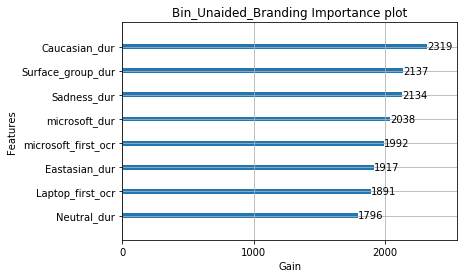

Bin_Brand_Cues__Mean
microsoft_first_ocr
Laptop_total_ocr
Macbook_group_dur
African_dur
Laptop_first_ocr
Laptop_last_ocr
Surface_group_last_ocr
microsoft_last_ocr
Neutral_dur
Laptop_dur
Eastasian_dur
length_of_ad_15
Tablet_first_ocr
Surface_group_first_ocr
microsoft_dur
Caucasian_dur
Tablet_last_ocr
Tablet_dur
Age: 35-44_dur
Tablet_total_ocr
Sadness_dur
Age: 25-34_dur
Male_dur
Happiness_dur
Surface_group_dur
microsoft_total_ocr
Surface_group_total_ocr
Female_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


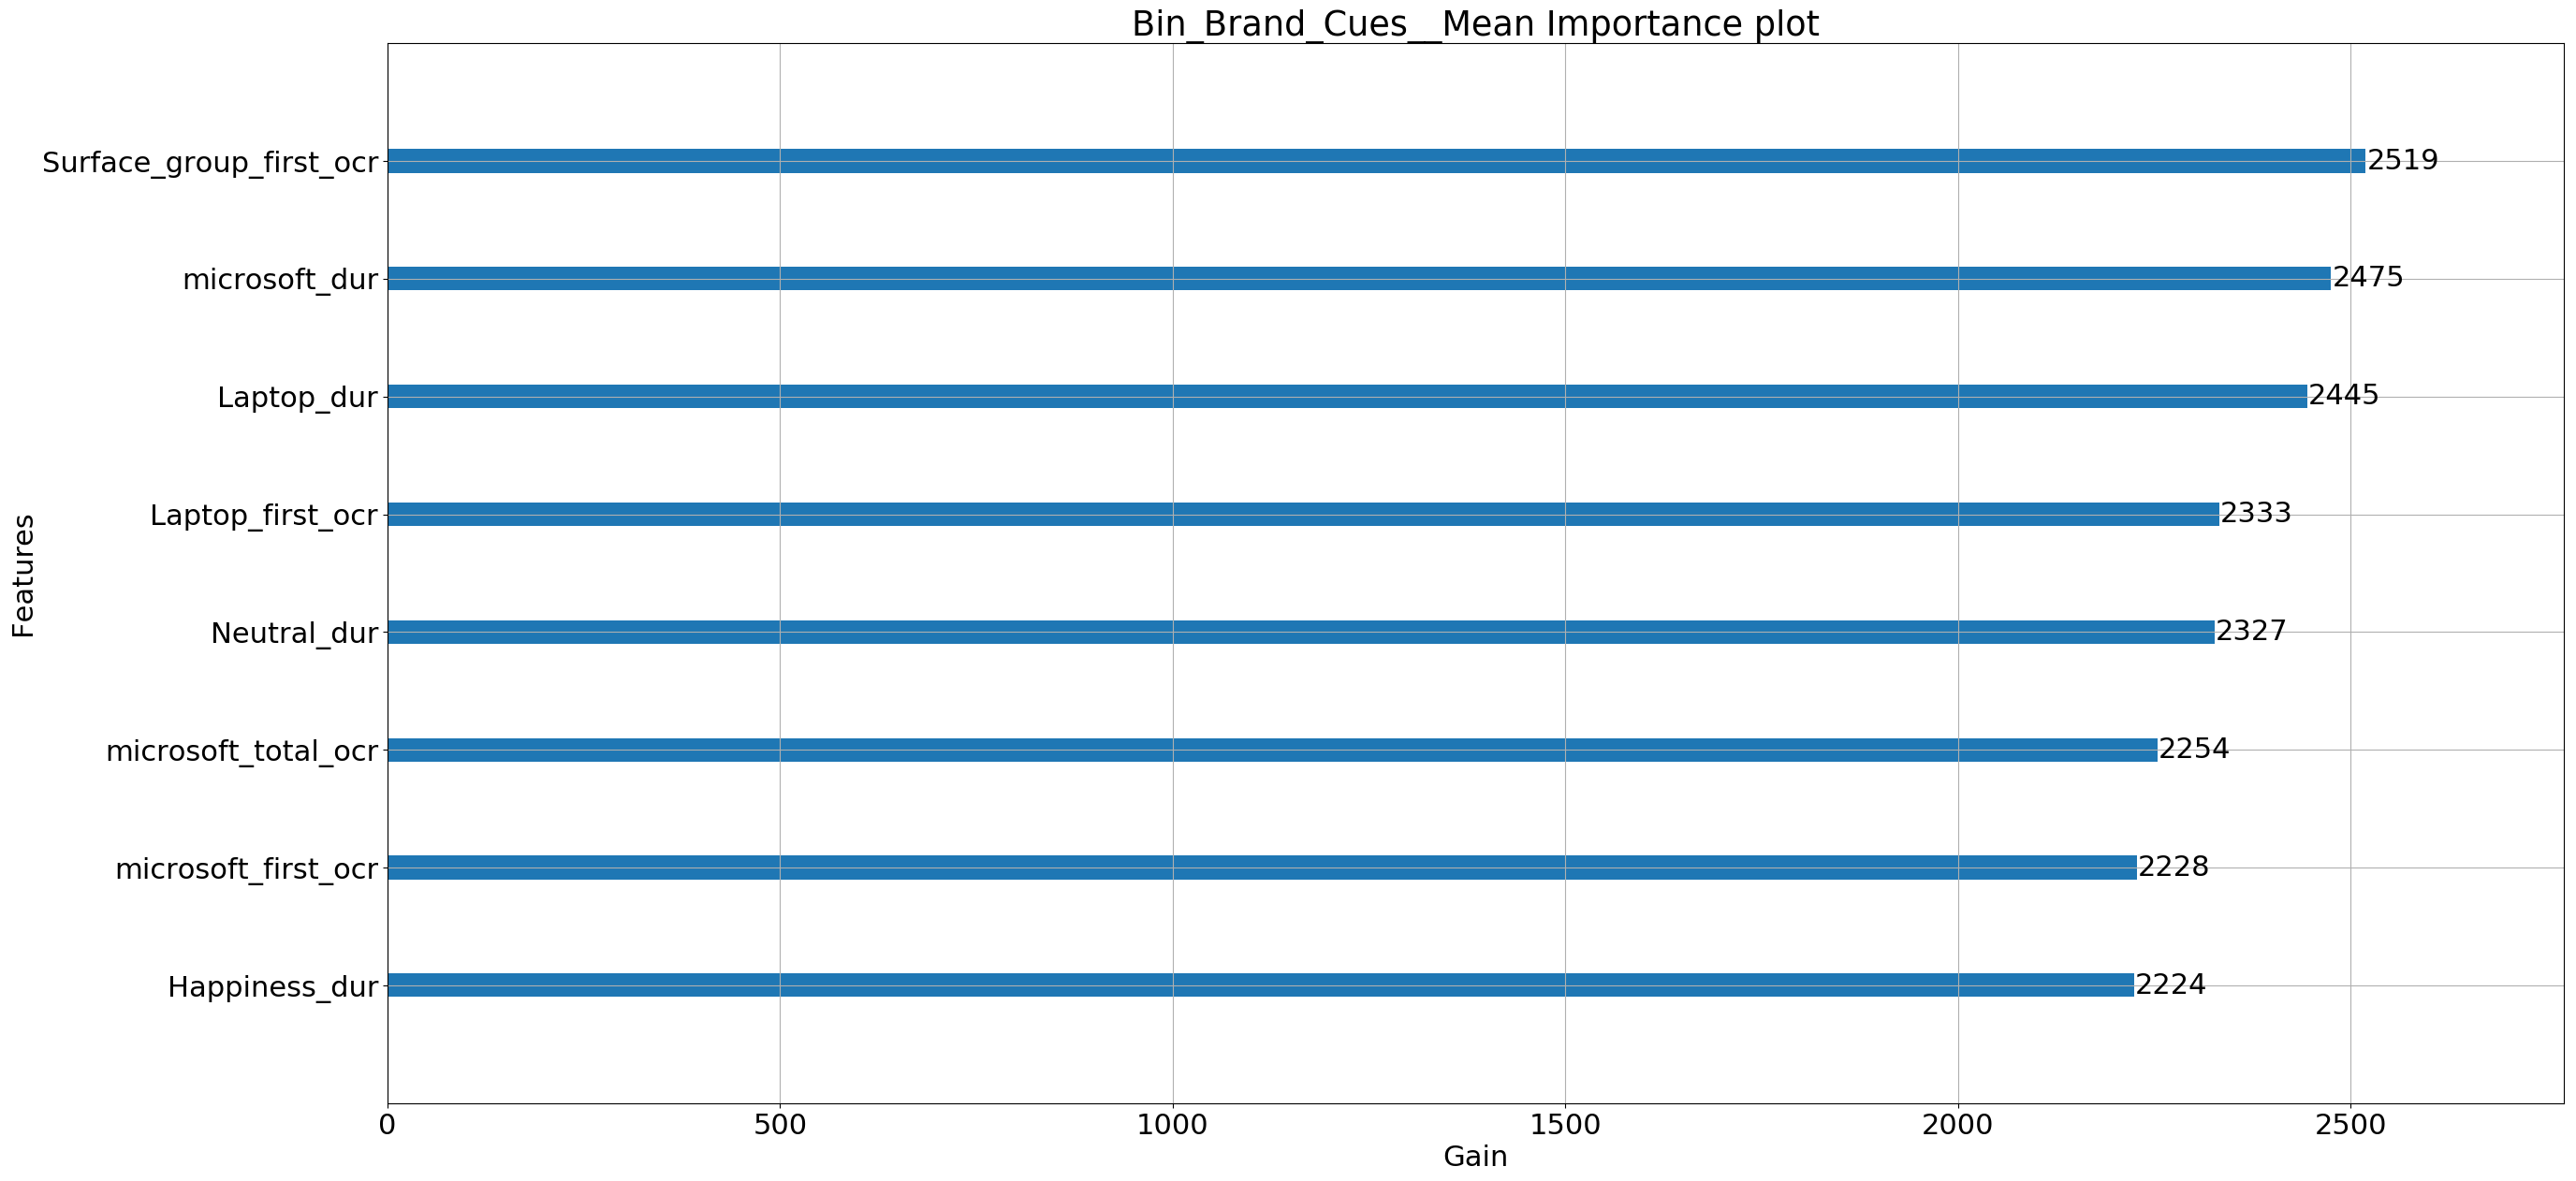

Bin_Aided_Branding__Mean
Macbook_group_dur
microsoft_last_ocr
Tablet_last_ocr
Tablet_first_ocr
African_dur
Laptop_last_ocr
Surface_group_last_ocr
length_of_ad_15
Tablet_dur
Laptop_total_ocr
microsoft_first_ocr
Laptop_dur
Surface_group_first_ocr
Tablet_total_ocr
Surface_group_total_ocr
microsoft_dur
Laptop_first_ocr
Happiness_dur
Male_dur
Age: 35-44_dur
Surface_group_dur
Neutral_dur
Female_dur
Age: 25-34_dur
Sadness_dur
microsoft_total_ocr
Eastasian_dur
Caucasian_dur
Lenovo_group_dur
Yoga_dur
ASUS T102_dur
Windows_dur
HP_group_dur
Dell_sub_brand_group_dur


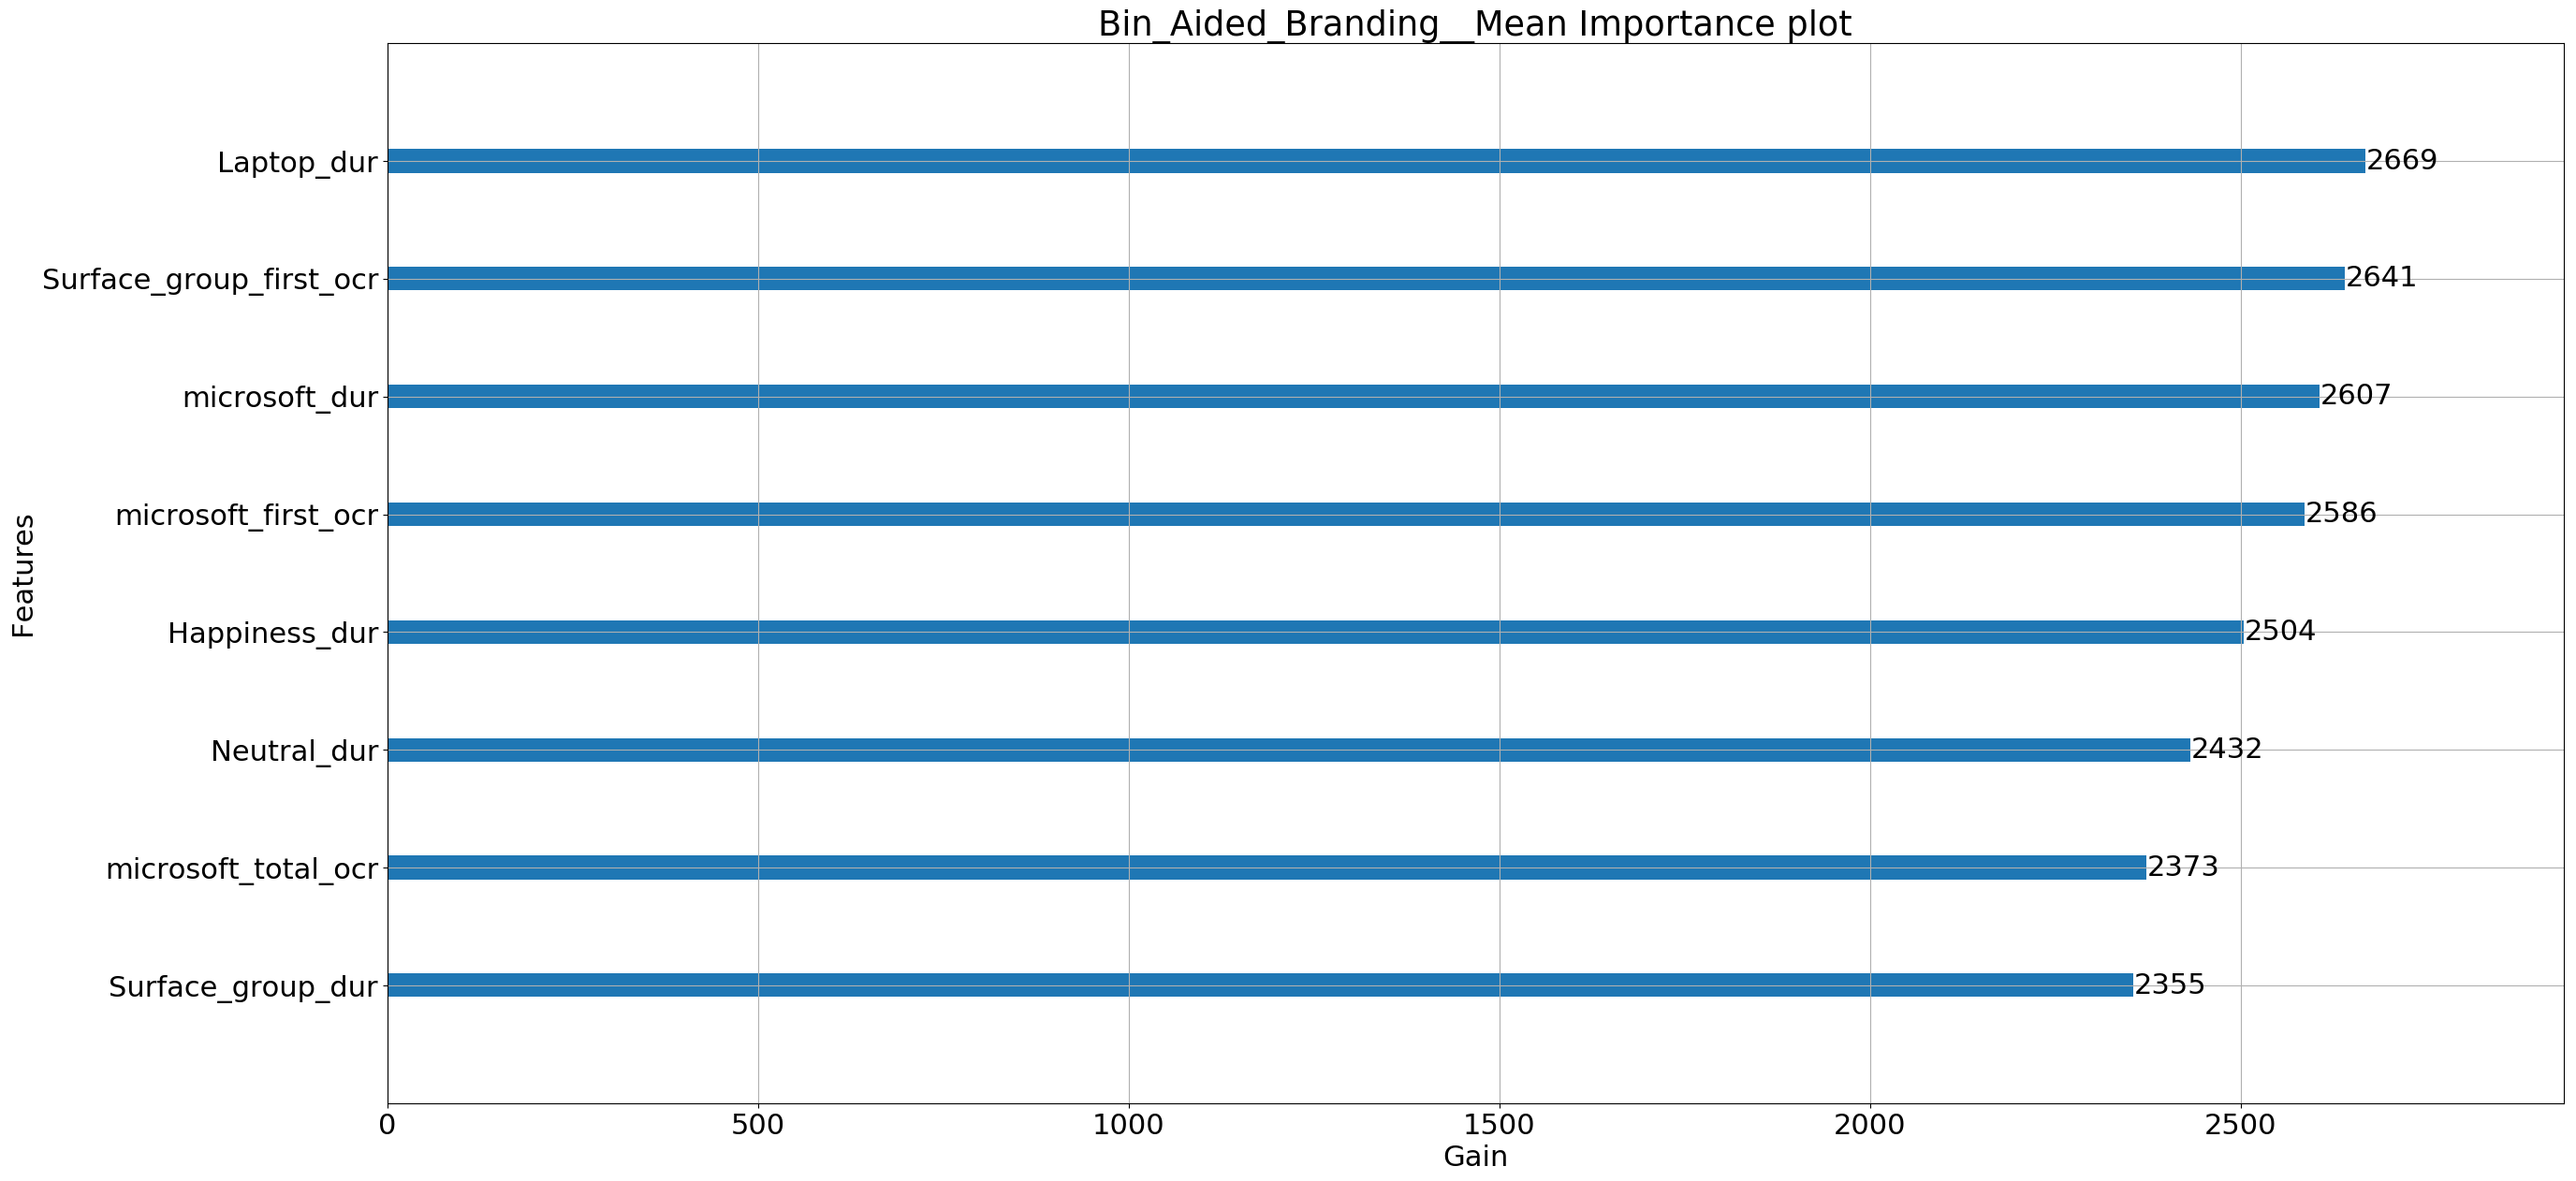

Bin_Active_Involvement__Mean
Surface_group_last_ocr
microsoft_first_ocr
microsoft_last_ocr
Tablet_dur
length_of_ad_15
Surface_group_first_ocr
Surface_group_dur
Tablet_last_ocr
Eastasian_dur
Laptop_total_ocr
Caucasian_dur
Tablet_total_ocr
Tablet_first_ocr
microsoft_dur
African_dur
Laptop_last_ocr
microsoft_total_ocr
Surface_group_total_ocr
Male_dur
Laptop_dur
Female_dur
Age: 35-44_dur
Laptop_first_ocr
Age: 25-34_dur
Happiness_dur
Neutral_dur
Sadness_dur
Macbook_group_dur
Lenovo_group_dur
HP_group_dur
Yoga_dur
Windows_dur
ASUS T102_dur
Dell_sub_brand_group_dur


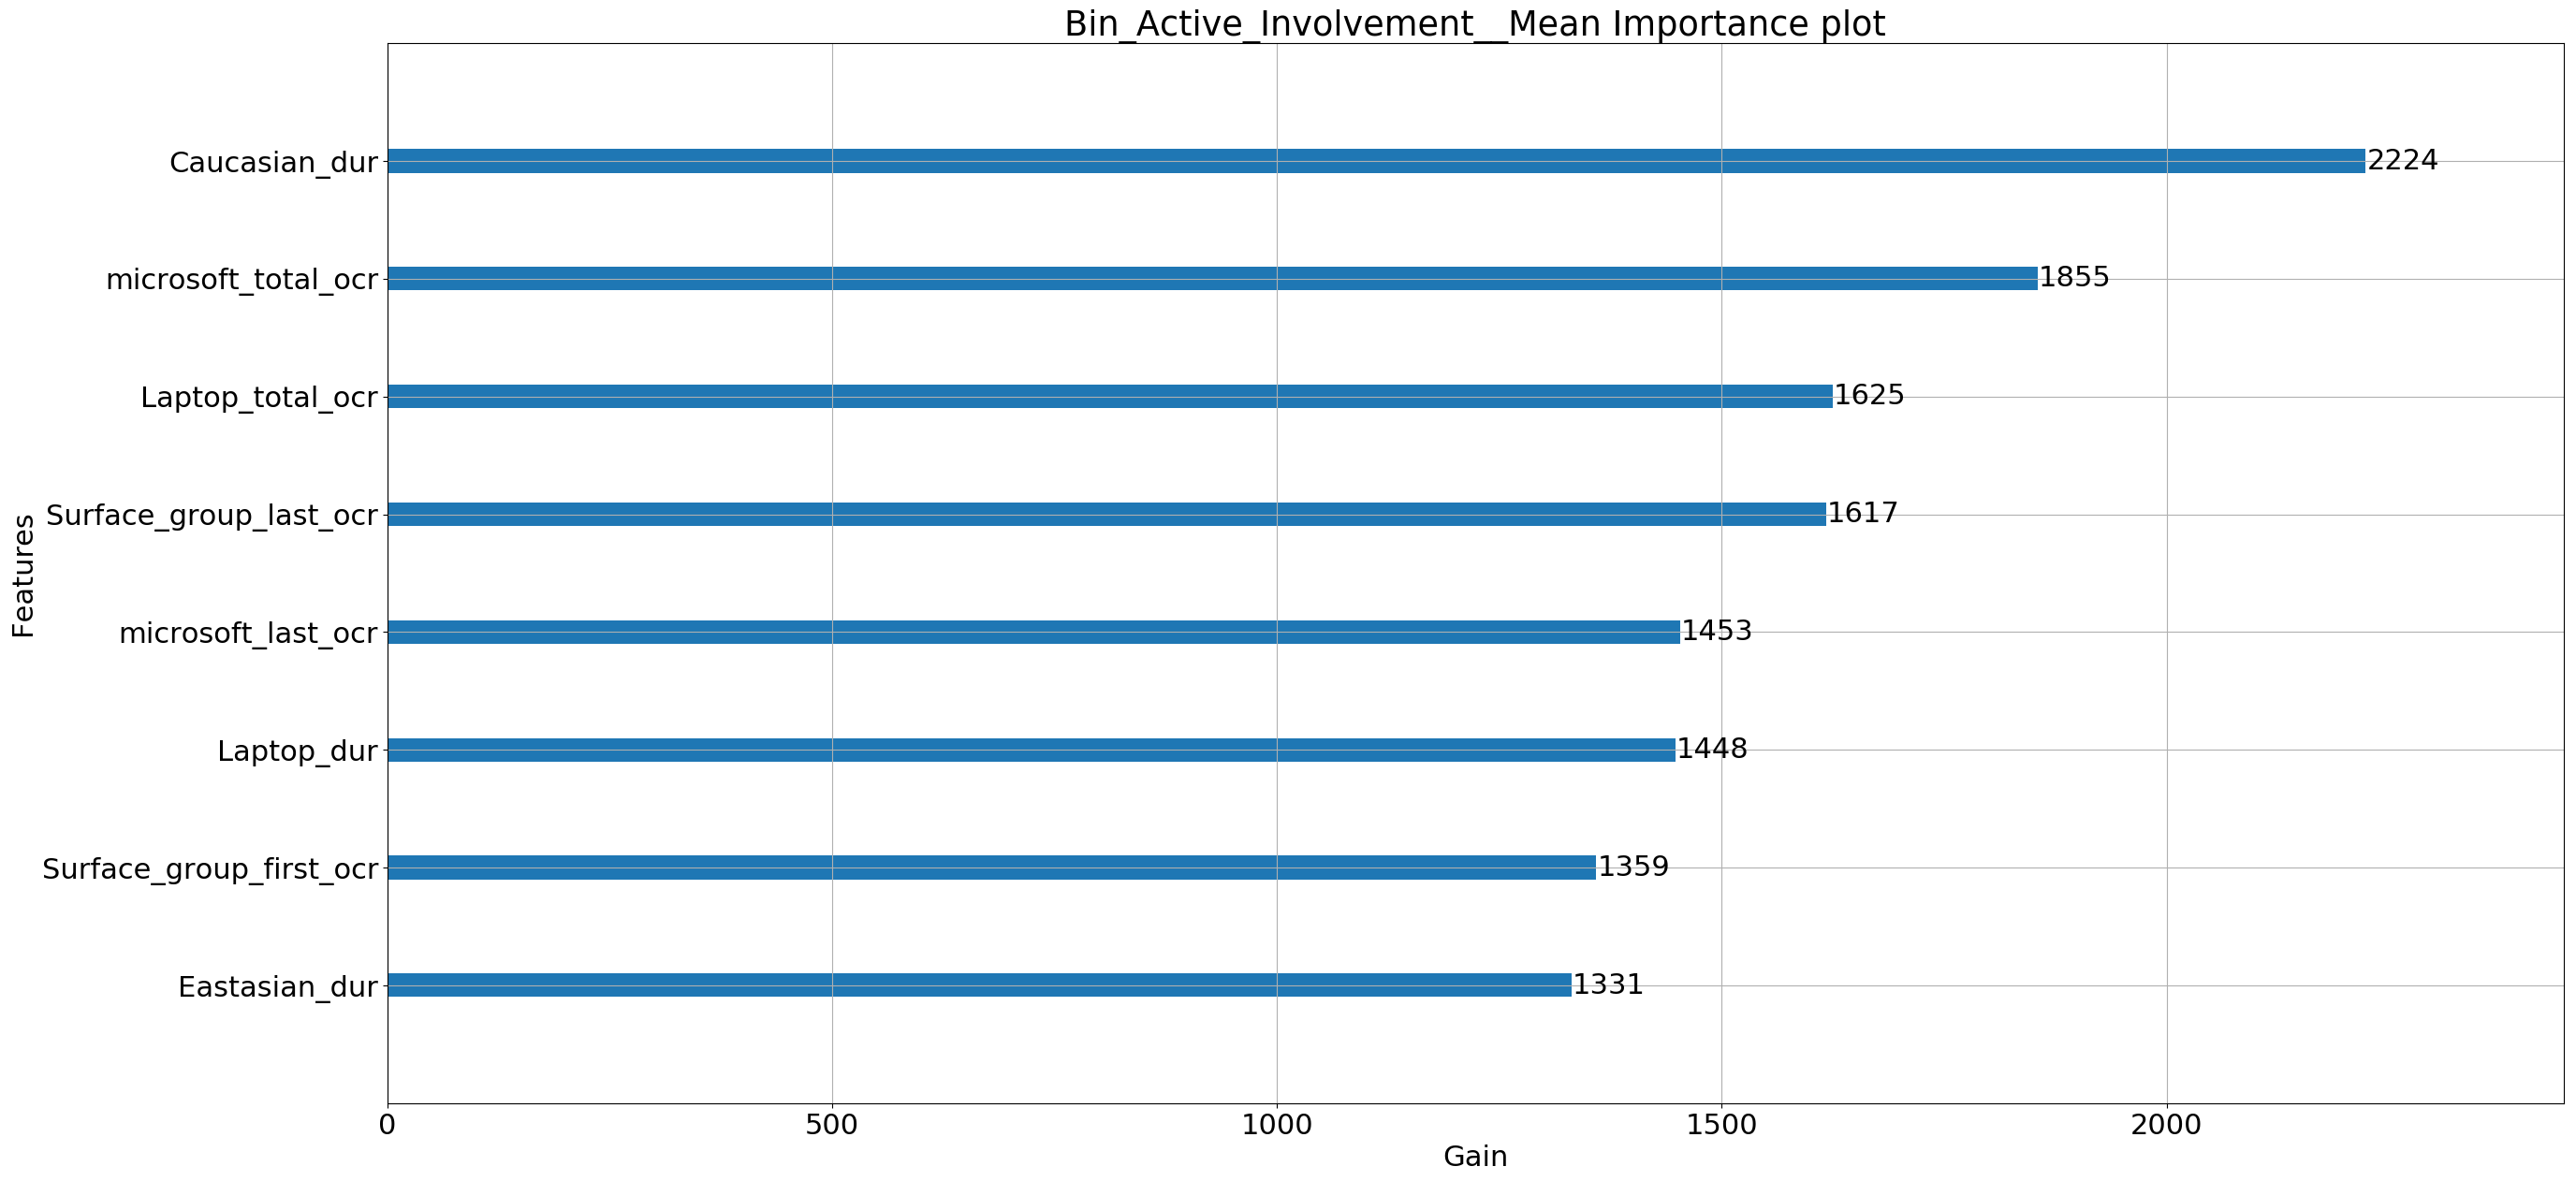

Bin_New_Information__Mean
Surface_group_total_ocr
African_dur
Tablet_total_ocr
Tablet_last_ocr
Surface_group_dur
Surface_group_first_ocr
Surface_group_last_ocr
Tablet_first_ocr
Tablet_dur
microsoft_last_ocr
Female_dur
Laptop_dur
Eastasian_dur
Laptop_last_ocr
microsoft_first_ocr
Sadness_dur
Laptop_total_ocr
Neutral_dur
Macbook_group_dur
microsoft_total_ocr
microsoft_dur
Happiness_dur
Age: 35-44_dur
Male_dur
length_of_ad_15
Laptop_first_ocr
Age: 25-34_dur
Caucasian_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


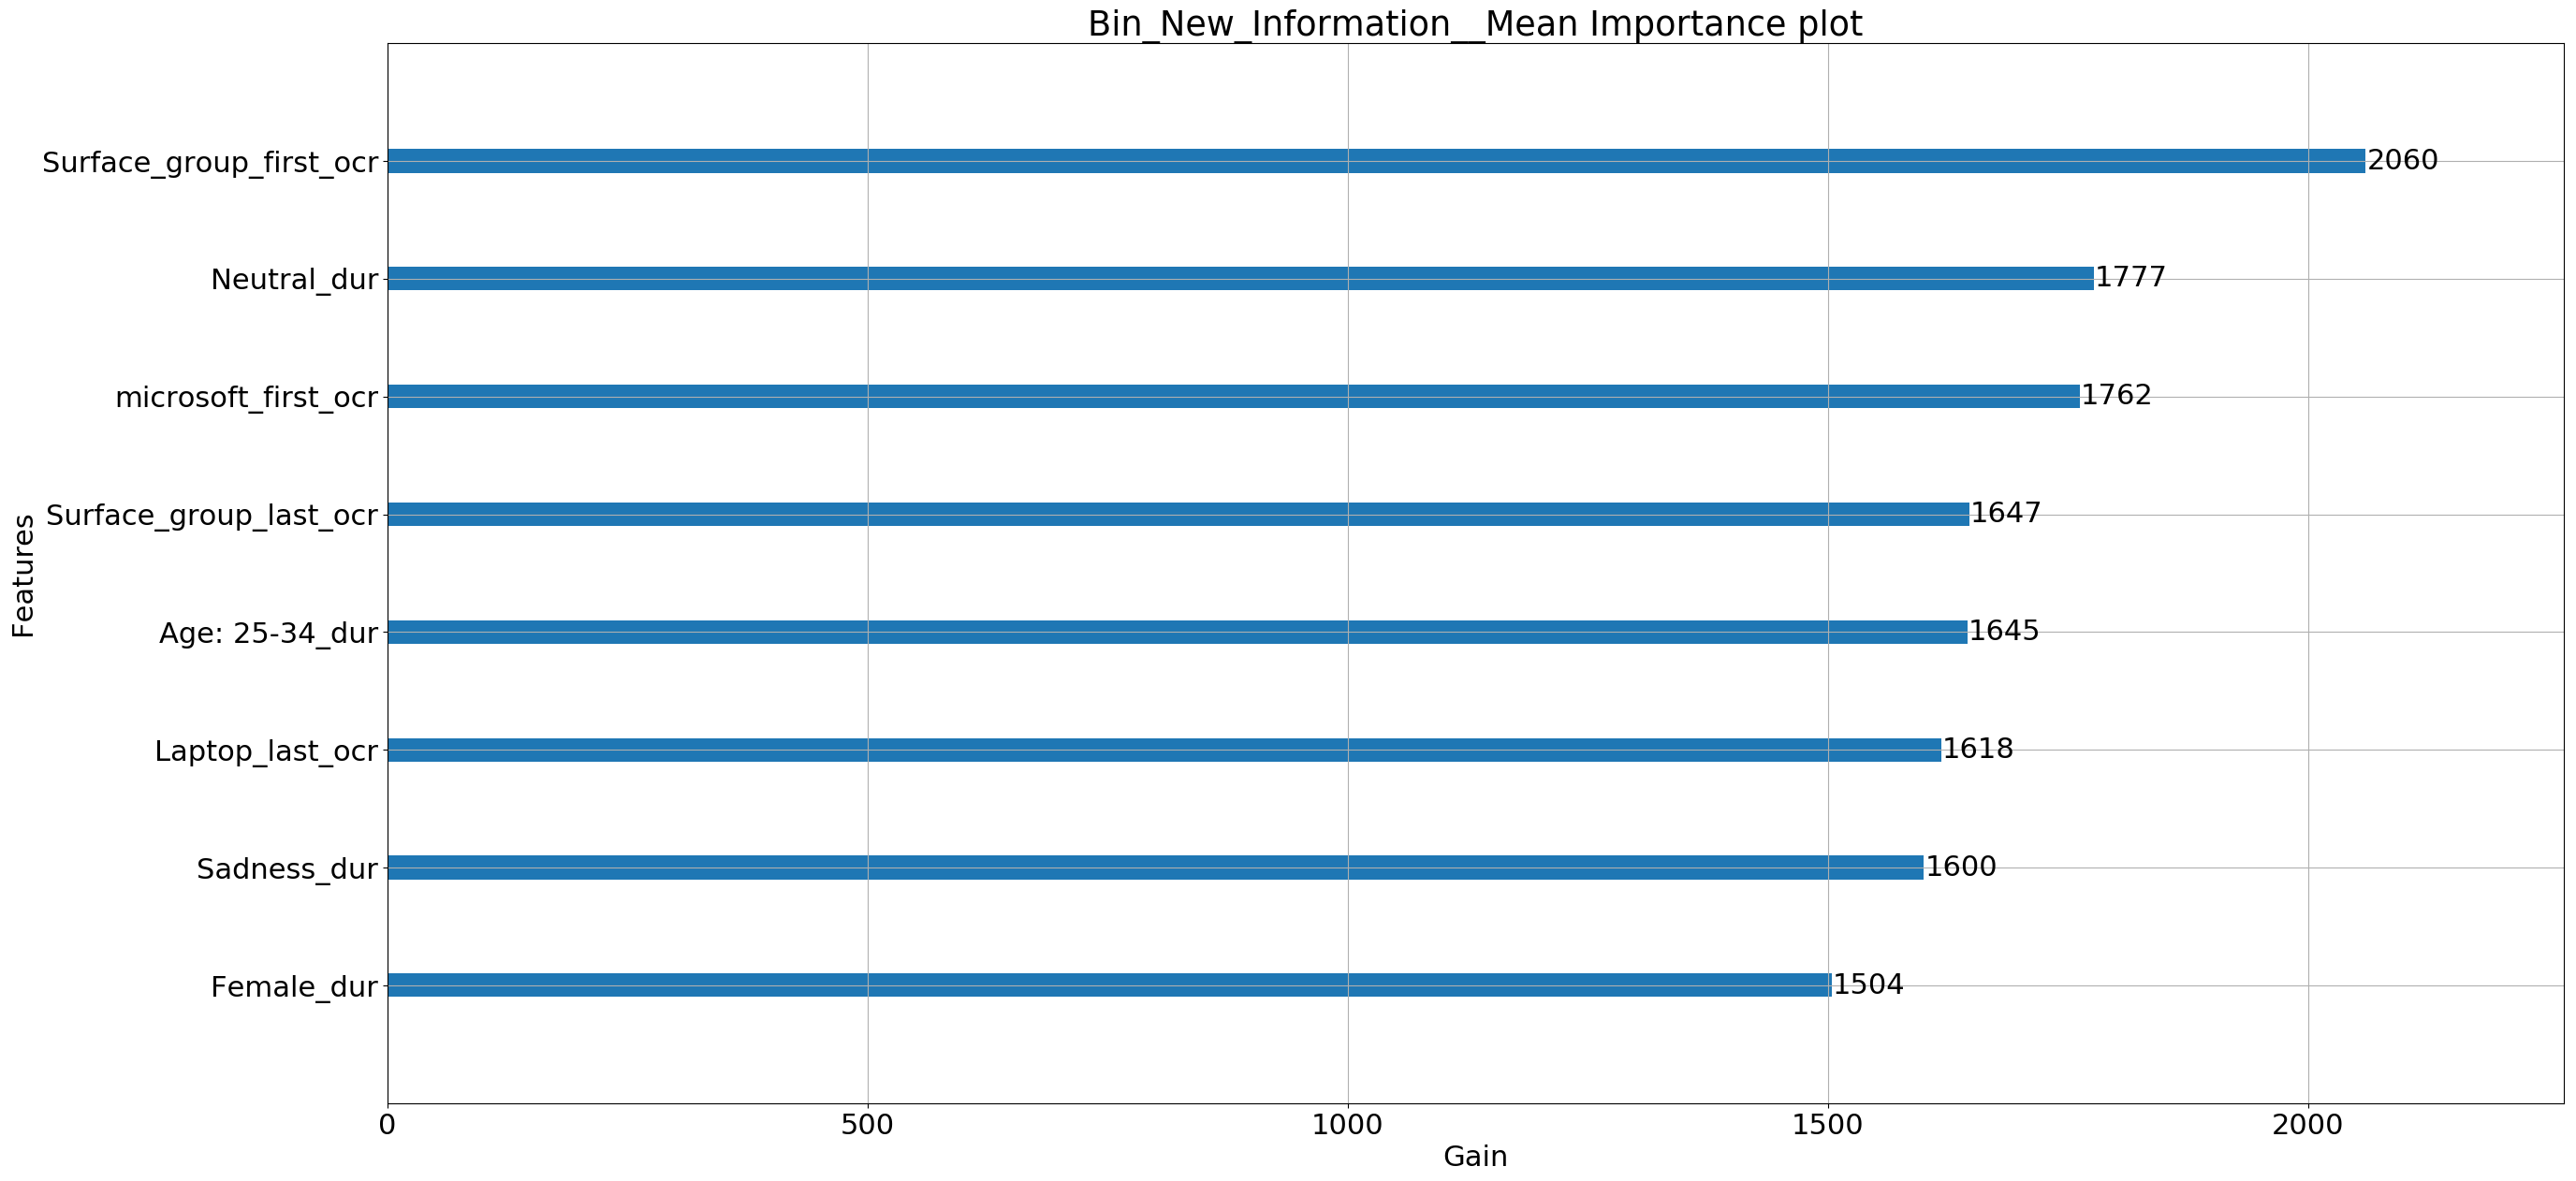

Bin_Enjoyment__Mean
Macbook_group_dur
length_of_ad_15
microsoft_total_ocr
Neutral_dur
Surface_group_dur
Laptop_dur
African_dur
microsoft_dur
Age: 25-34_dur
microsoft_last_ocr
Tablet_total_ocr
Eastasian_dur
Tablet_dur
Laptop_total_ocr
Laptop_last_ocr
microsoft_first_ocr
Caucasian_dur
Surface_group_first_ocr
Female_dur
Tablet_last_ocr
Surface_group_last_ocr
Happiness_dur
Laptop_first_ocr
Male_dur
Age: 35-44_dur
Sadness_dur
Tablet_first_ocr
Surface_group_total_ocr
Yoga_dur
Windows_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Dell_sub_brand_group_dur


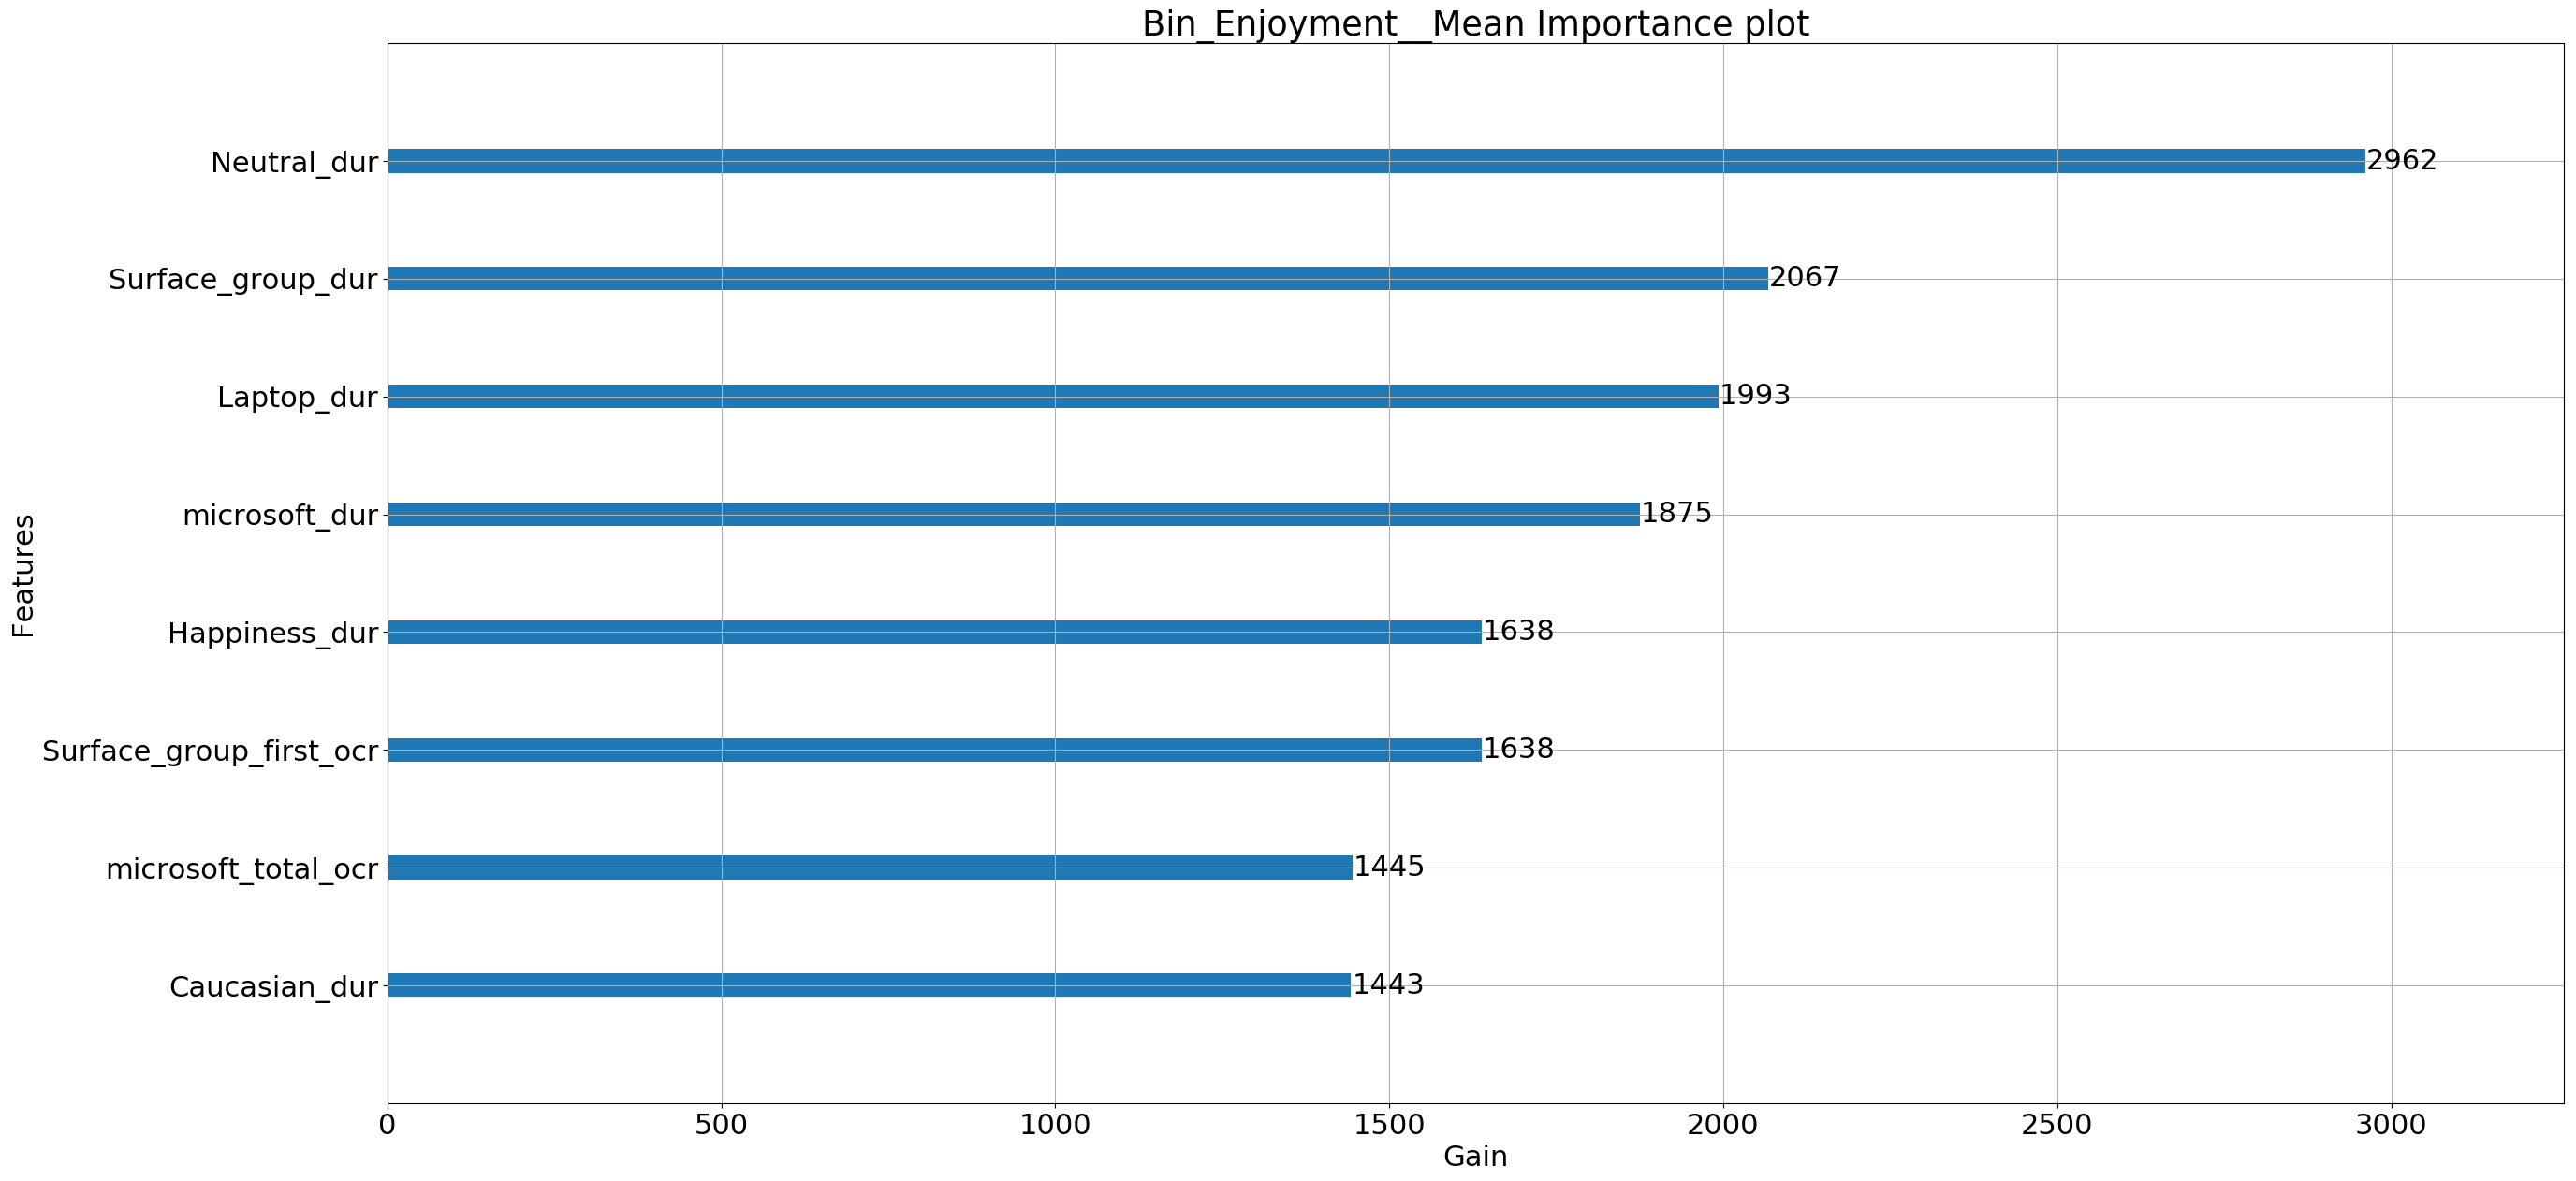

Bin_Brand_Appeal__Mean
African_dur
Laptop_last_ocr
Female_dur
microsoft_first_ocr
Surface_group_last_ocr
microsoft_dur
Macbook_group_dur
Surface_group_dur
microsoft_last_ocr
Tablet_first_ocr
Surface_group_total_ocr
Neutral_dur
Laptop_total_ocr
length_of_ad_15
Laptop_first_ocr
Happiness_dur
microsoft_total_ocr
Laptop_dur
Male_dur
Caucasian_dur
Surface_group_first_ocr
Tablet_dur
Tablet_total_ocr
Tablet_last_ocr
Age: 25-34_dur
Sadness_dur
Age: 35-44_dur
Eastasian_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


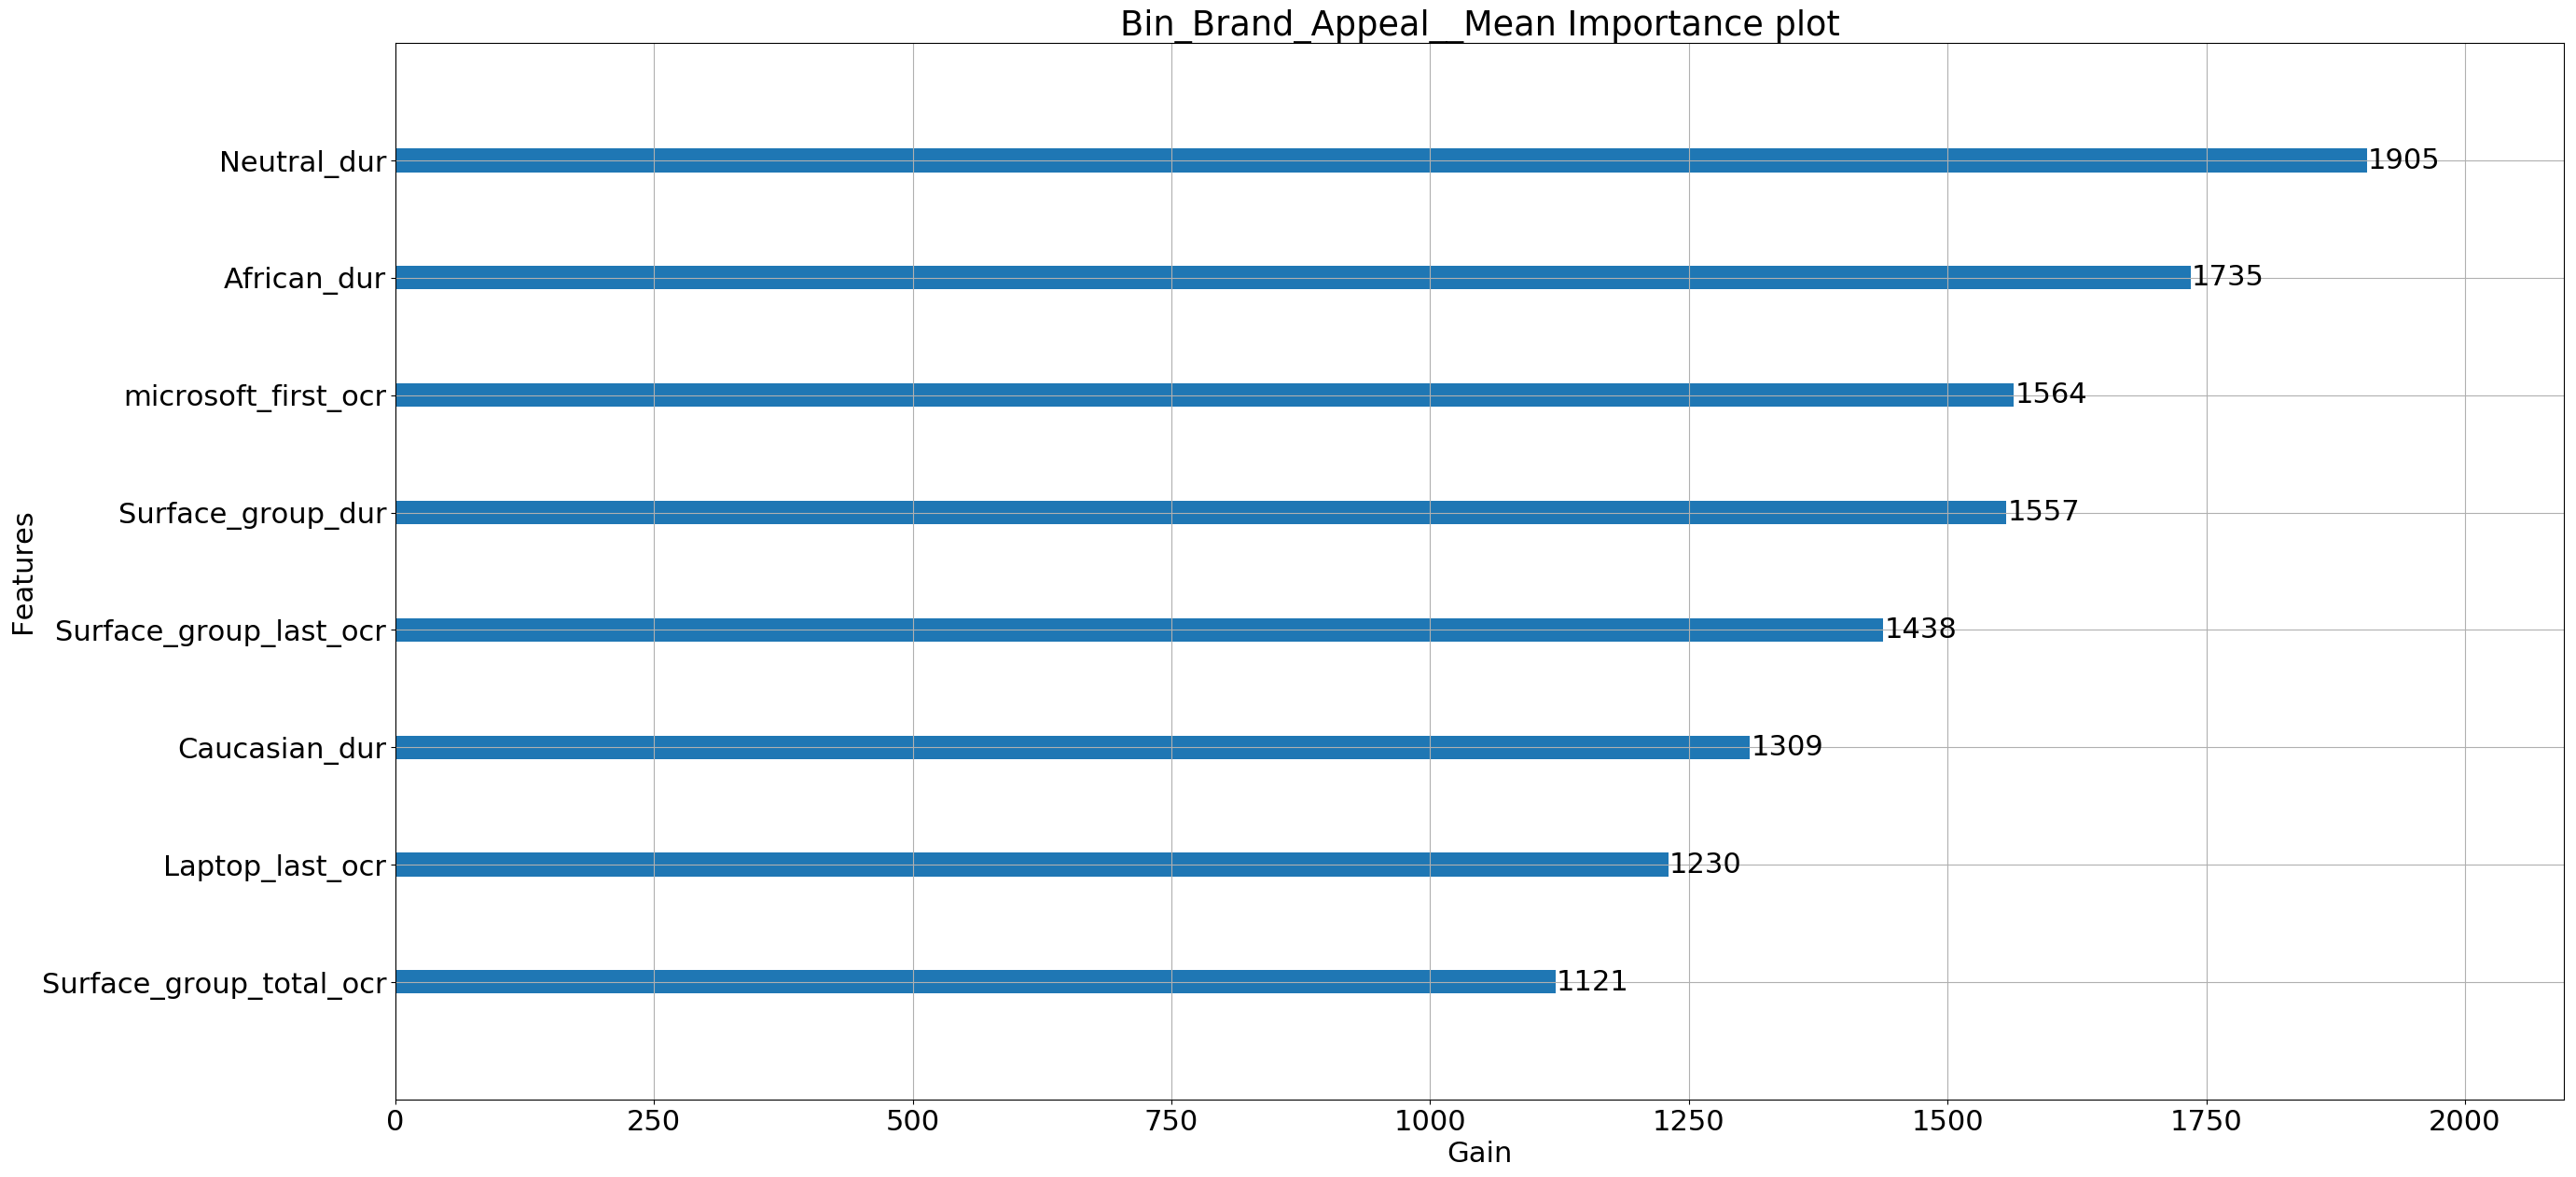

Bin_Understanding__Mean
African_dur
length_of_ad_15
Neutral_dur
microsoft_last_ocr
Laptop_last_ocr
microsoft_dur
Surface_group_total_ocr
microsoft_total_ocr
Male_dur
Tablet_last_ocr
Laptop_first_ocr
Surface_group_last_ocr
Tablet_first_ocr
Female_dur
Tablet_dur
Surface_group_dur
microsoft_first_ocr
Surface_group_first_ocr
Tablet_total_ocr
Caucasian_dur
Age: 25-34_dur
Happiness_dur
Eastasian_dur
Macbook_group_dur
Laptop_dur
Laptop_total_ocr
Sadness_dur
Age: 35-44_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


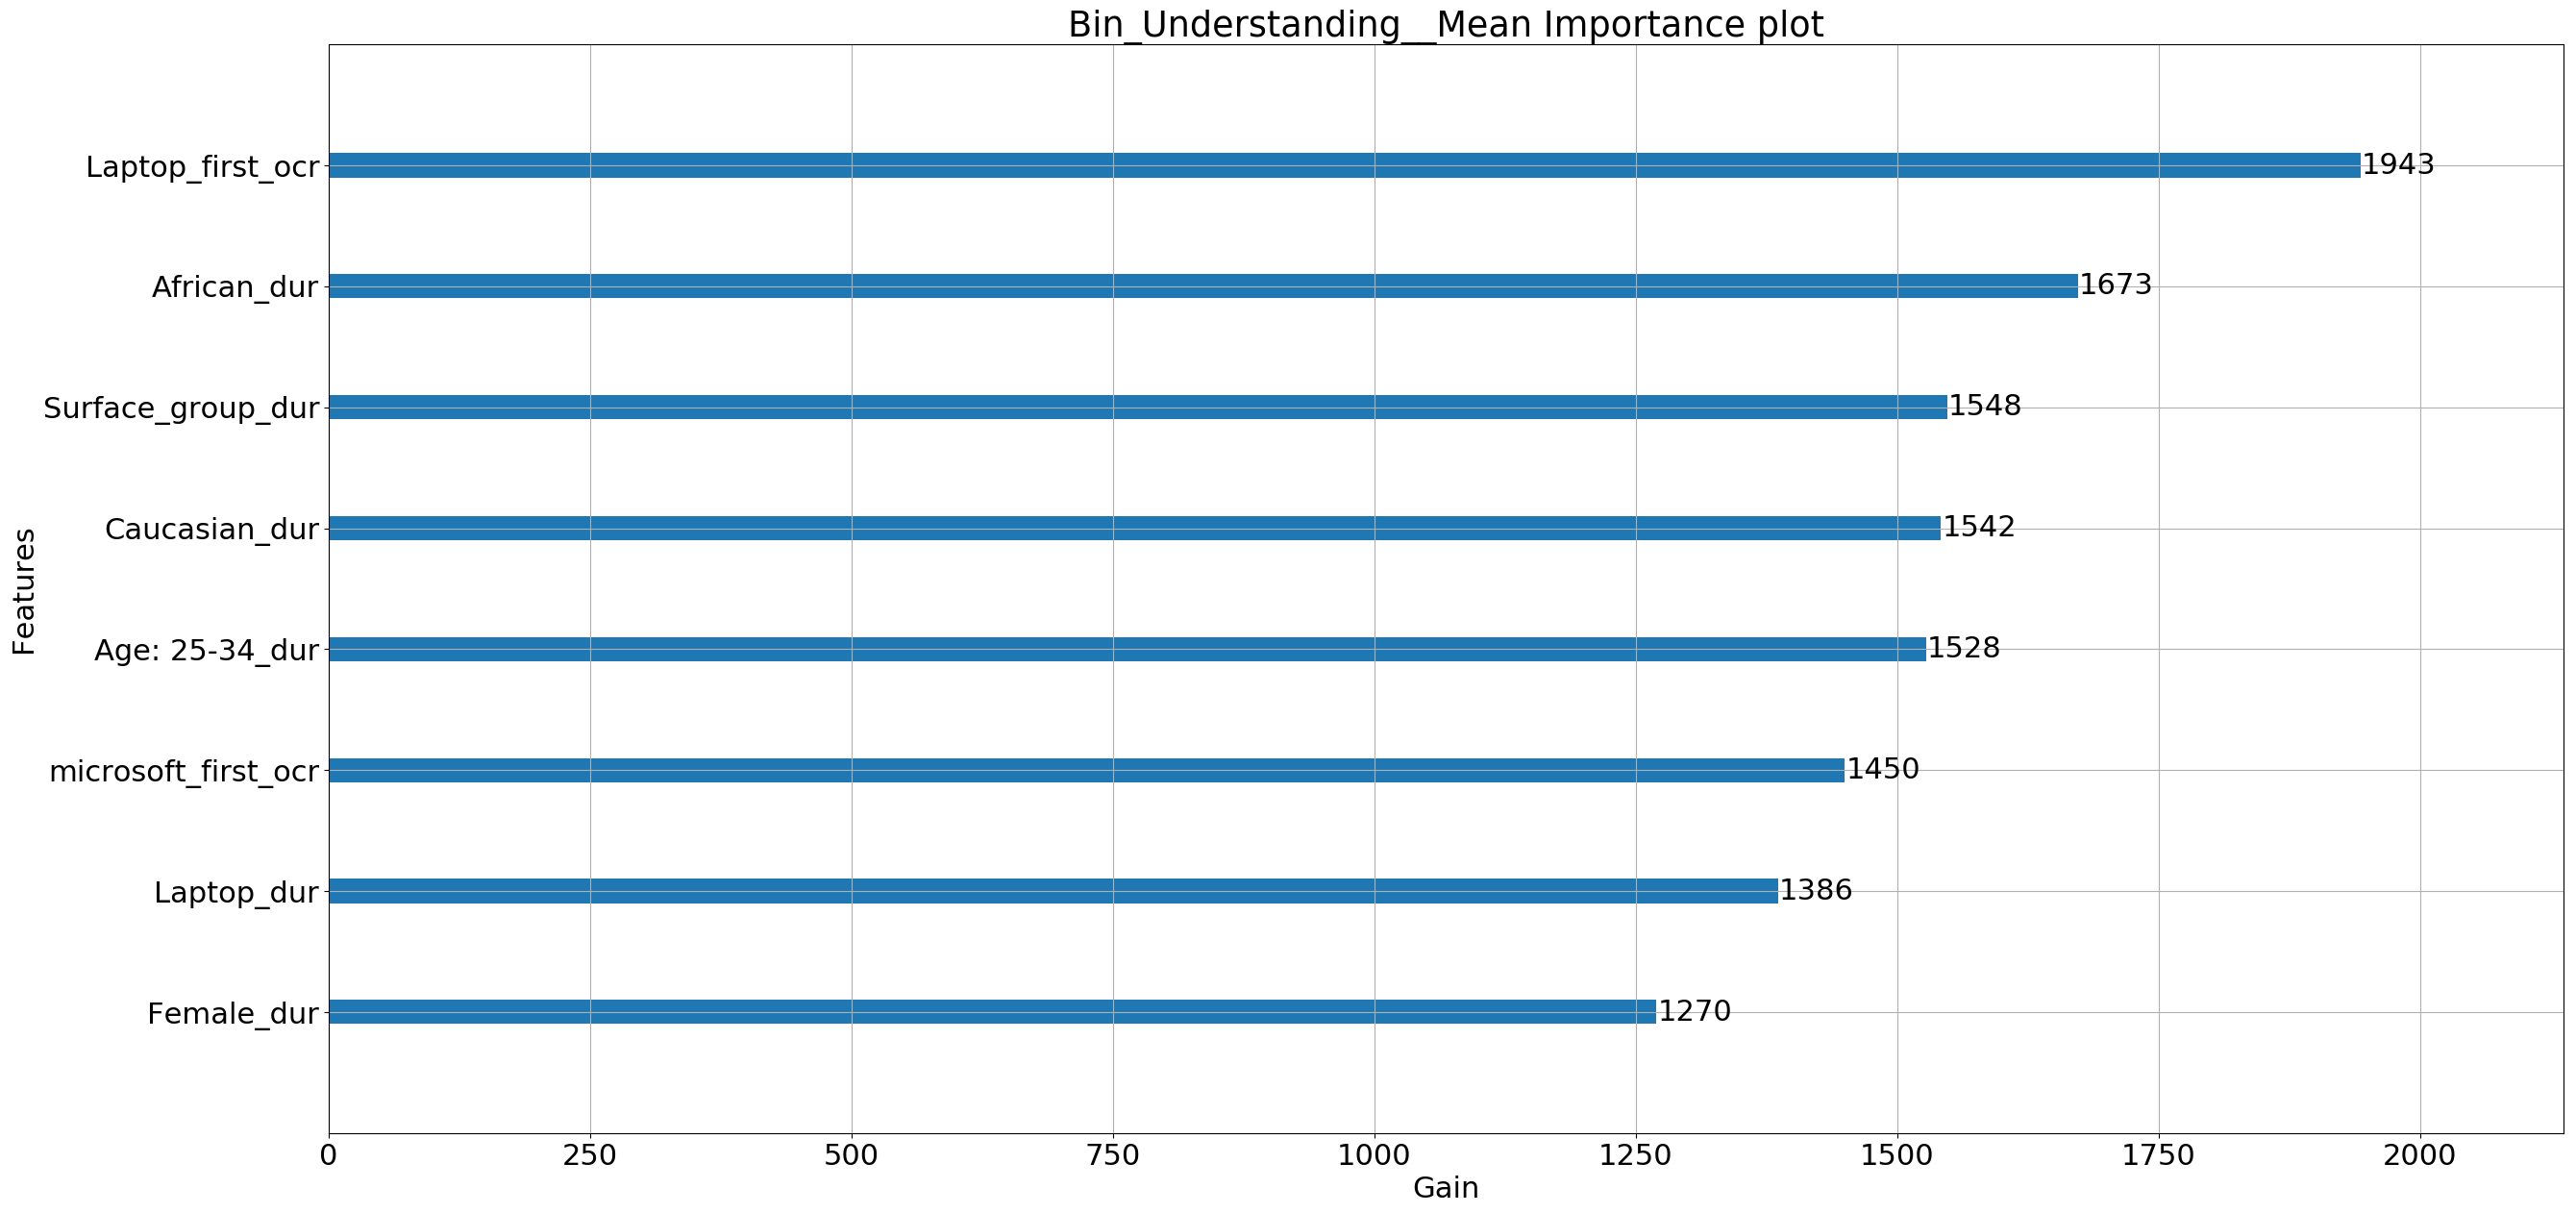

Bin_Relevance_of_Information__Mean
African_dur
Macbook_group_dur
microsoft_last_ocr
Male_dur
Tablet_last_ocr
Tablet_dur
Caucasian_dur
Surface_group_last_ocr
Tablet_first_ocr
microsoft_first_ocr
microsoft_dur
length_of_ad_15
Age: 35-44_dur
Laptop_last_ocr
Tablet_total_ocr
Laptop_dur
Laptop_first_ocr
Laptop_total_ocr
Neutral_dur
Age: 25-34_dur
Surface_group_total_ocr
Eastasian_dur
Surface_group_first_ocr
microsoft_total_ocr
Happiness_dur
Surface_group_dur
Female_dur
Sadness_dur
Lenovo_group_dur
HP_group_dur
Yoga_dur
Windows_dur
ASUS T102_dur
Dell_sub_brand_group_dur


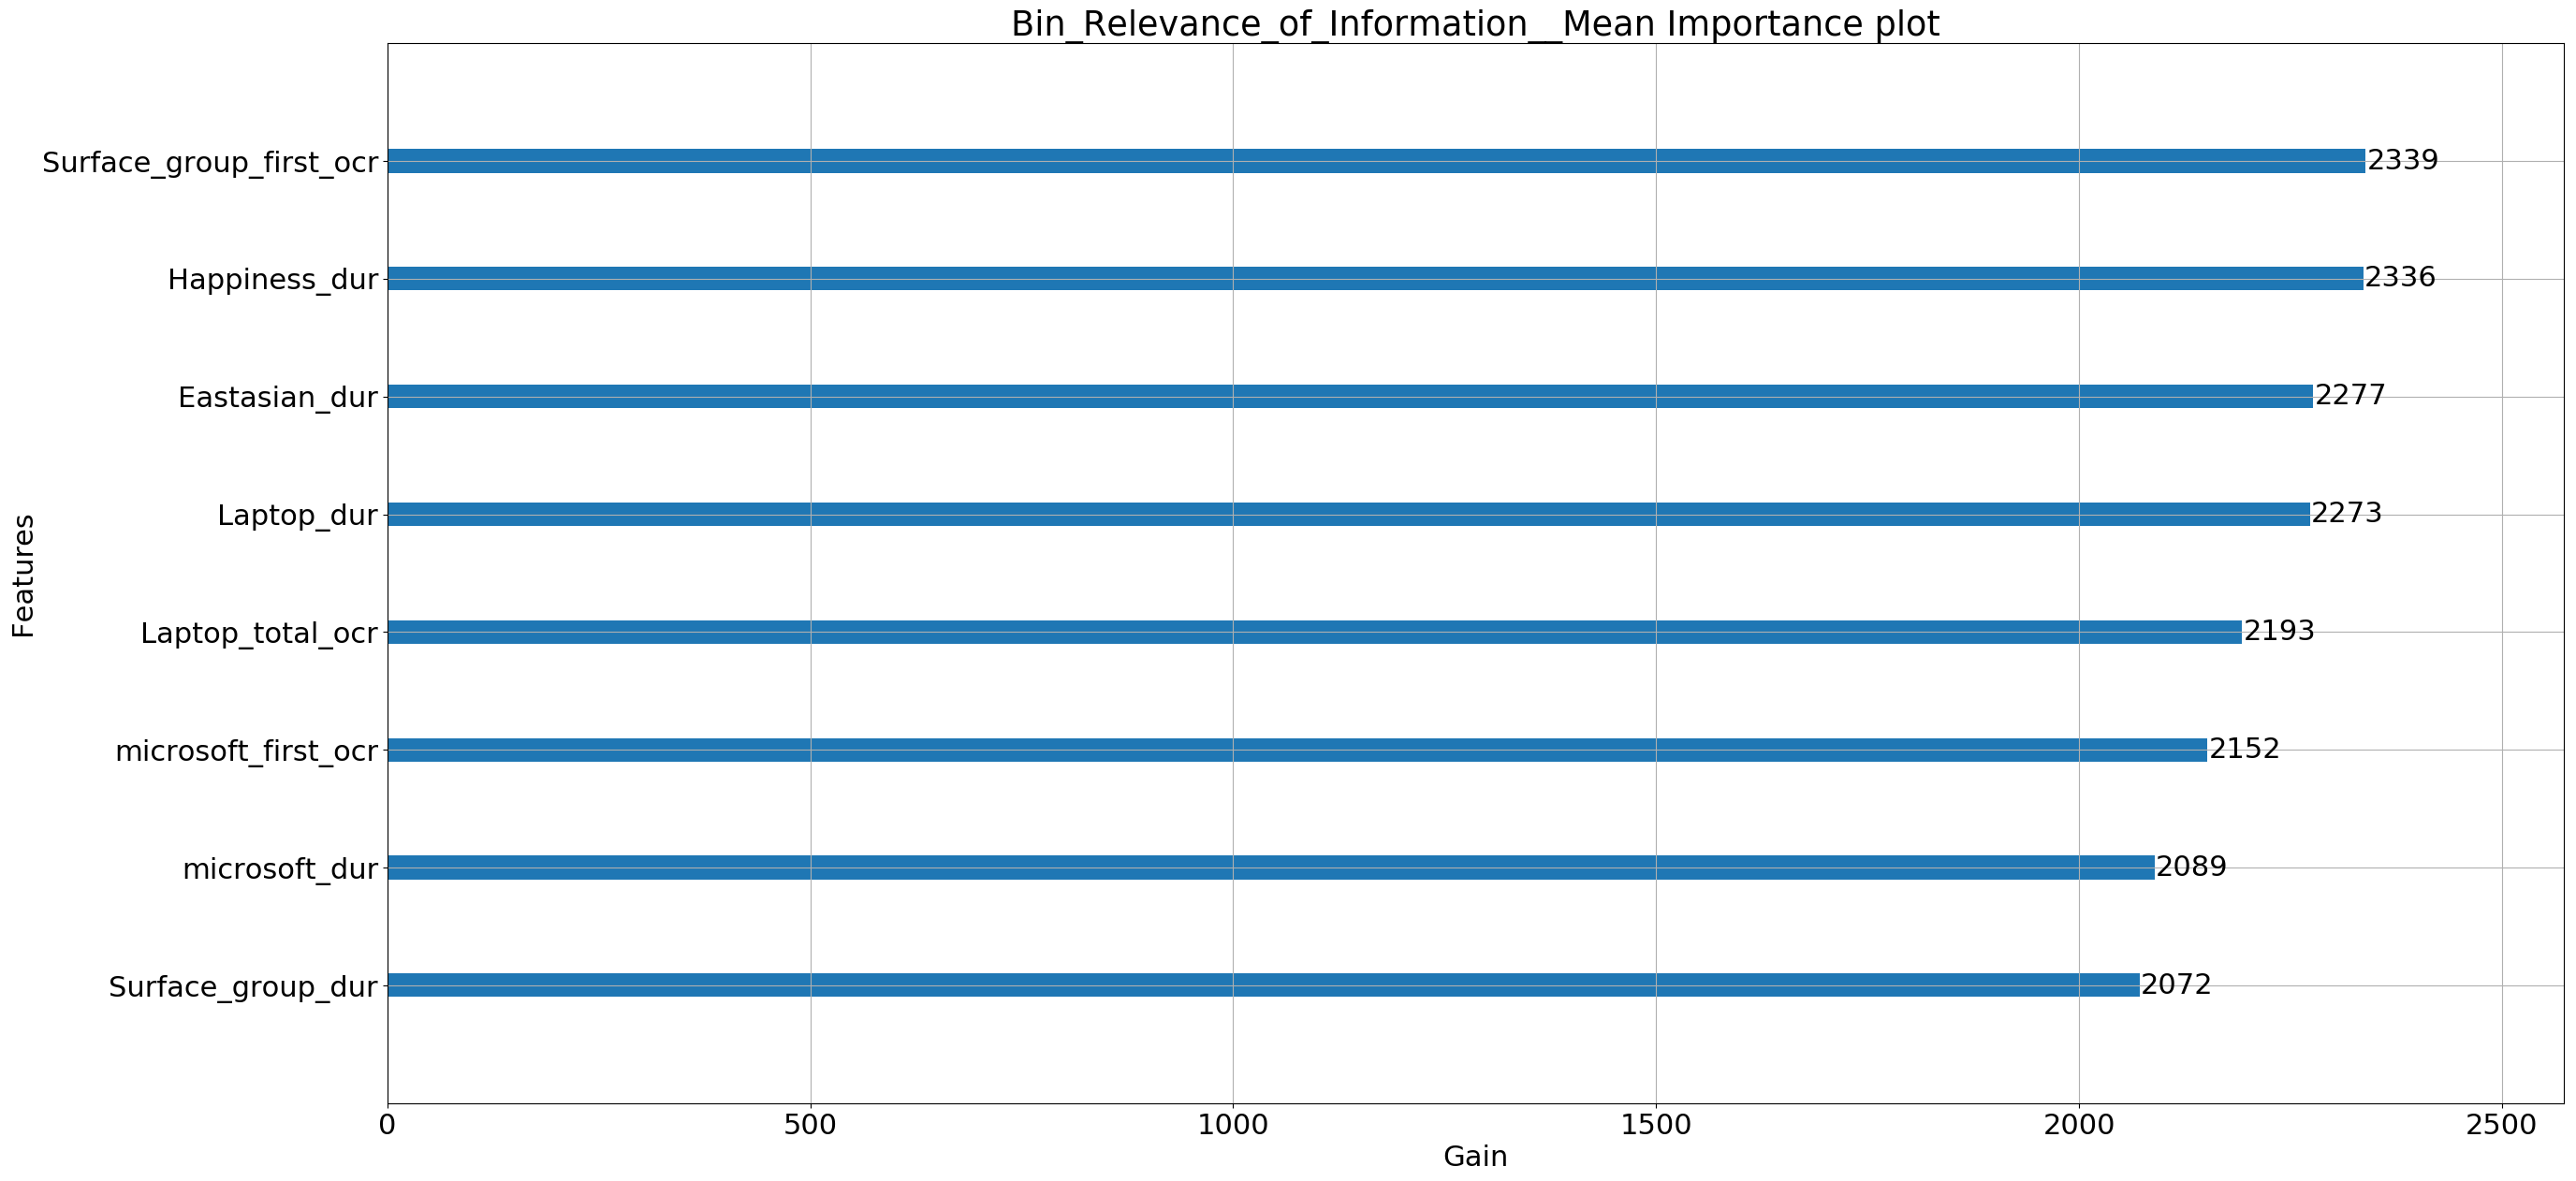

Bin_Credibility_of_Information__Mean
Macbook_group_dur
Laptop_first_ocr
length_of_ad_15
African_dur
Laptop_last_ocr
microsoft_last_ocr
Tablet_last_ocr
Tablet_total_ocr
Tablet_dur
Surface_group_last_ocr
Tablet_first_ocr
Surface_group_total_ocr
Surface_group_first_ocr
microsoft_total_ocr
Eastasian_dur
Laptop_total_ocr
Laptop_dur
Caucasian_dur
Neutral_dur
Male_dur
Age: 35-44_dur
microsoft_first_ocr
Happiness_dur
Surface_group_dur
Sadness_dur
Female_dur
microsoft_dur
Age: 25-34_dur
ASUS T102_dur
HP_group_dur
Lenovo_group_dur
Windows_dur
Yoga_dur
Dell_sub_brand_group_dur


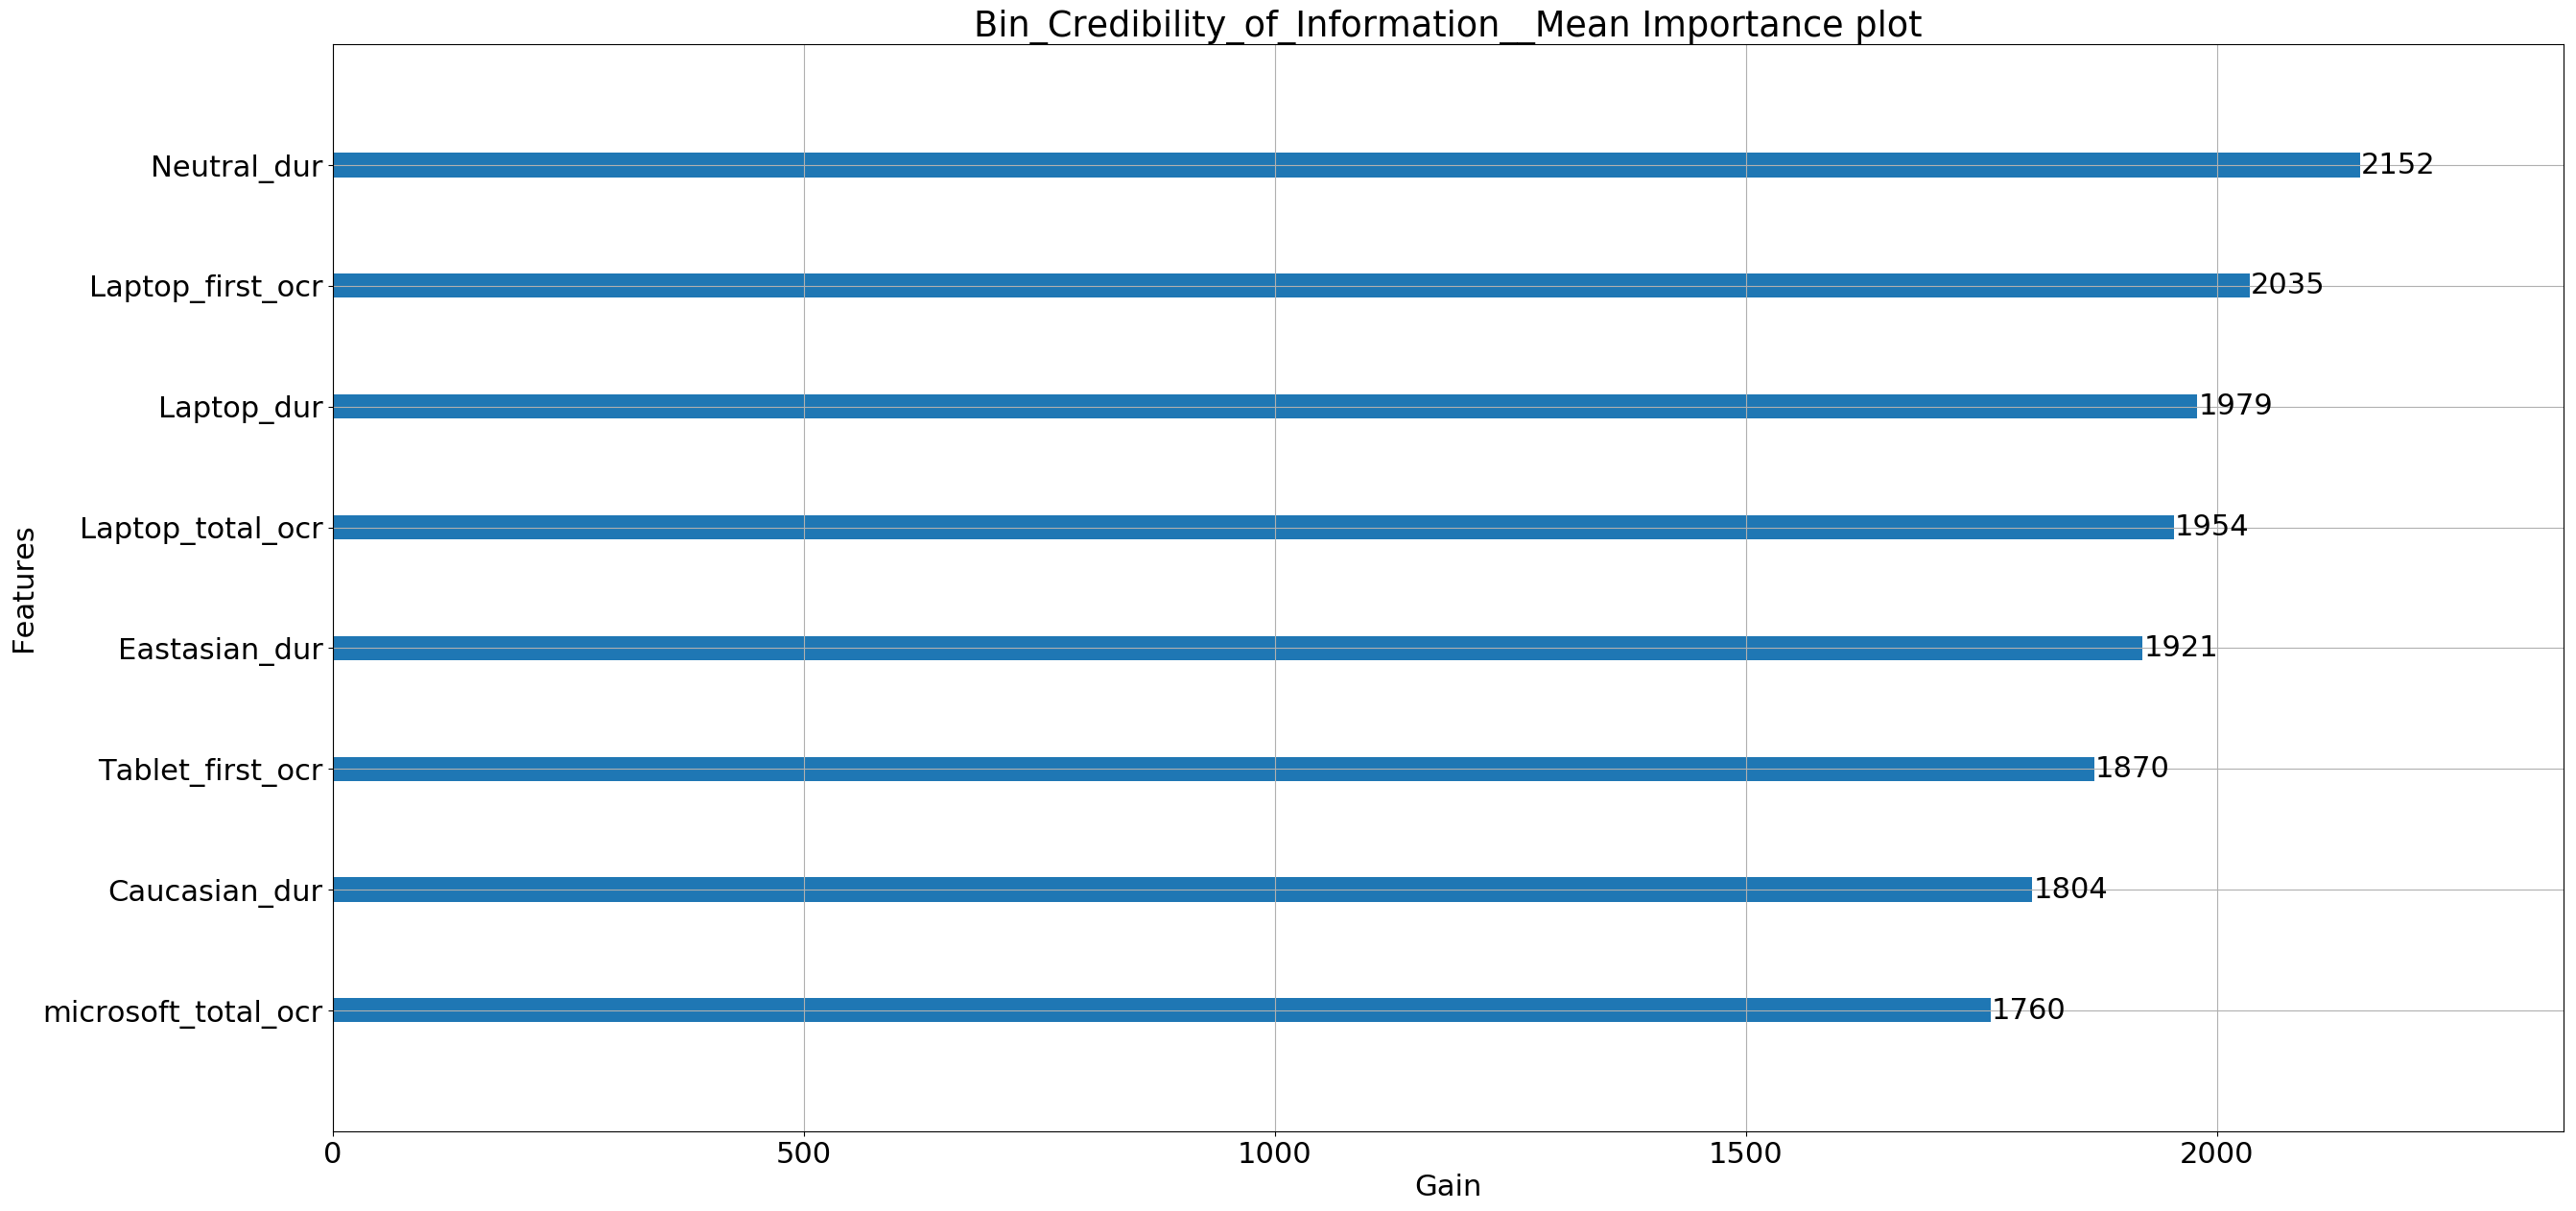

Bin_Brand_Difference__Mean
Macbook_group_dur
length_of_ad_15
microsoft_last_ocr
Surface_group_last_ocr
African_dur
Surface_group_first_ocr
microsoft_first_ocr
Neutral_dur
Laptop_last_ocr
Surface_group_dur
Tablet_last_ocr
Tablet_first_ocr
Happiness_dur
Tablet_dur
Surface_group_total_ocr
Male_dur
Tablet_total_ocr
microsoft_dur
Caucasian_dur
Age: 25-34_dur
Female_dur
Laptop_dur
Laptop_first_ocr
Laptop_total_ocr
Age: 35-44_dur
microsoft_total_ocr
Sadness_dur
Eastasian_dur
HP_group_dur
Yoga_dur
ASUS T102_dur
Windows_dur
Lenovo_group_dur
Dell_sub_brand_group_dur


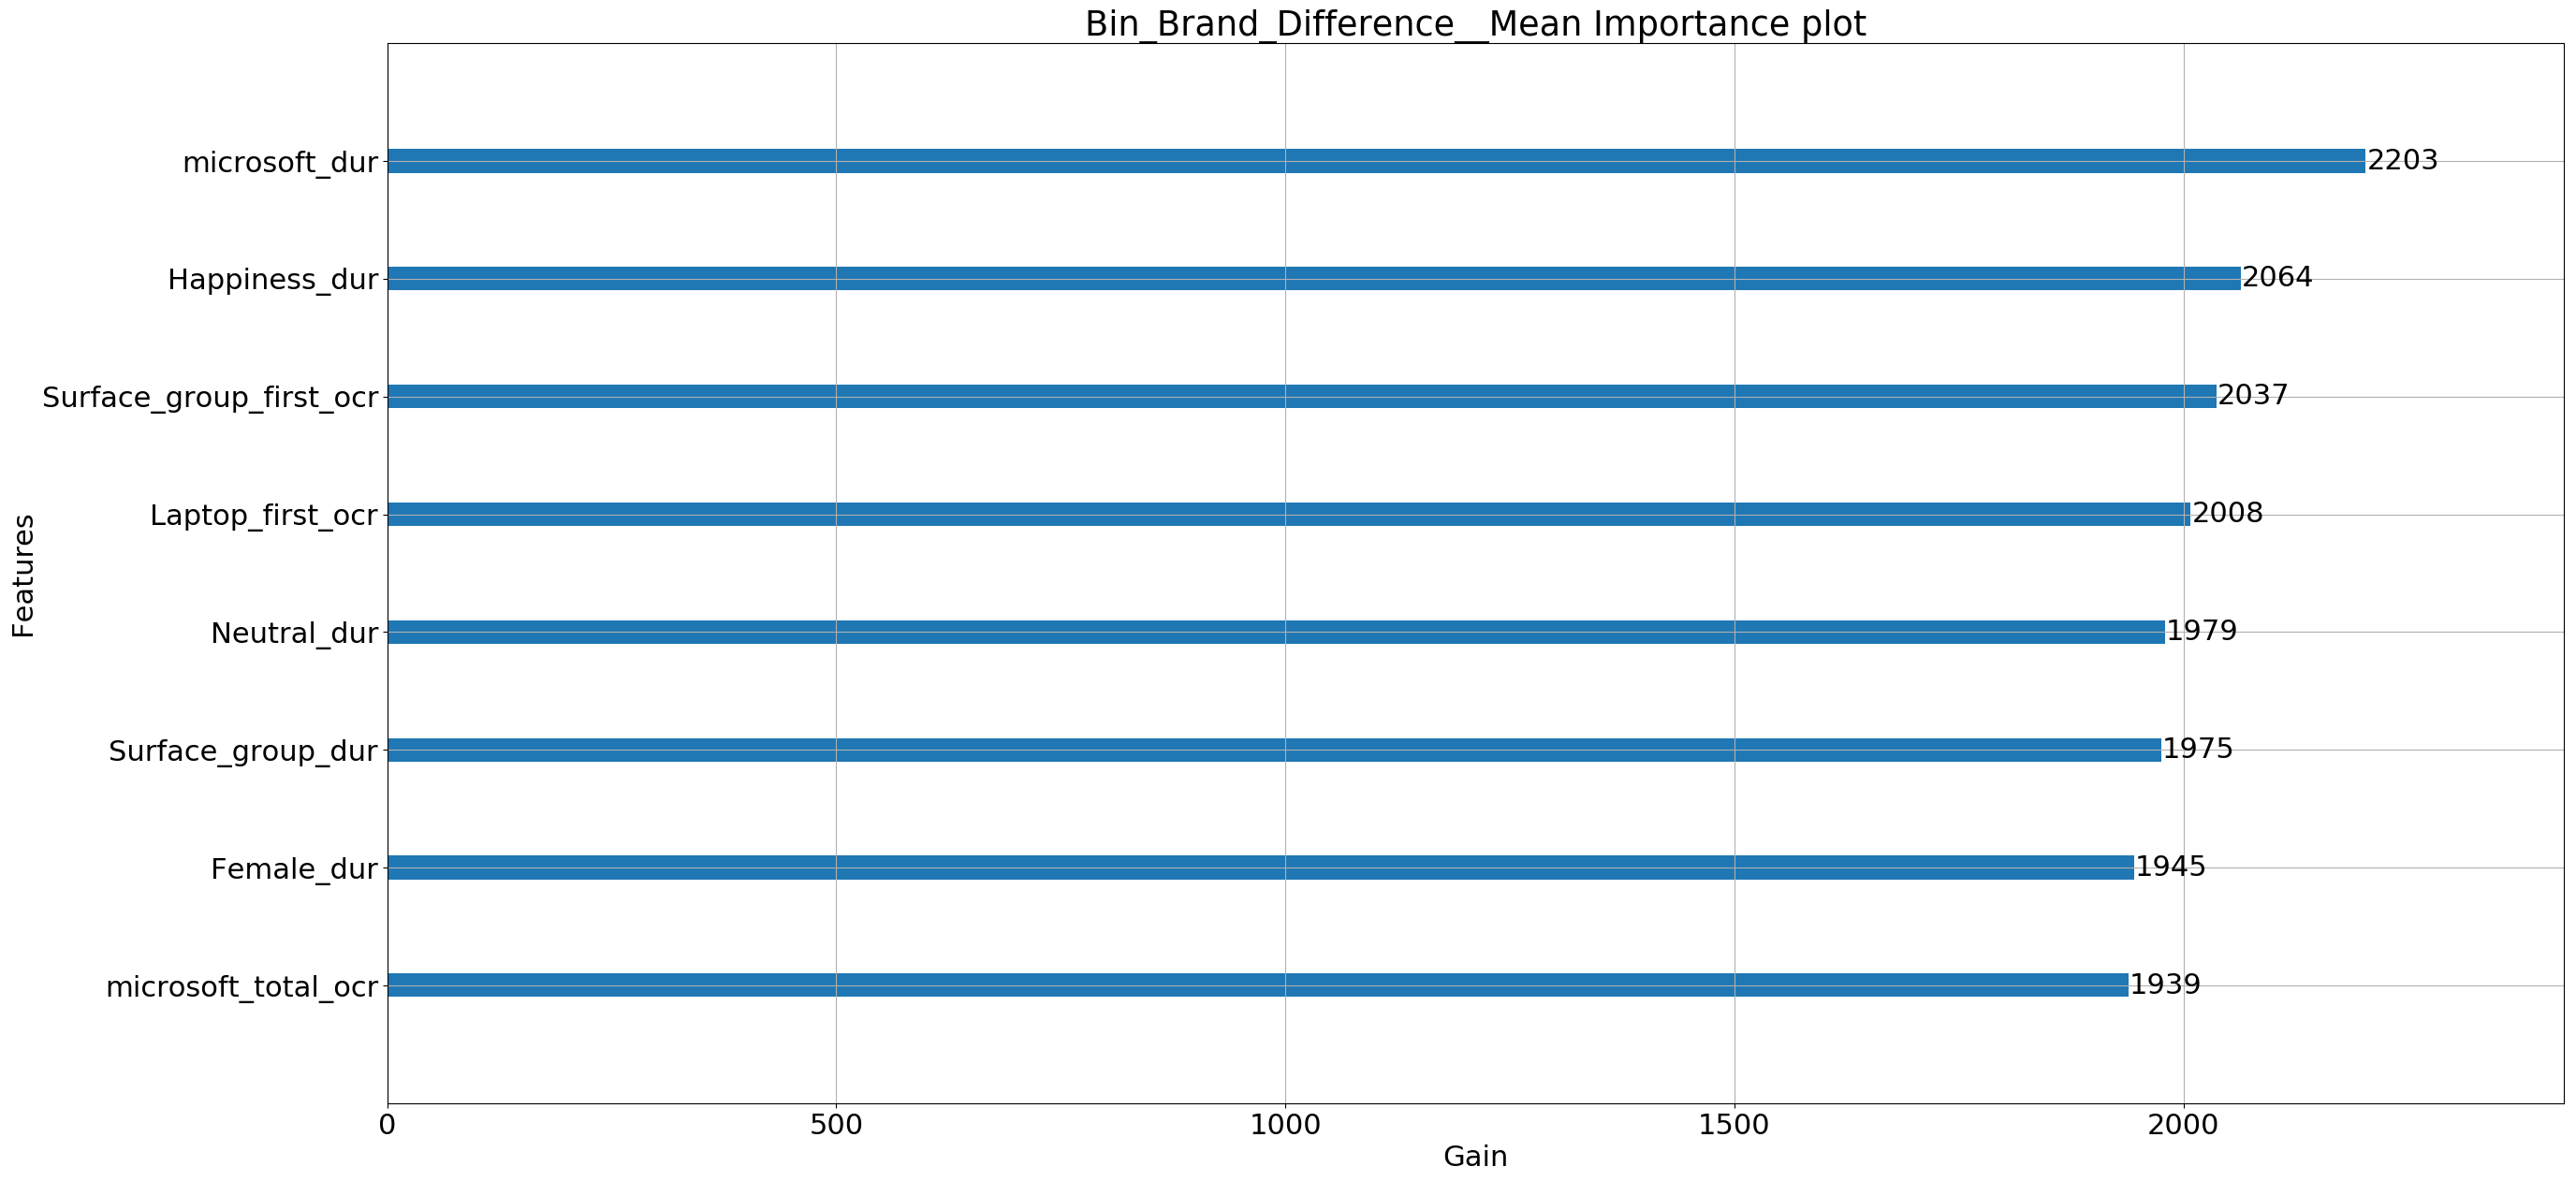

In [32]:
imp_features_xgb = model_xgb.plot_feature_importance(m_xgb,10,Y.columns,x_train[0].columns[:],savefig=False)

In [125]:
from tqdm import tqdm

In [126]:
# shap.initjs()
explainer_xgb=[]
shap_values_xgb=[]
for i in tqdm(range(11)):
    explainer_xgb.append(shap.TreeExplainer(models_xgb_11[i][0]))
    shap_values_xgb.append(explainer_xgb[-1].shap_values(x_train[i]))
    print(i)

  9%|▉         | 1/11 [00:08<01:26,  8.64s/it]

0


 18%|█▊        | 2/11 [00:19<01:22,  9.17s/it]

1


 27%|██▋       | 3/11 [00:30<01:18,  9.77s/it]

2


 36%|███▋      | 4/11 [00:37<01:02,  8.90s/it]

3


 45%|████▌     | 5/11 [00:45<00:52,  8.76s/it]

4


 55%|█████▍    | 6/11 [00:53<00:42,  8.56s/it]

5


 64%|██████▎   | 7/11 [00:58<00:30,  7.59s/it]

6


 73%|███████▎  | 8/11 [01:05<00:21,  7.14s/it]

7


 82%|████████▏ | 9/11 [01:14<00:15,  7.94s/it]

8


 91%|█████████ | 10/11 [01:24<00:08,  8.57s/it]

9


100%|██████████| 11/11 [01:33<00:00,  8.73s/it]

10


In [128]:
import matplotlib.pyplot as plt

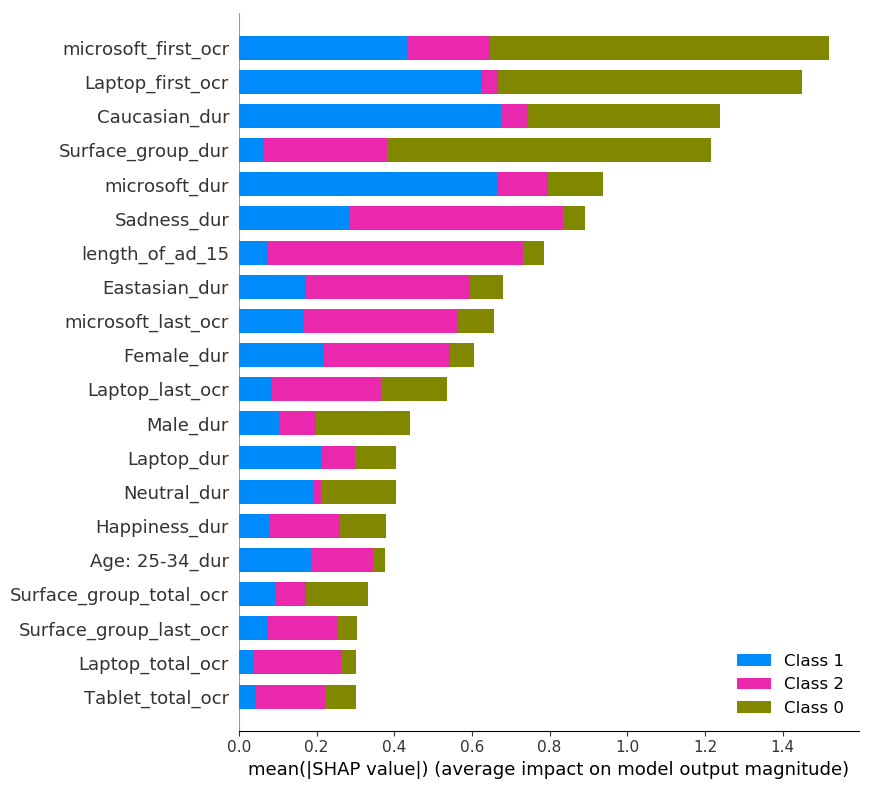

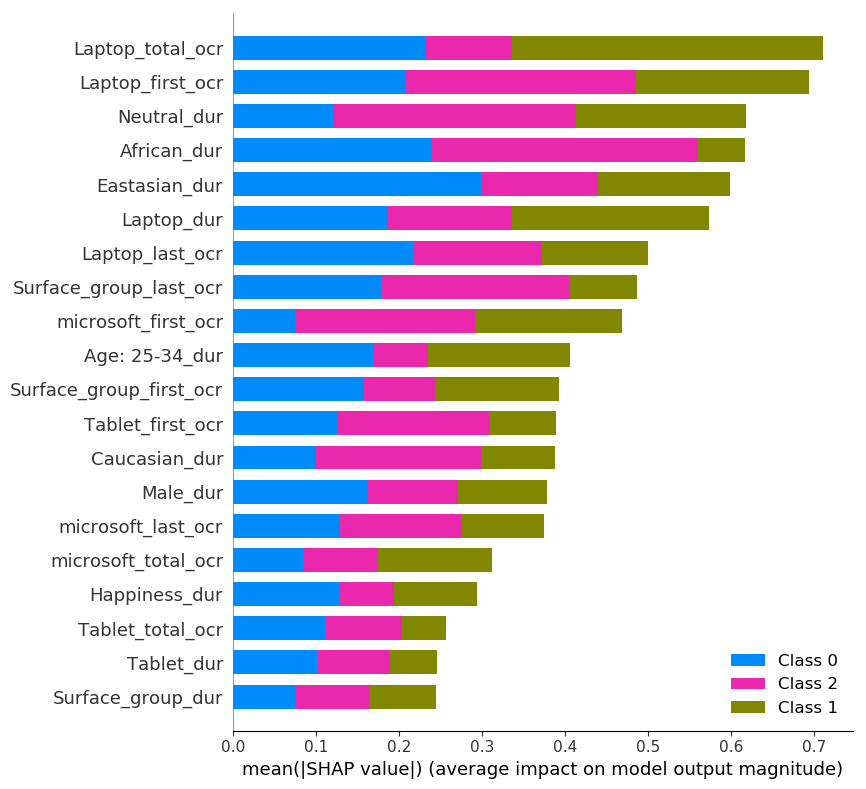

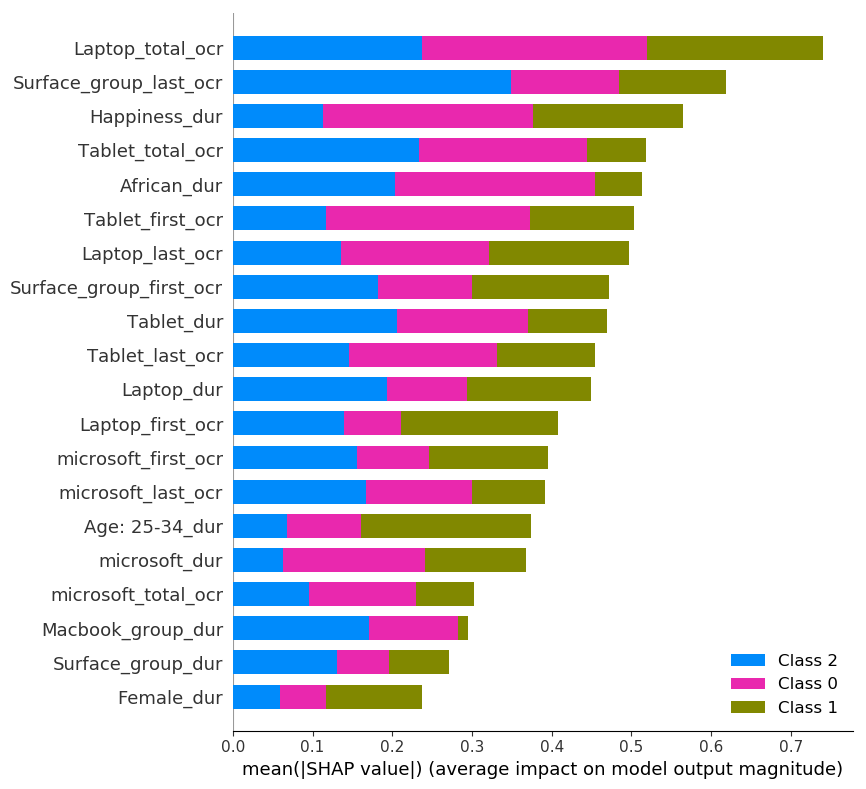

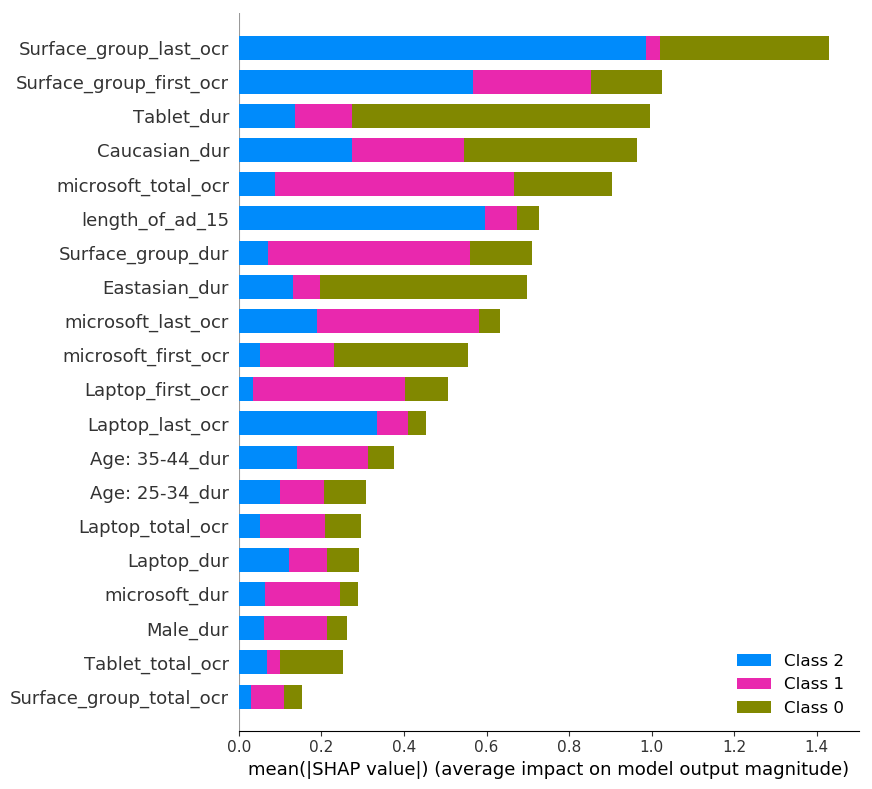

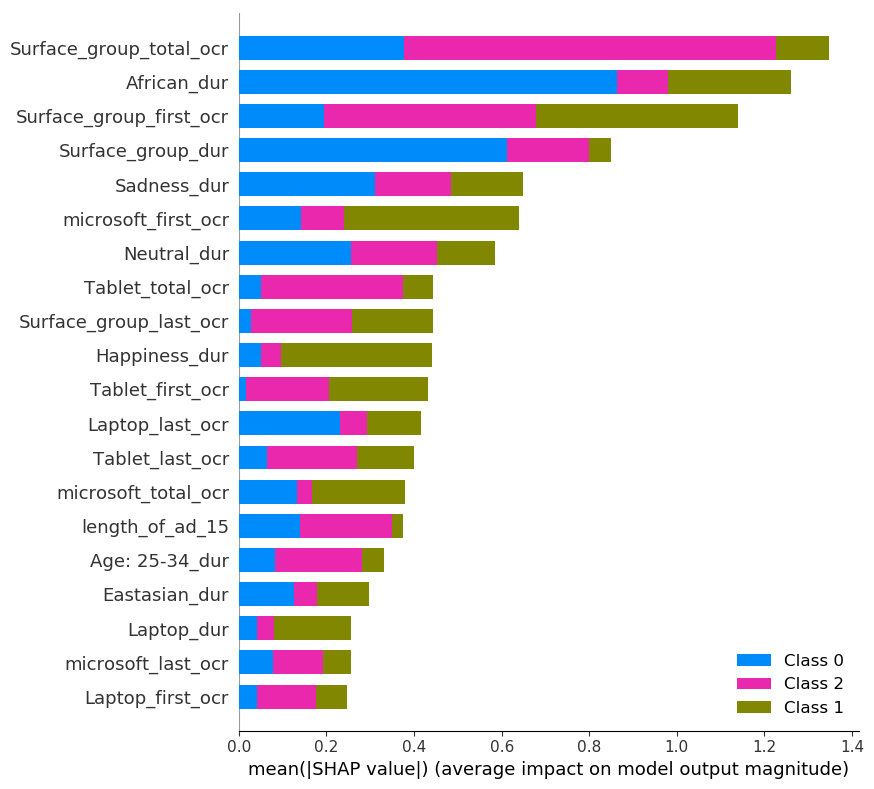

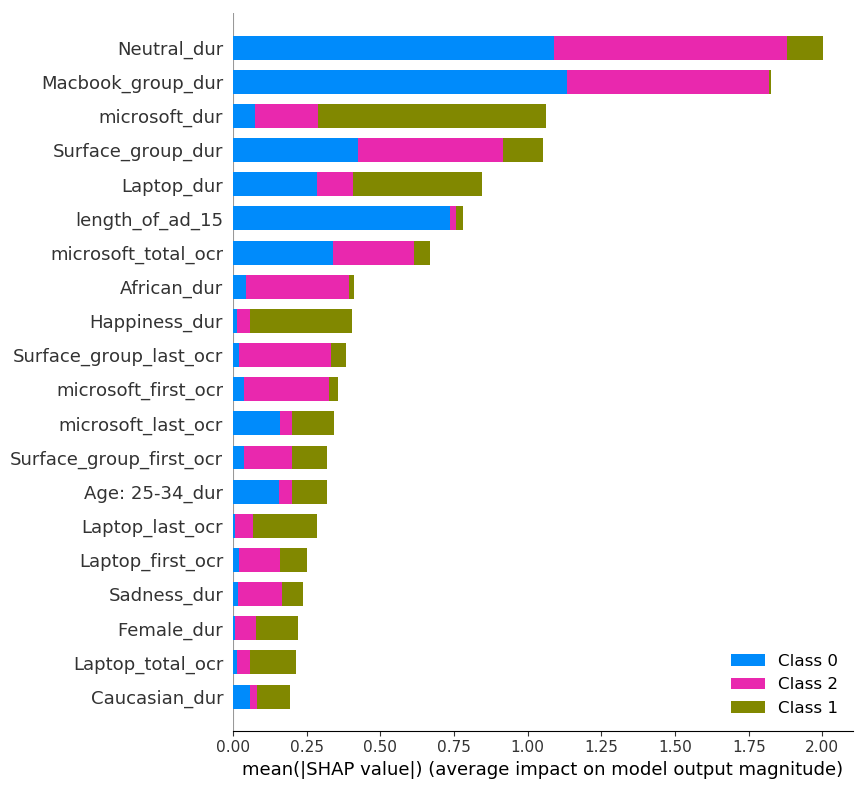

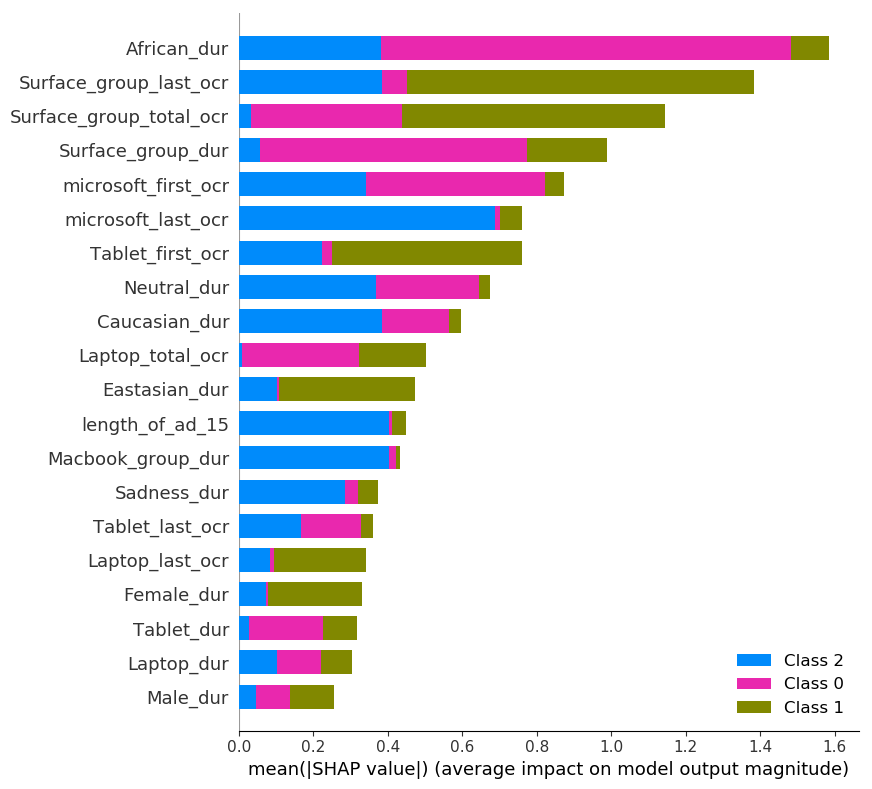

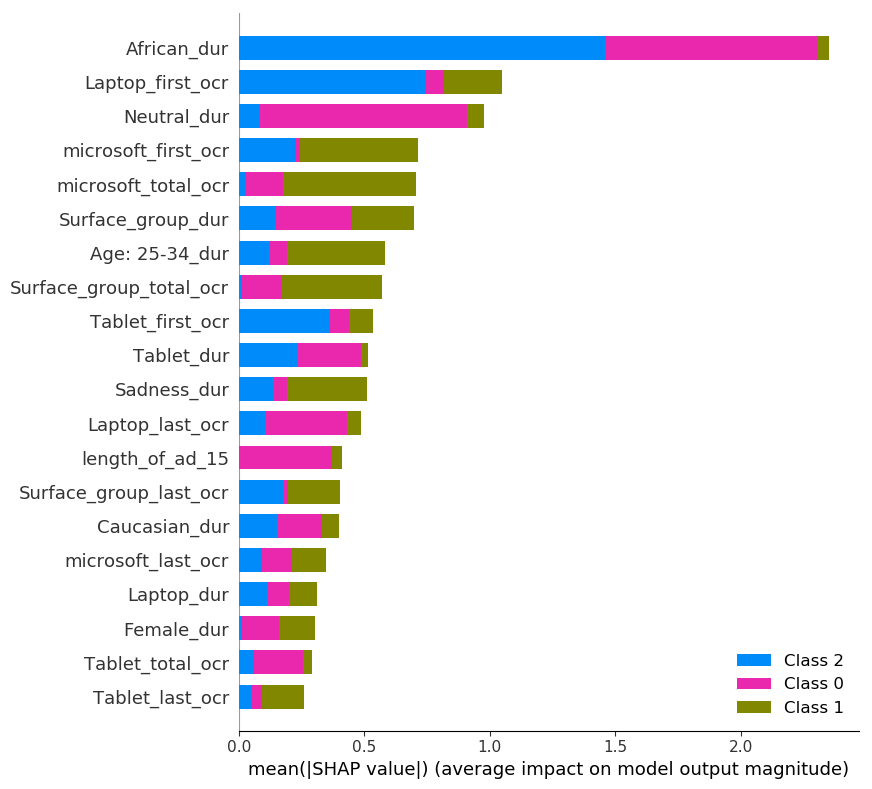

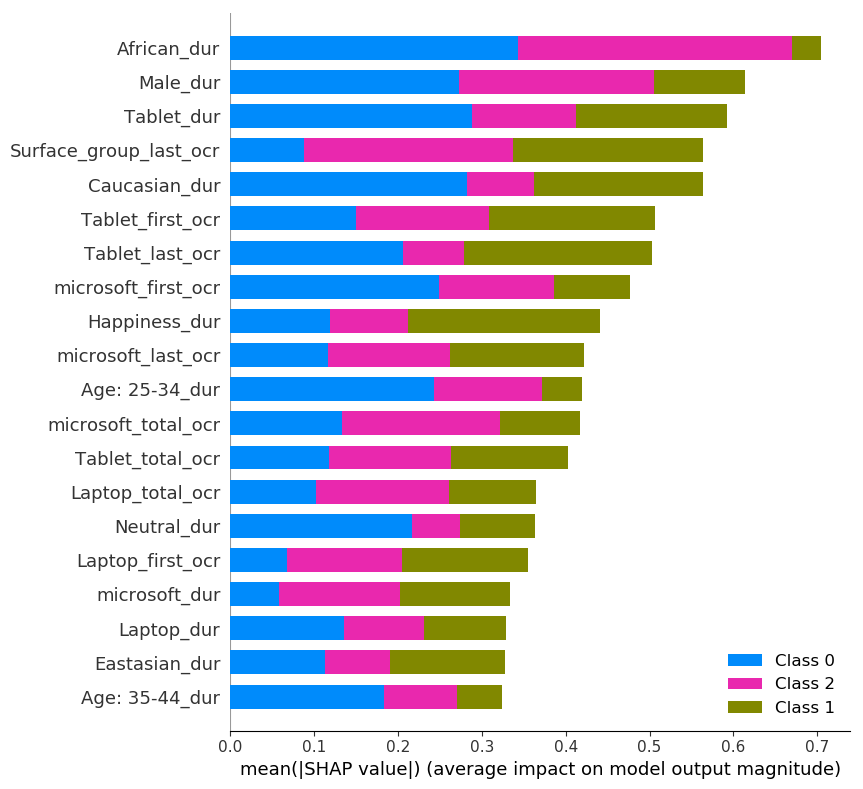

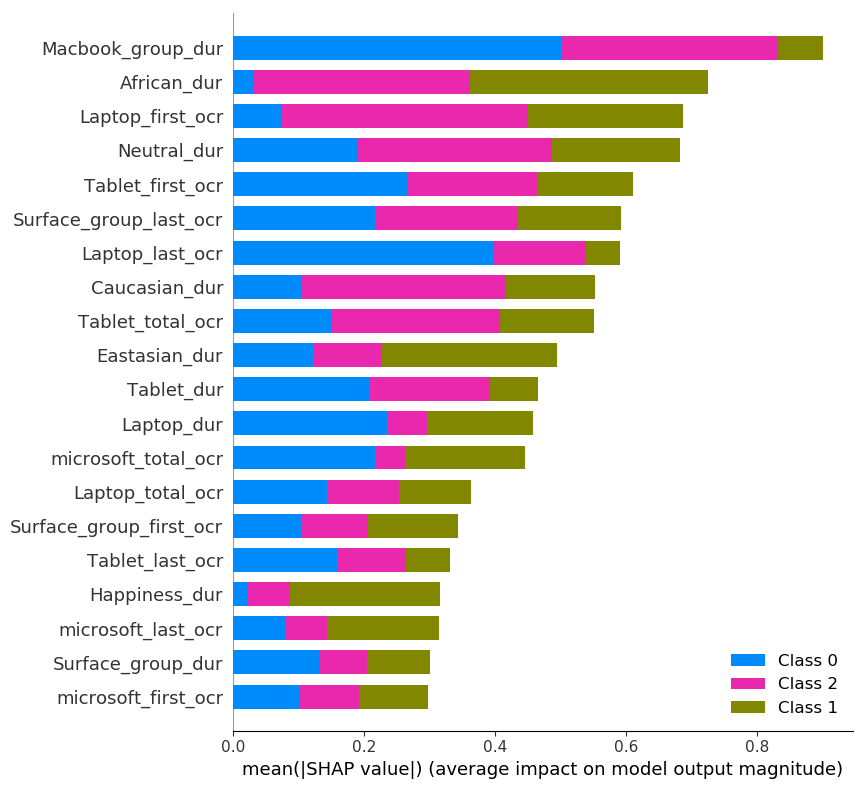

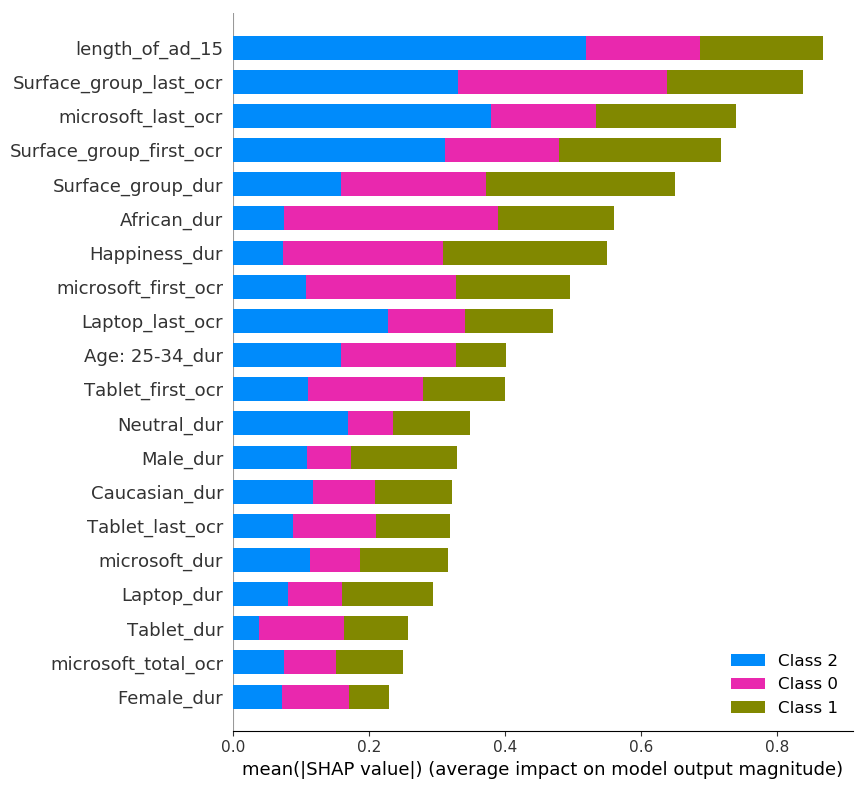

In [129]:
for i,col in enumerate(Y.columns):
    plt.figure()
    shap.summary_plot(shap_values_xgb[i],x_train[i],plot_type="dot",show=False)
    plt.savefig('./bin_shap_xgb_surface/'+col,bbox_inches='tight')
    

In [130]:
x_train[i].columns

Index(['African_dur', 'Caucasian_dur', 'Eastasian_dur', 'Happiness_dur',
       'Neutral_dur', 'Sadness_dur', 'length_of_ad_15', 'Female_dur',
       'Male_dur', 'Age: 25-34_dur', 'Age: 35-44_dur', 'microsoft_dur',
       'microsoft_first_ocr', 'microsoft_last_ocr', 'microsoft_total_ocr',
       'ASUS T102_dur', 'Dell_sub_brand_group_dur', 'HP_group_dur',
       'Lenovo_group_dur', 'Macbook_group_dur', 'Surface_group_dur',
       'Windows_dur', 'Yoga_dur', 'Surface_group_first_ocr',
       'Surface_group_last_ocr', 'Surface_group_total_ocr', 'Laptop_dur',
       'Laptop_first_ocr', 'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur',
       'Tablet_first_ocr', 'Tablet_last_ocr', 'Tablet_total_ocr'],
      dtype='object')

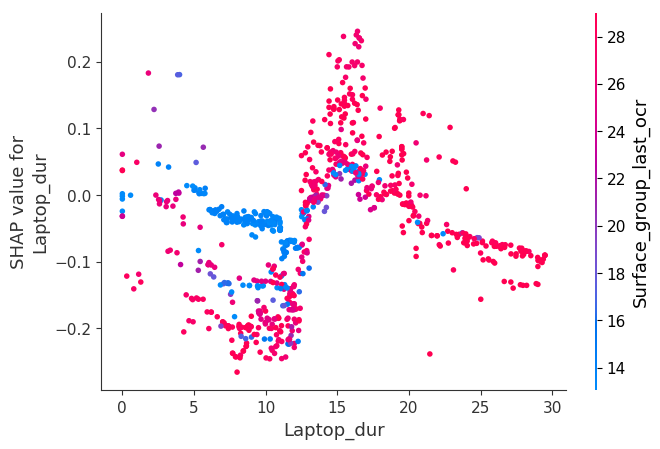

In [151]:
shap.dependence_plot('Laptop_dur',shap_values_xgb[0][2],x_train[0])

## Decision Tree And Plotting

In [19]:
model_dt = Model('DT','class')

In [22]:
print("------------------------ 11 Models DT Training ----------------------------\n")
models_dt_11=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_dt_11.append(model_dt.train(x_train[i],y_train[i],x_test[i],y_test[i],metrics='accuracy',plot_error=False))
    model_dt.plot_tree(savefig=True,folder='./bin_plots/',class_names=['Low','Medium','High'])    

------------------------ 11 Models XGB Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding
For training set
accuracy_score: 0.877351
For test set
accuracy_score: 0.905556




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean
For training set
accuracy_score: 0.868834
For test set
accuracy_score: 0.936111




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean
For training set
accuracy_score: 0.857198
For test set
accuracy_score: 0.866667




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean
For training set
accuracy_score: 0.864168
For test set
accuracy_score: 0.869444




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean
For training set
accuracy_score: 0.851217
For test set
accuracy_score: 0.852778




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean
For training set
accuracy_score: 0.853680
For test set
accuracy_score: 0.872222




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean
For training set
accuracy_score: 0.877438
For test set
accuracy_score: 0.880556




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean
For training set
accuracy_score: 0.891612
For test set
accuracy_score: 0.961111




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean
For training set
accuracy_score: 0.828581
For test set
accuracy_score: 0.869444




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean
For training set
accuracy_score: 0.808398
For test set
accuracy_score: 0.872222




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean
For training set
accuracy_score: 0.823792
For test set
accuracy_score: 0.847222




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [21]:
model_dt.plot_tree(savefig=True,folder='./bin_plots/',class_names=['Low','Medium','High'])

In [60]:
how to use text to make graphs usX_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')

## Accuracies

In [197]:
# imp_features_rf = imp_features[:,:10]

In [199]:
# imp_features_xgb = imp_features_xgb[:,:10]

In [33]:
feature_set=[]
for i in range(11):
    feature_set.append(set(np.hstack((imp_features[:,:10],imp_features_xgb[:,:10],imp_features_shap))[i]))

In [34]:
feature_set[0]

{'Caucasian_dur',
 'Female_dur',
 'Laptop_first_ocr',
 'Laptop_last_ocr',
 'Sadness_dur',
 'Surface_group_dur',
 'Surface_group_last_ocr',
 'Surface_group_total_ocr',
 'length_of_ad_15',
 'microsoft_dur',
 'microsoft_first_ocr',
 'microsoft_last_ocr'}

In [51]:
X_res_set=[]
Y_res_set=[]
x_train_set,y_train_set,x_test_set,y_test_set=[],[],[],[]
for i,target in enumerate(Y.columns.values):
    feature_set[i].add('Video Name')
    x,y = model.preprocessing.overSampling(X[feature_set[i]],Y[[target]],col_as_label =target ,each_Col=False,rmCols=['Video Name',target],size=400,random_state=12,sampling_dict={1:400,2:400,3:400},neigh=3)
    X_res_set.append(x)
    Y_res_set.append(y)
    x_tr,x_t,y_tr,y_t = train_test_split(X_res_set[-1],Y_res_set[-1],random_state = 123,test_size=0.3)
    x_train_set.append(x_tr),x_test_set.append(x_t),y_train_set.append(y_tr),y_test_set.append(y_t)

In [52]:
x_train_set[0].shape

(840, 12)

In [53]:
model_rf_set = Model('ranf','class')
print("------------------------ 11 Models RF Training ----------------------------\n")
models_11_set=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_11_set.append(model_rf_set.train(x_train_set[i],y_train_set[i],x_test_set[i],y_test_set[i],metrics='accuracy',plot_error=False))

------------------------ 11 Models RF Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.991659
For test set
accuracy_score: 0.972222


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.994040
For test set
accuracy_score: 0.997222


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.988130
For test set
accuracy_score: 1.000000


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.991666
For test set
accuracy_score: 0.997222


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.990497
For test set
accuracy_score: 0.994444


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.994069
For test set
accuracy_score: 0.997222


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.988087
For test set
accuracy_score: 0.980556


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.998817
For test set
accuracy_score: 1.000000


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.994048
For test set
accuracy_score: 0.997222


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
accuracy_score: 0.989285
For test set
accuracy_score: 0.994444


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
accuracy_score: 0.988095
For test set
accuracy_score: 0.991667




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


In [54]:
m_rf_set = [m[0] for m in models_11_set]
model_rf_set.evaluate(x_test_set,y_test_set,m_rf_set,metrics='accuracy')

Bin_Unaided_Branding
[1.   0.94 0.97] 

Bin_Brand_Cues__Mean
[0.99 1.   1.  ] 

Bin_Aided_Branding__Mean
[1. 1. 1.] 

Bin_Active_Involvement__Mean
[1.   1.   0.99] 

Bin_New_Information__Mean
[0.99 1.   0.99] 

Bin_Enjoyment__Mean


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[1.   0.99 1.  ] 

Bin_Brand_Appeal__Mean
[0.99 0.96 0.98] 

Bin_Understanding__Mean
[1. 1. 1.] 

Bin_Relevance_of_Information__Mean
[1.   0.99 1.  ] 

Bin_Credibility_of_Information__Mean
[0.99 1.   0.99] 

Bin_Brand_Difference__Mean
[1.   0.99 0.98] 



[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


Bin_Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
microsoft_last_ocr
Surface_group_dur
length_of_ad_15
Caucasian_dur
Surface_group_total_ocr
Female_dur
microsoft_dur
Sadness_dur
Laptop_last_ocr
Surface_group_last_ocr


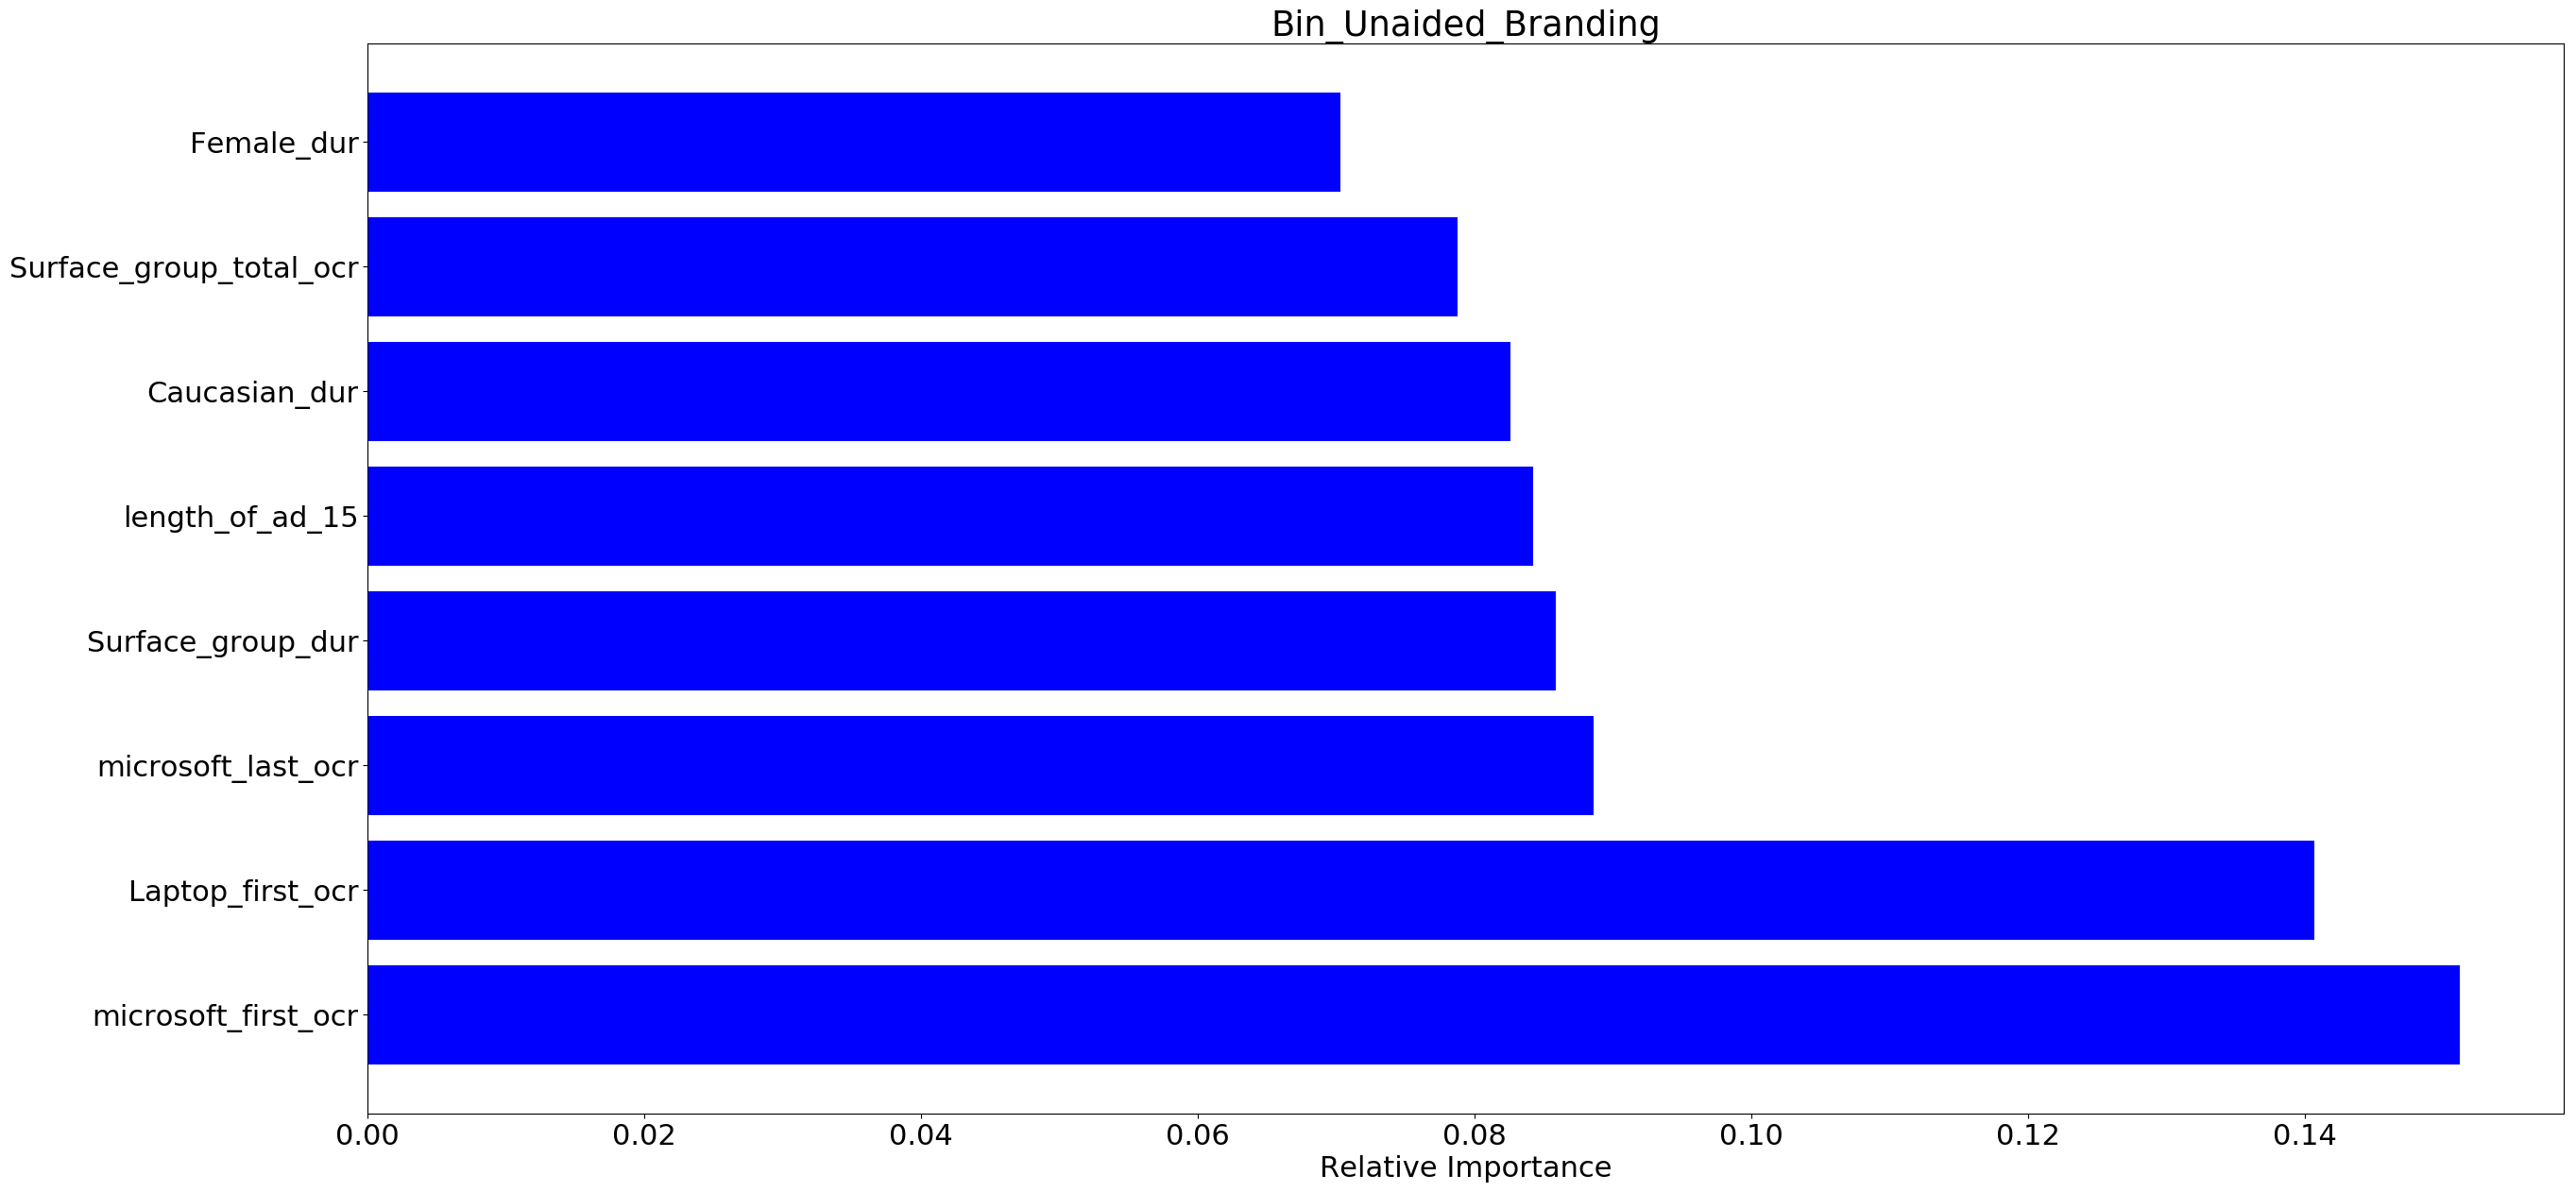

Bin_Brand_Cues__Mean
Feature ranking:
Laptop_total_ocr
microsoft_first_ocr
Laptop_first_ocr
Eastasian_dur
Surface_group_last_ocr
Surface_group_first_ocr
Caucasian_dur
Neutral_dur
African_dur
Laptop_dur
Laptop_last_ocr
microsoft_last_ocr
Macbook_group_dur


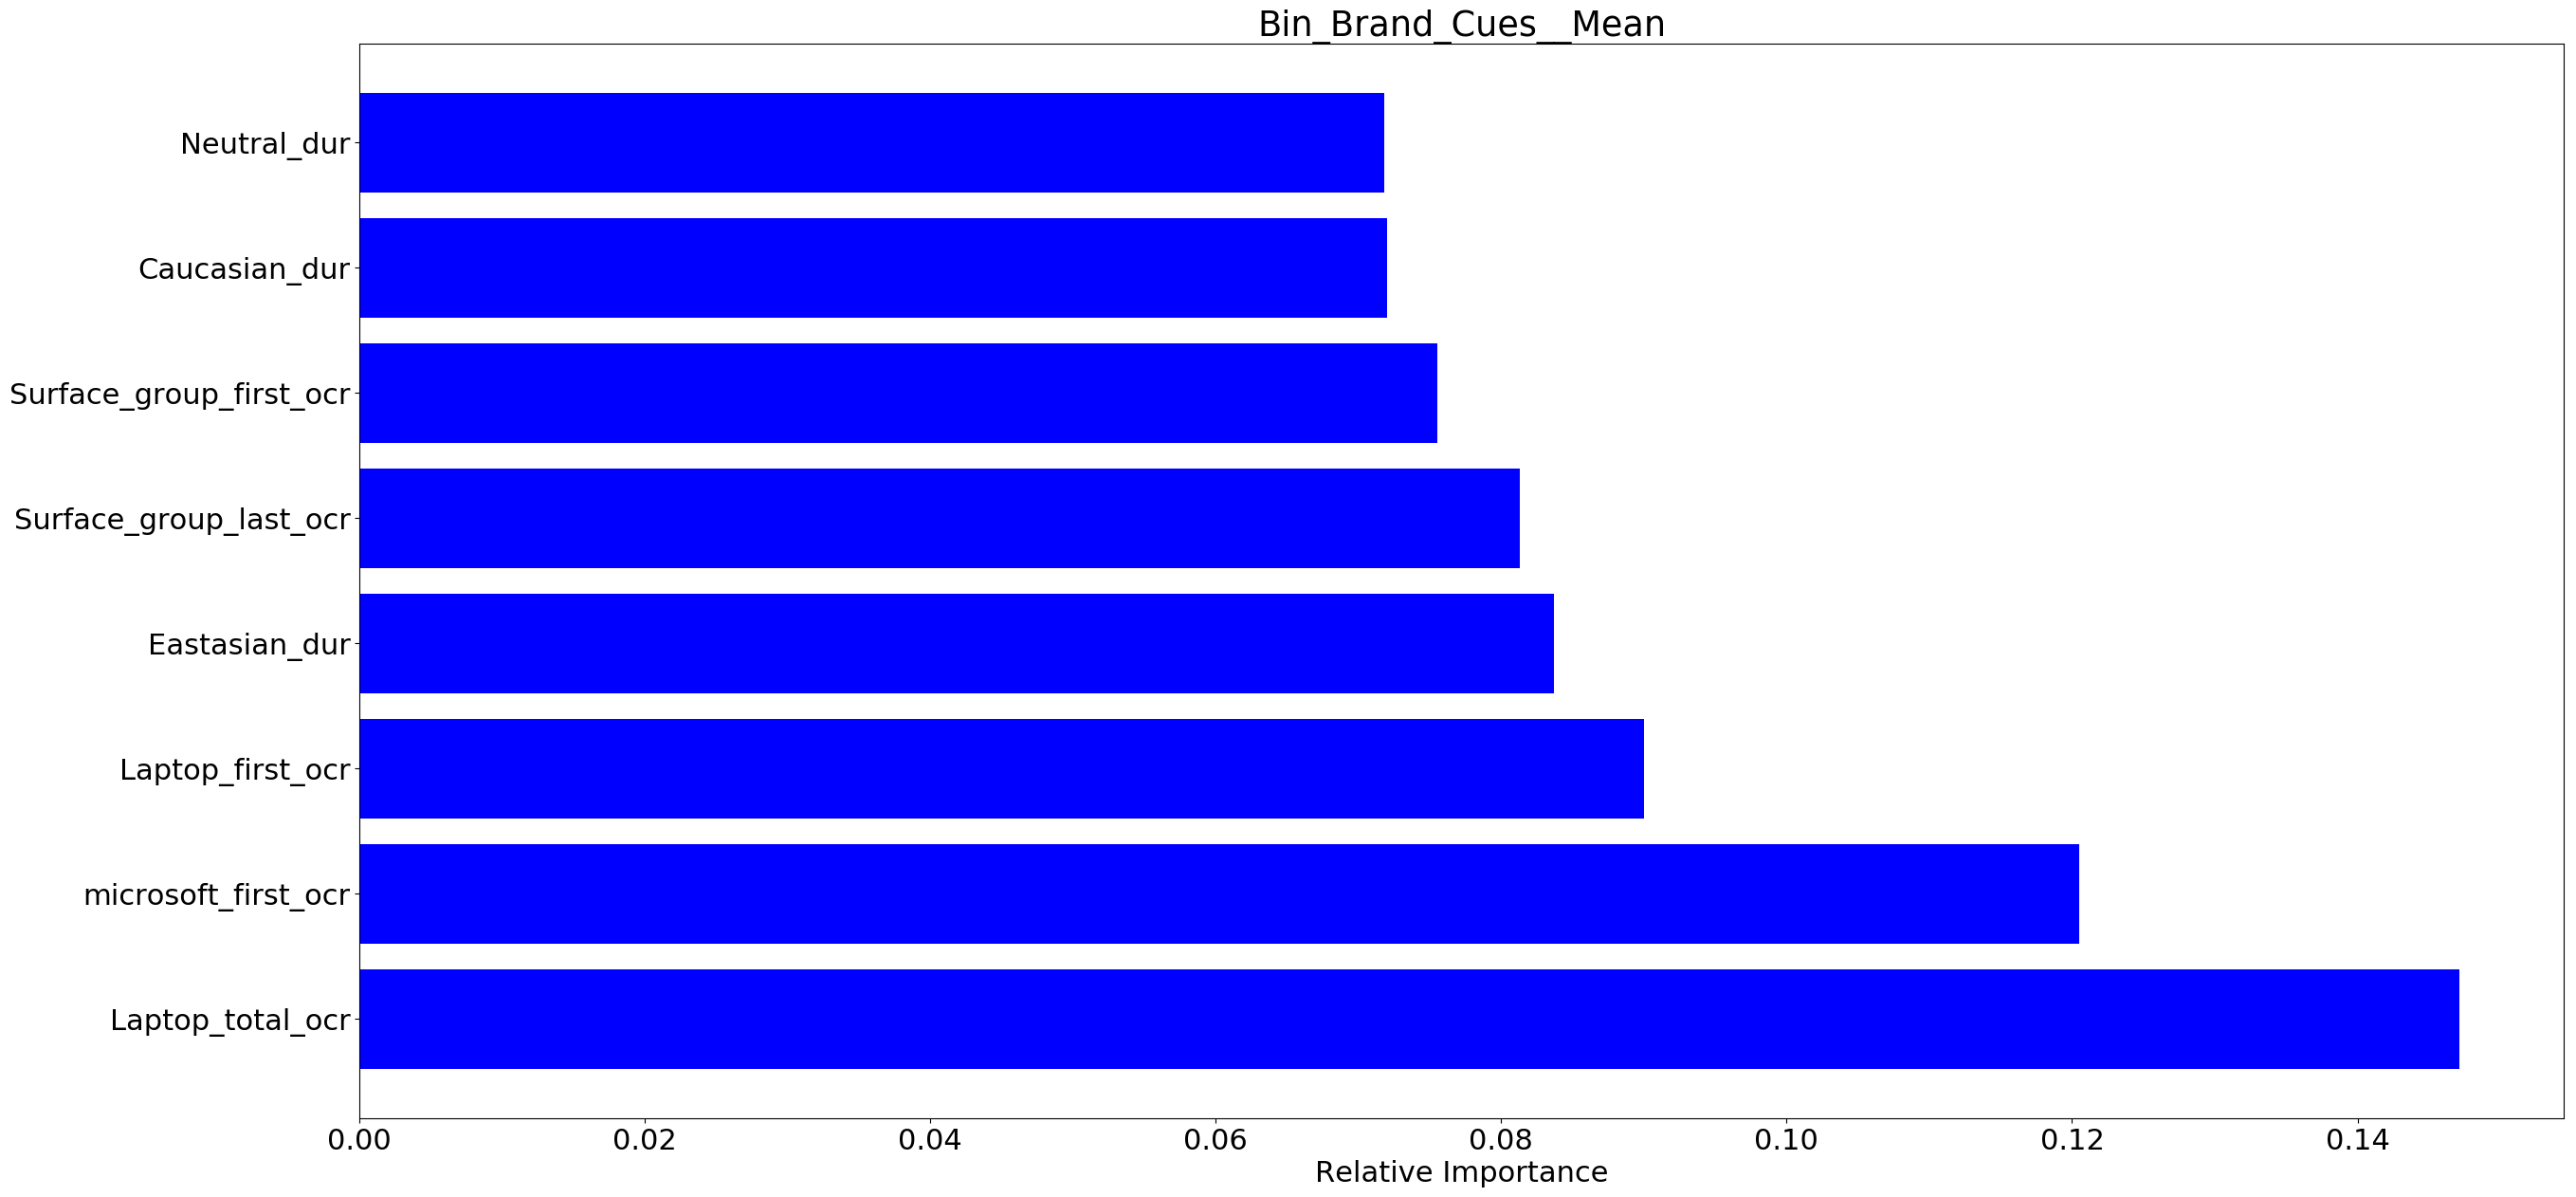

Bin_Aided_Branding__Mean
Feature ranking:
Laptop_total_ocr
Surface_group_last_ocr
Surface_group_first_ocr
microsoft_first_ocr
Laptop_last_ocr
Tablet_total_ocr
Laptop_dur
Tablet_last_ocr
Tablet_first_ocr
microsoft_last_ocr
Tablet_dur
African_dur
Macbook_group_dur
length_of_ad_15


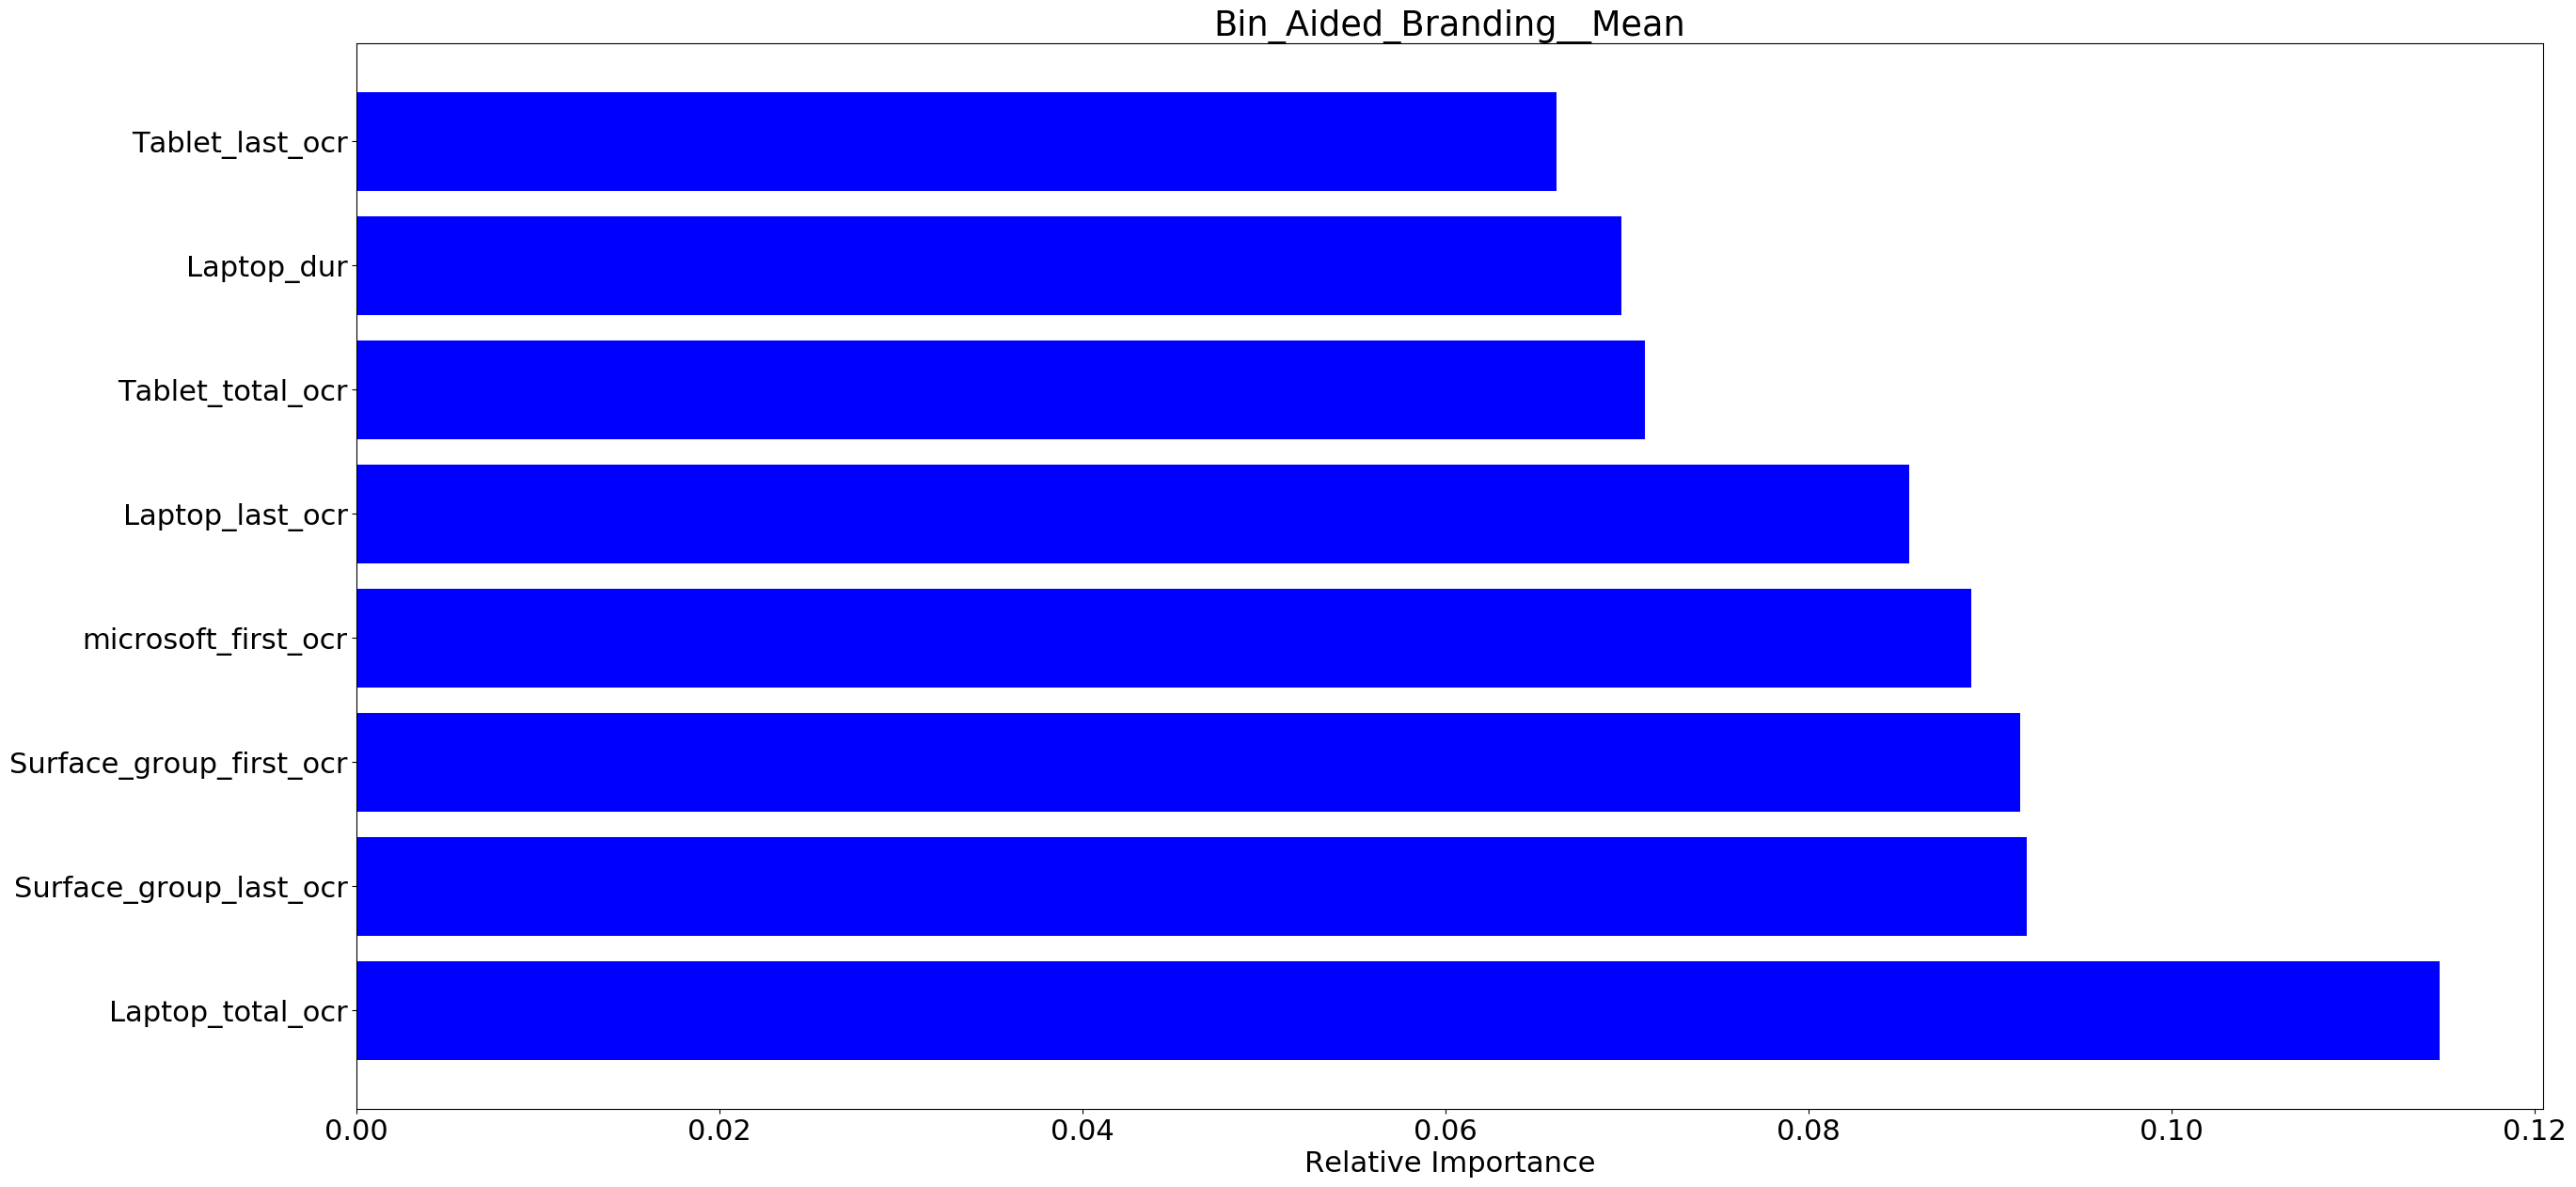

Bin_Active_Involvement__Mean
Feature ranking:
microsoft_last_ocr
Surface_group_last_ocr
Caucasian_dur
Tablet_dur
Surface_group_first_ocr
microsoft_total_ocr
Laptop_last_ocr
Eastasian_dur
Tablet_total_ocr
Laptop_total_ocr
microsoft_first_ocr
length_of_ad_15
microsoft_dur
Tablet_last_ocr
Surface_group_dur


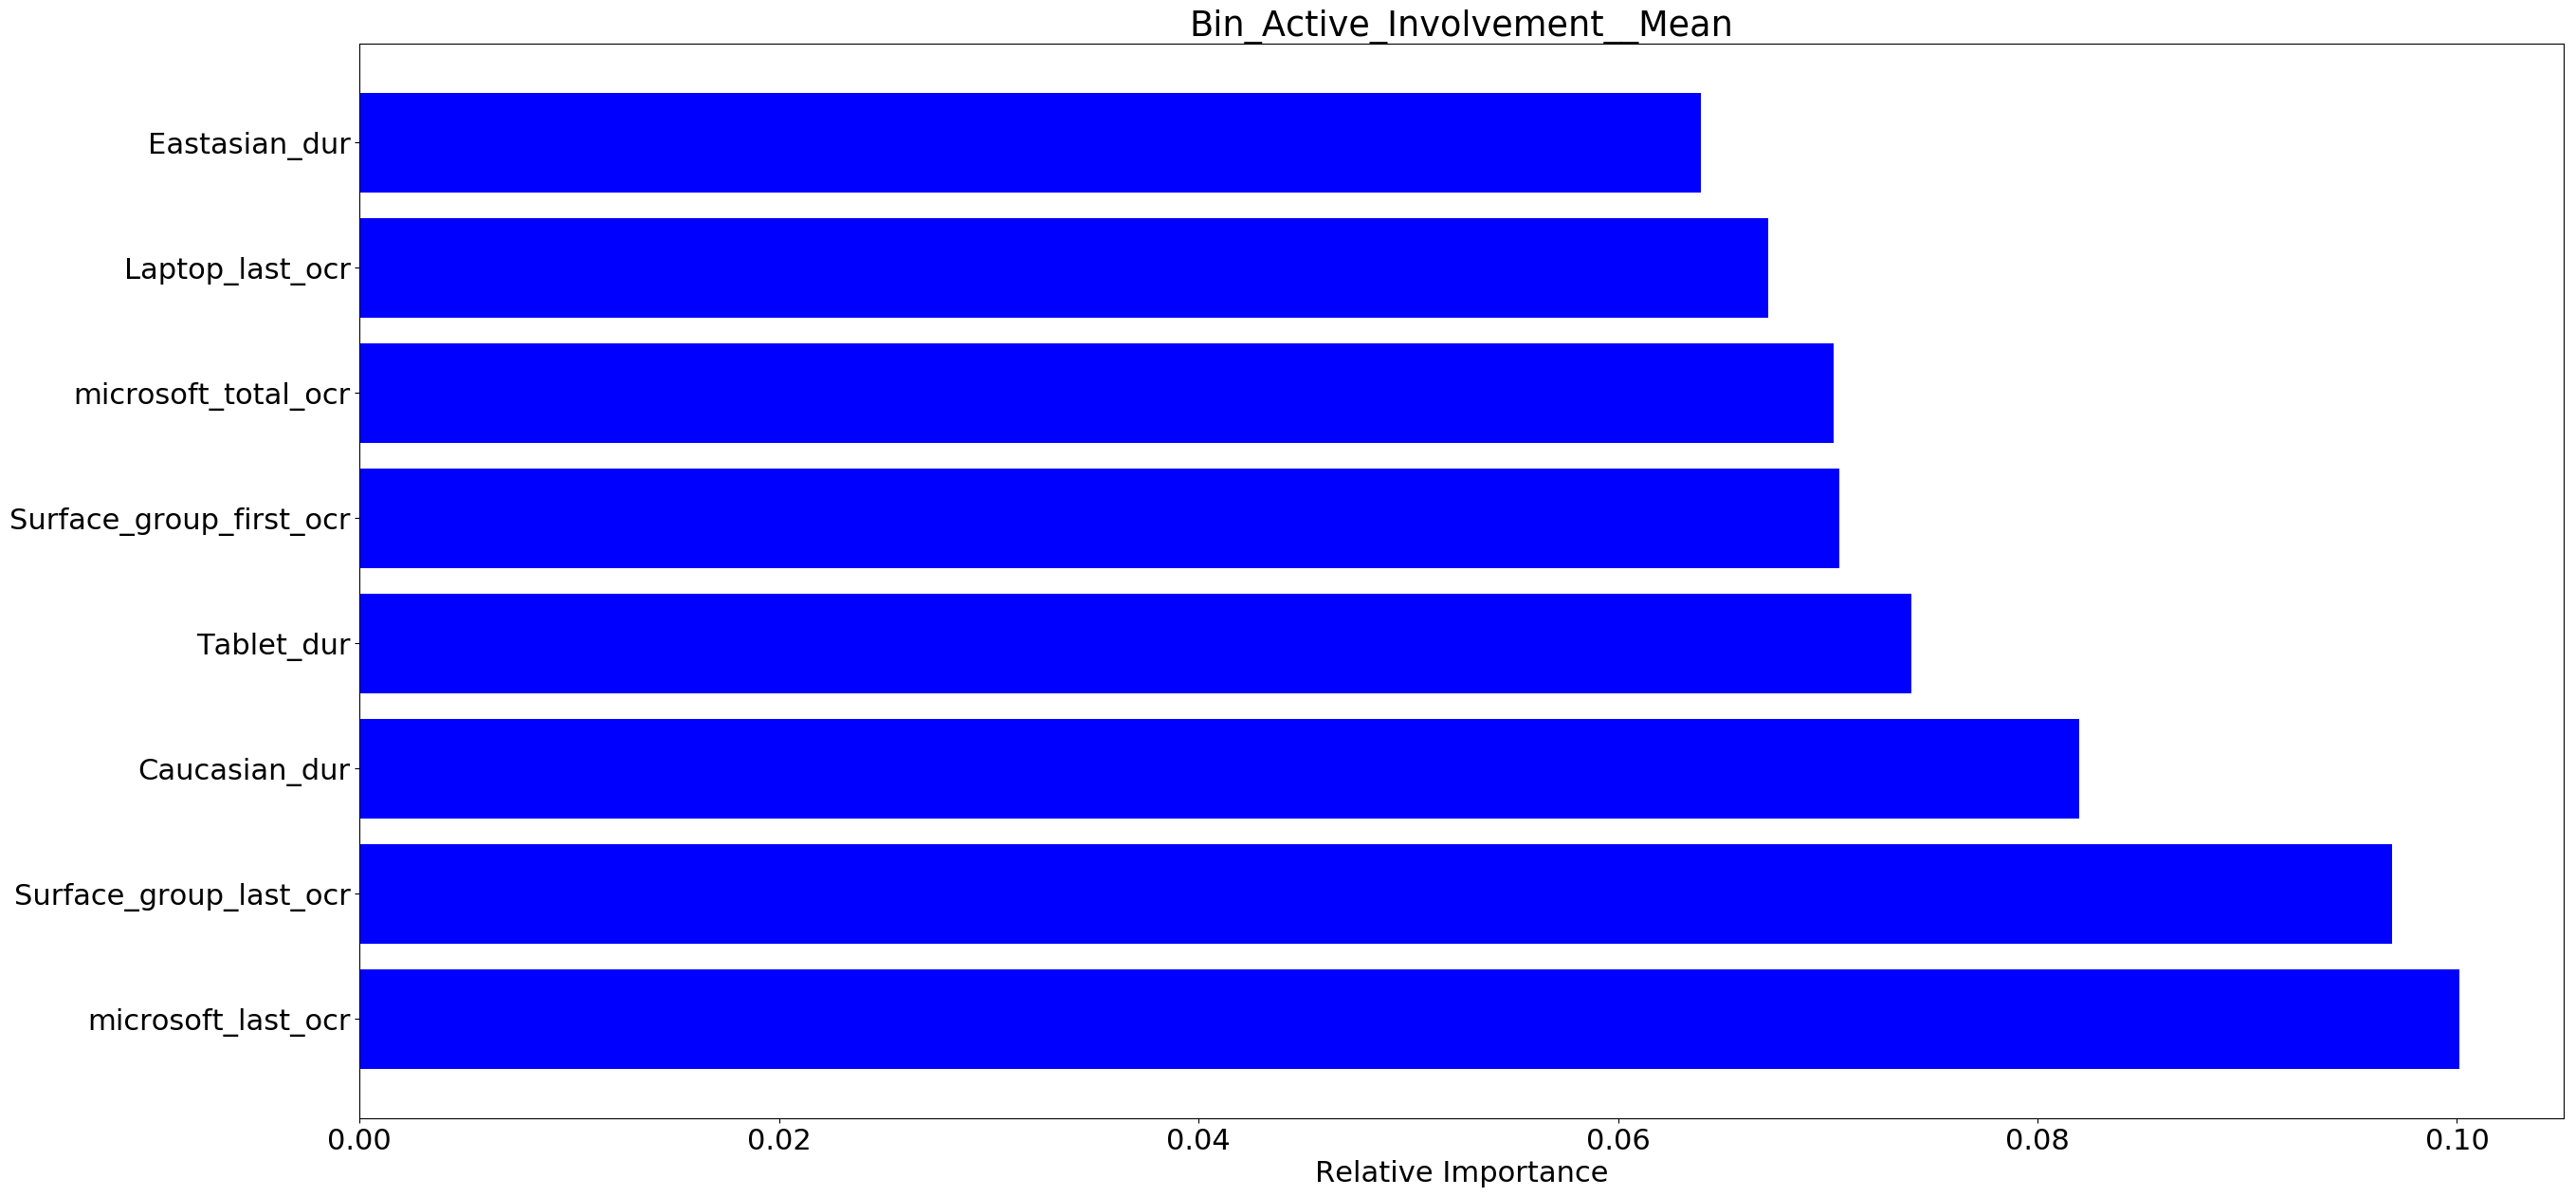

Bin_New_Information__Mean
Feature ranking:
Surface_group_first_ocr
Surface_group_total_ocr
African_dur
Surface_group_last_ocr
microsoft_first_ocr
Neutral_dur
Sadness_dur
Happiness_dur
Tablet_total_ocr
Surface_group_dur
Tablet_last_ocr
Tablet_dur
microsoft_last_ocr
Tablet_first_ocr


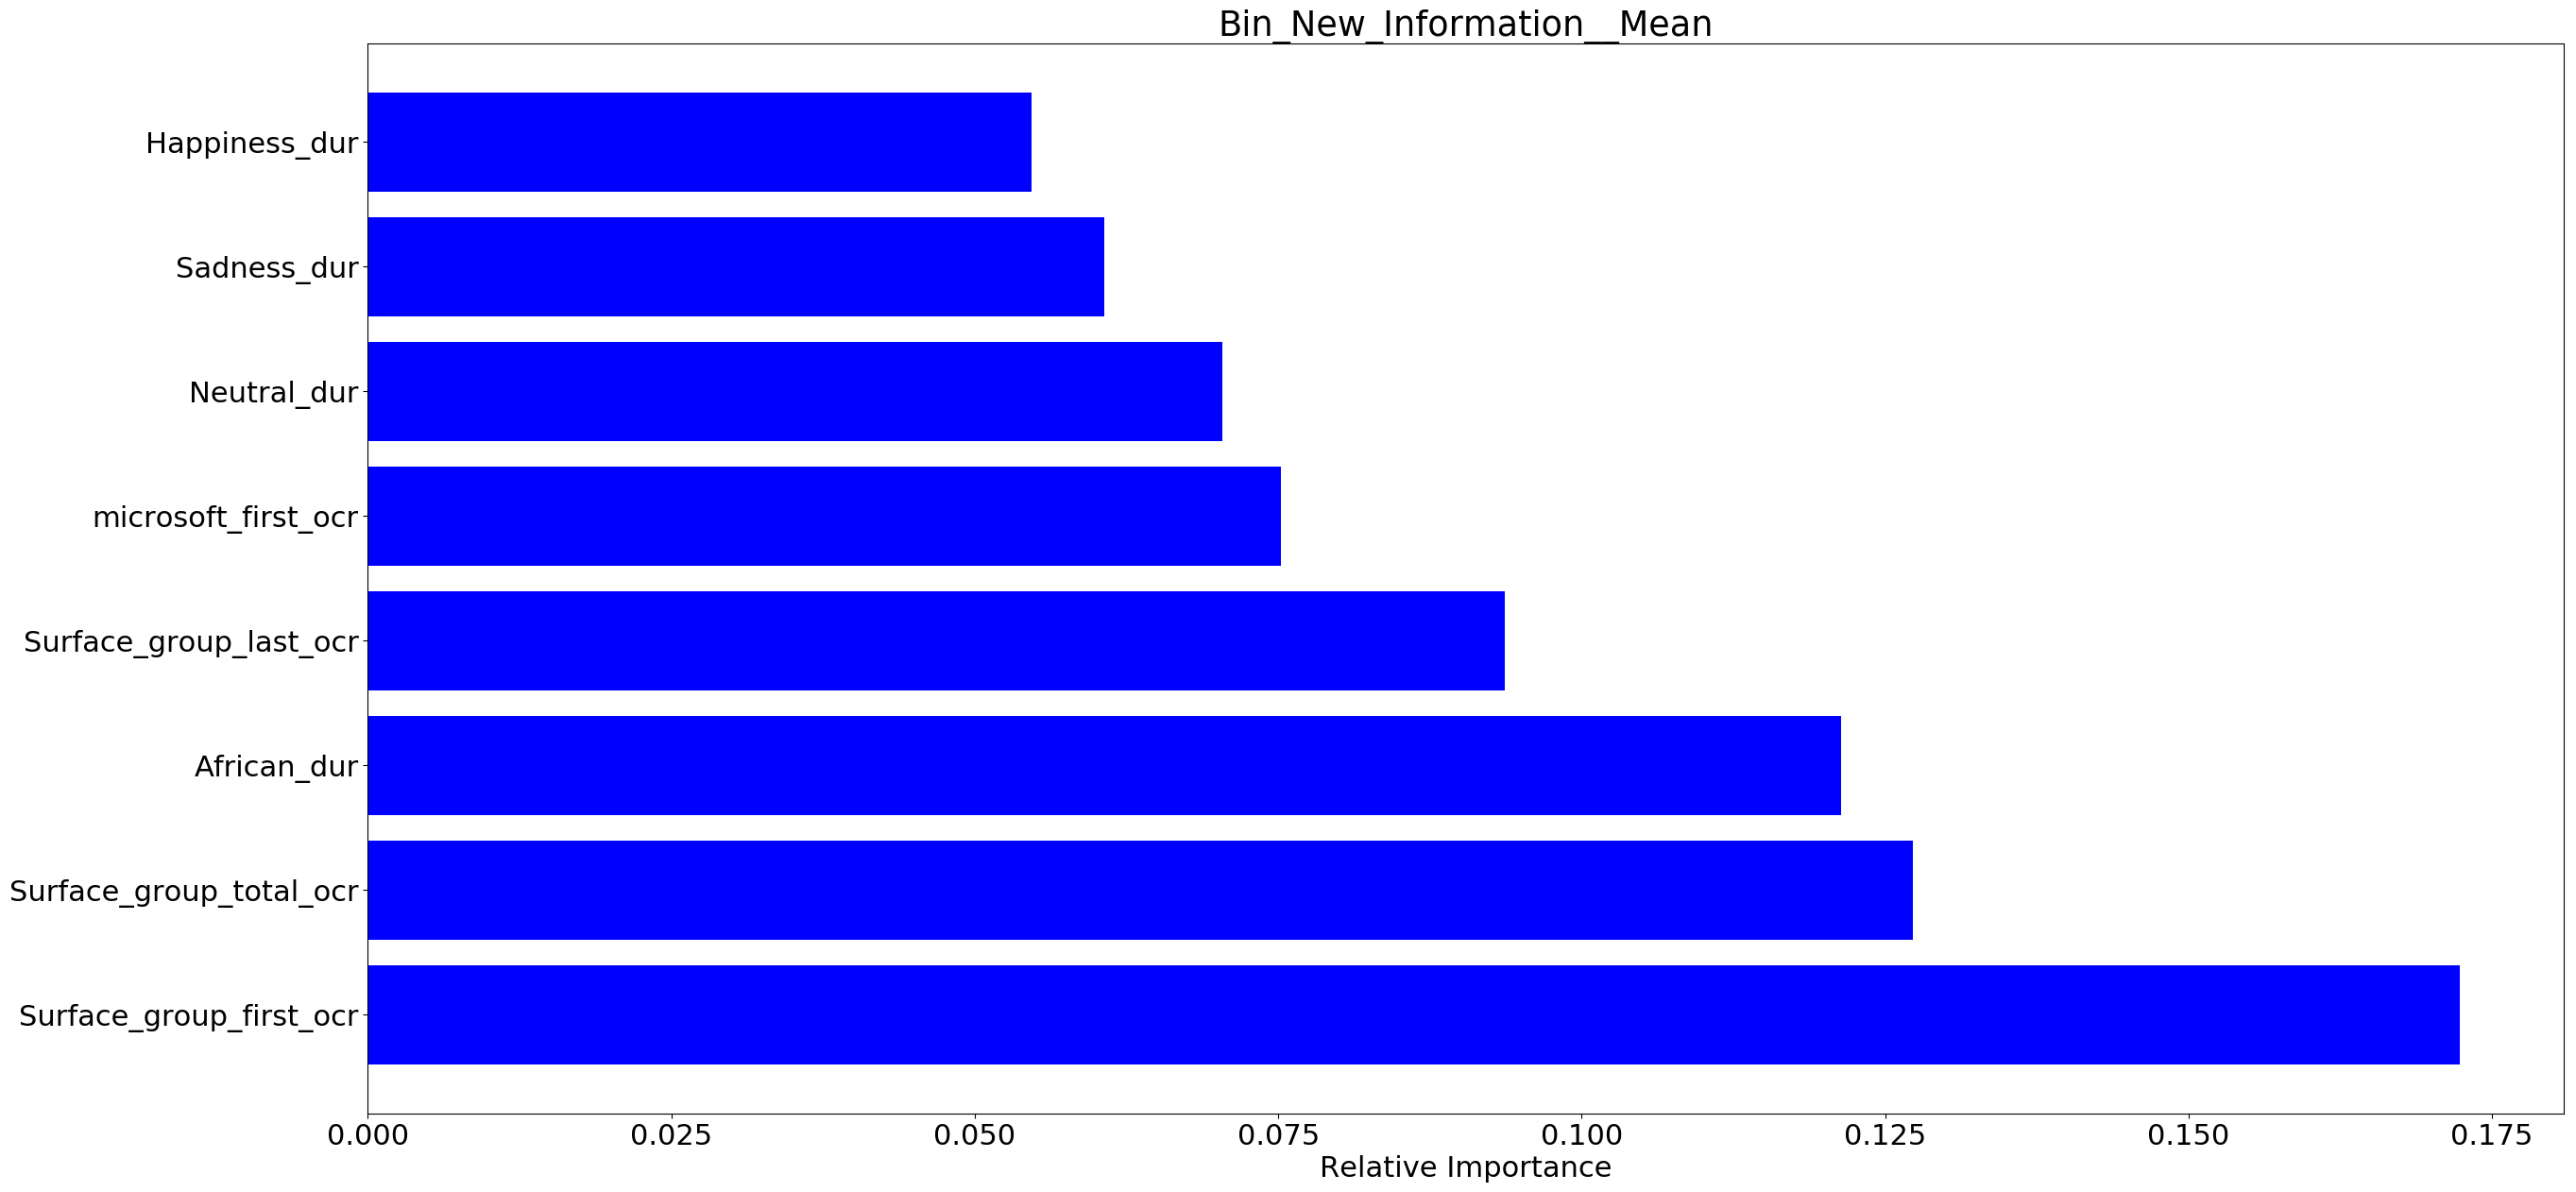

Bin_Enjoyment__Mean
Feature ranking:
Neutral_dur
microsoft_total_ocr
microsoft_last_ocr
Surface_group_first_ocr
microsoft_first_ocr
Laptop_dur
microsoft_dur
Macbook_group_dur
Surface_group_dur
Age: 25-34_dur
length_of_ad_15
African_dur


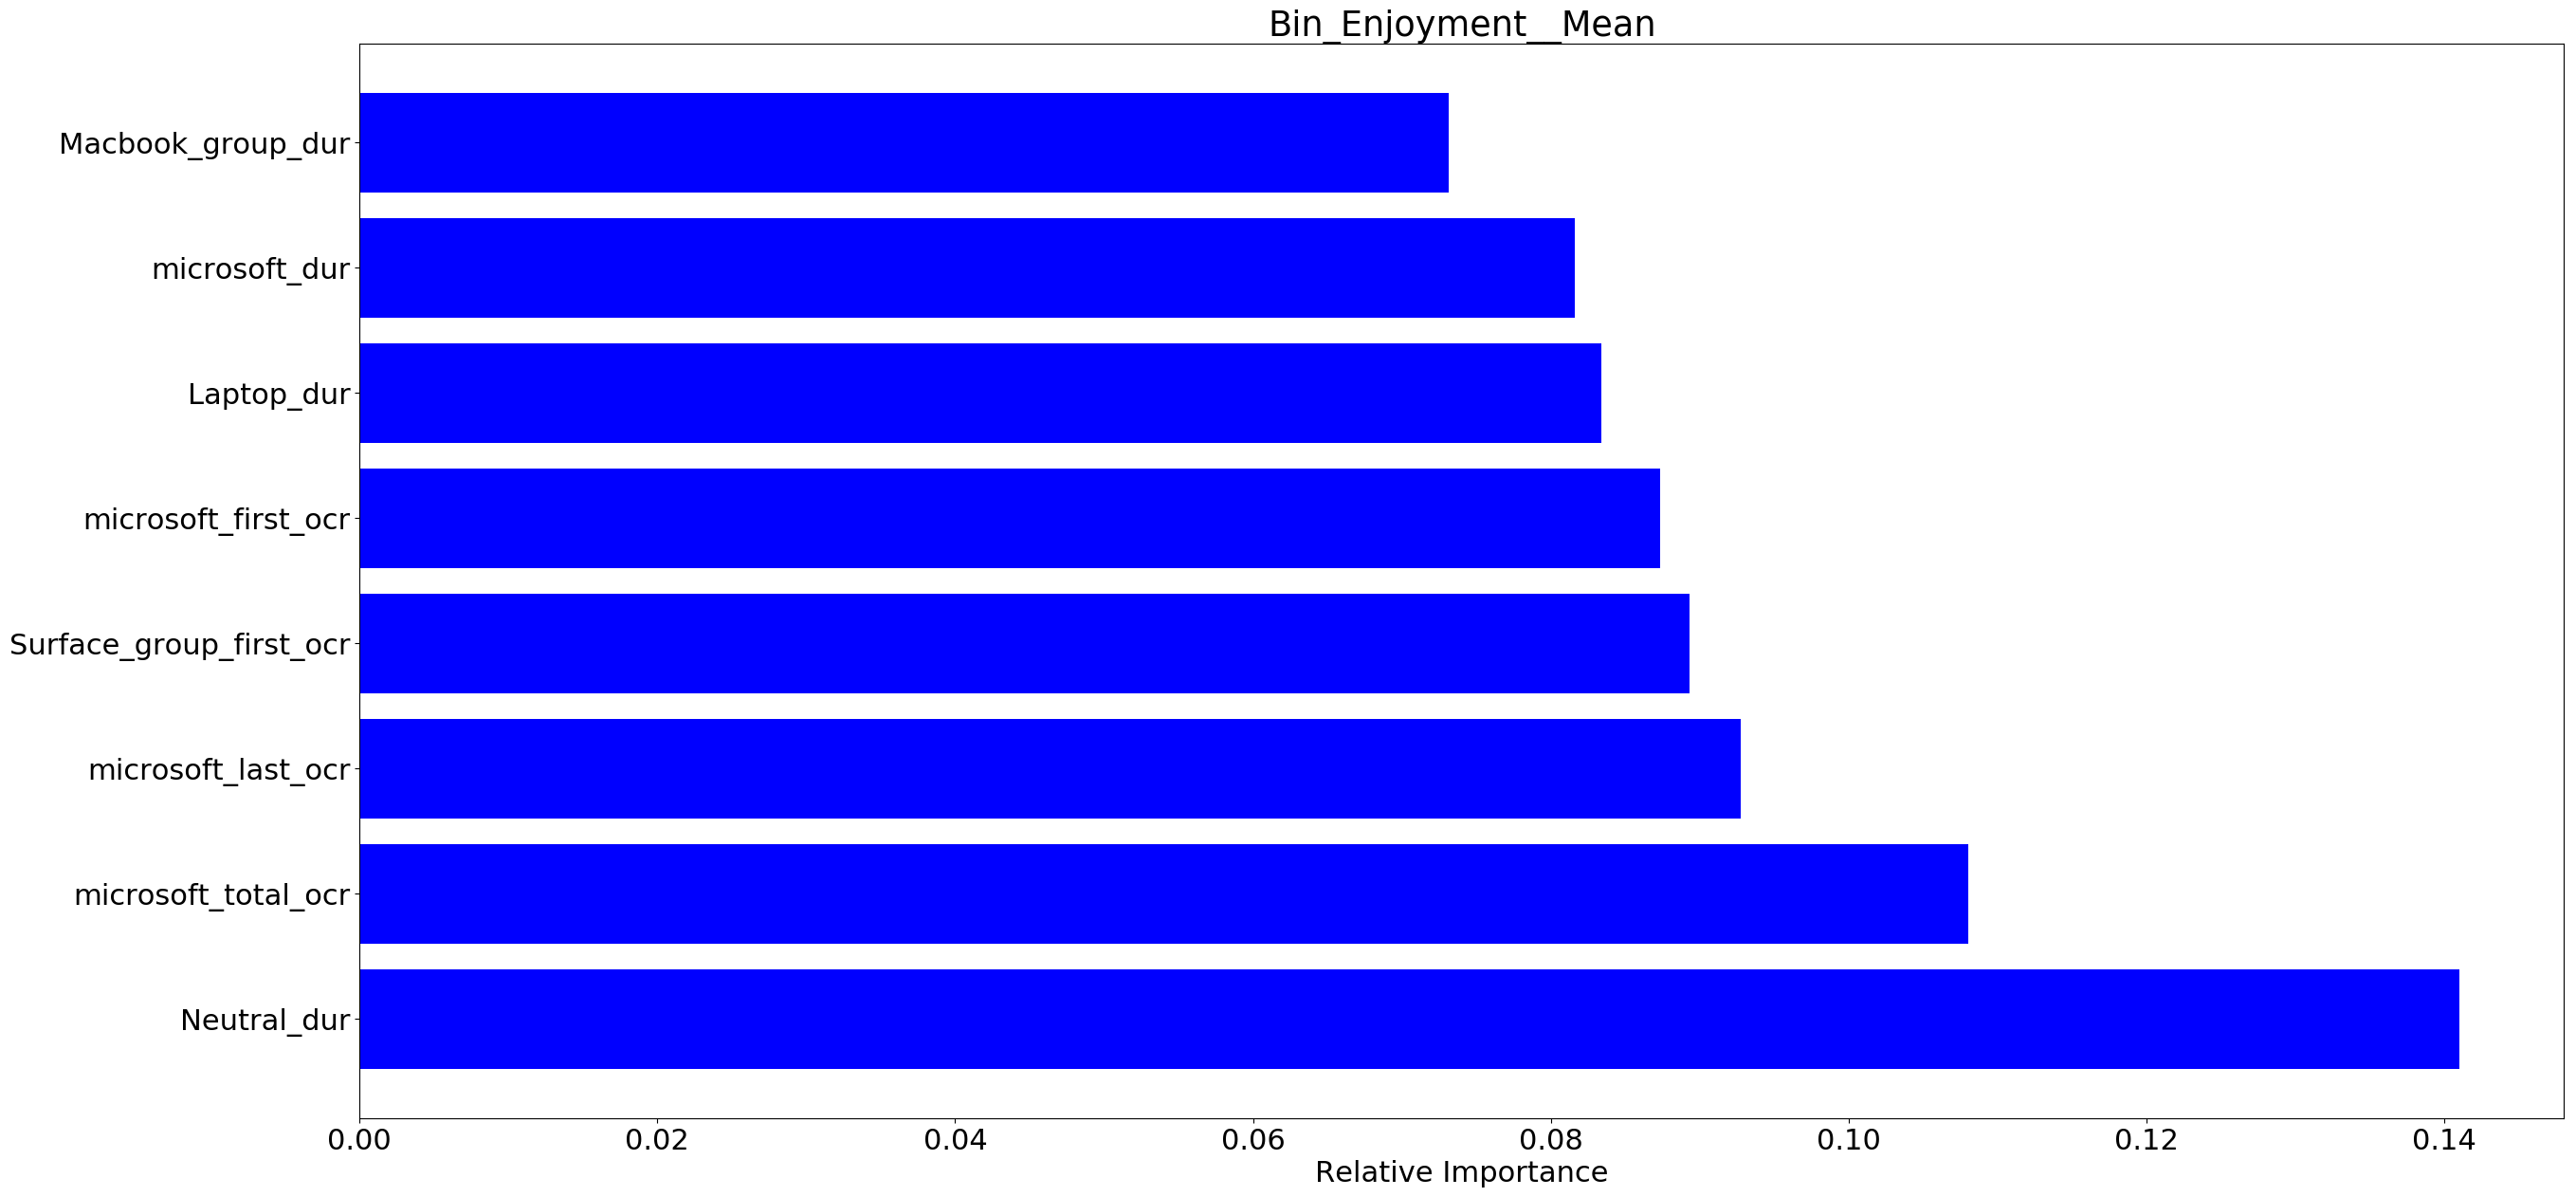

Bin_Brand_Appeal__Mean
Feature ranking:
Surface_group_dur
African_dur
microsoft_first_ocr
Laptop_last_ocr
Surface_group_last_ocr
Neutral_dur
Surface_group_total_ocr
Tablet_first_ocr
Caucasian_dur
microsoft_last_ocr
microsoft_dur
Female_dur
length_of_ad_15
Macbook_group_dur


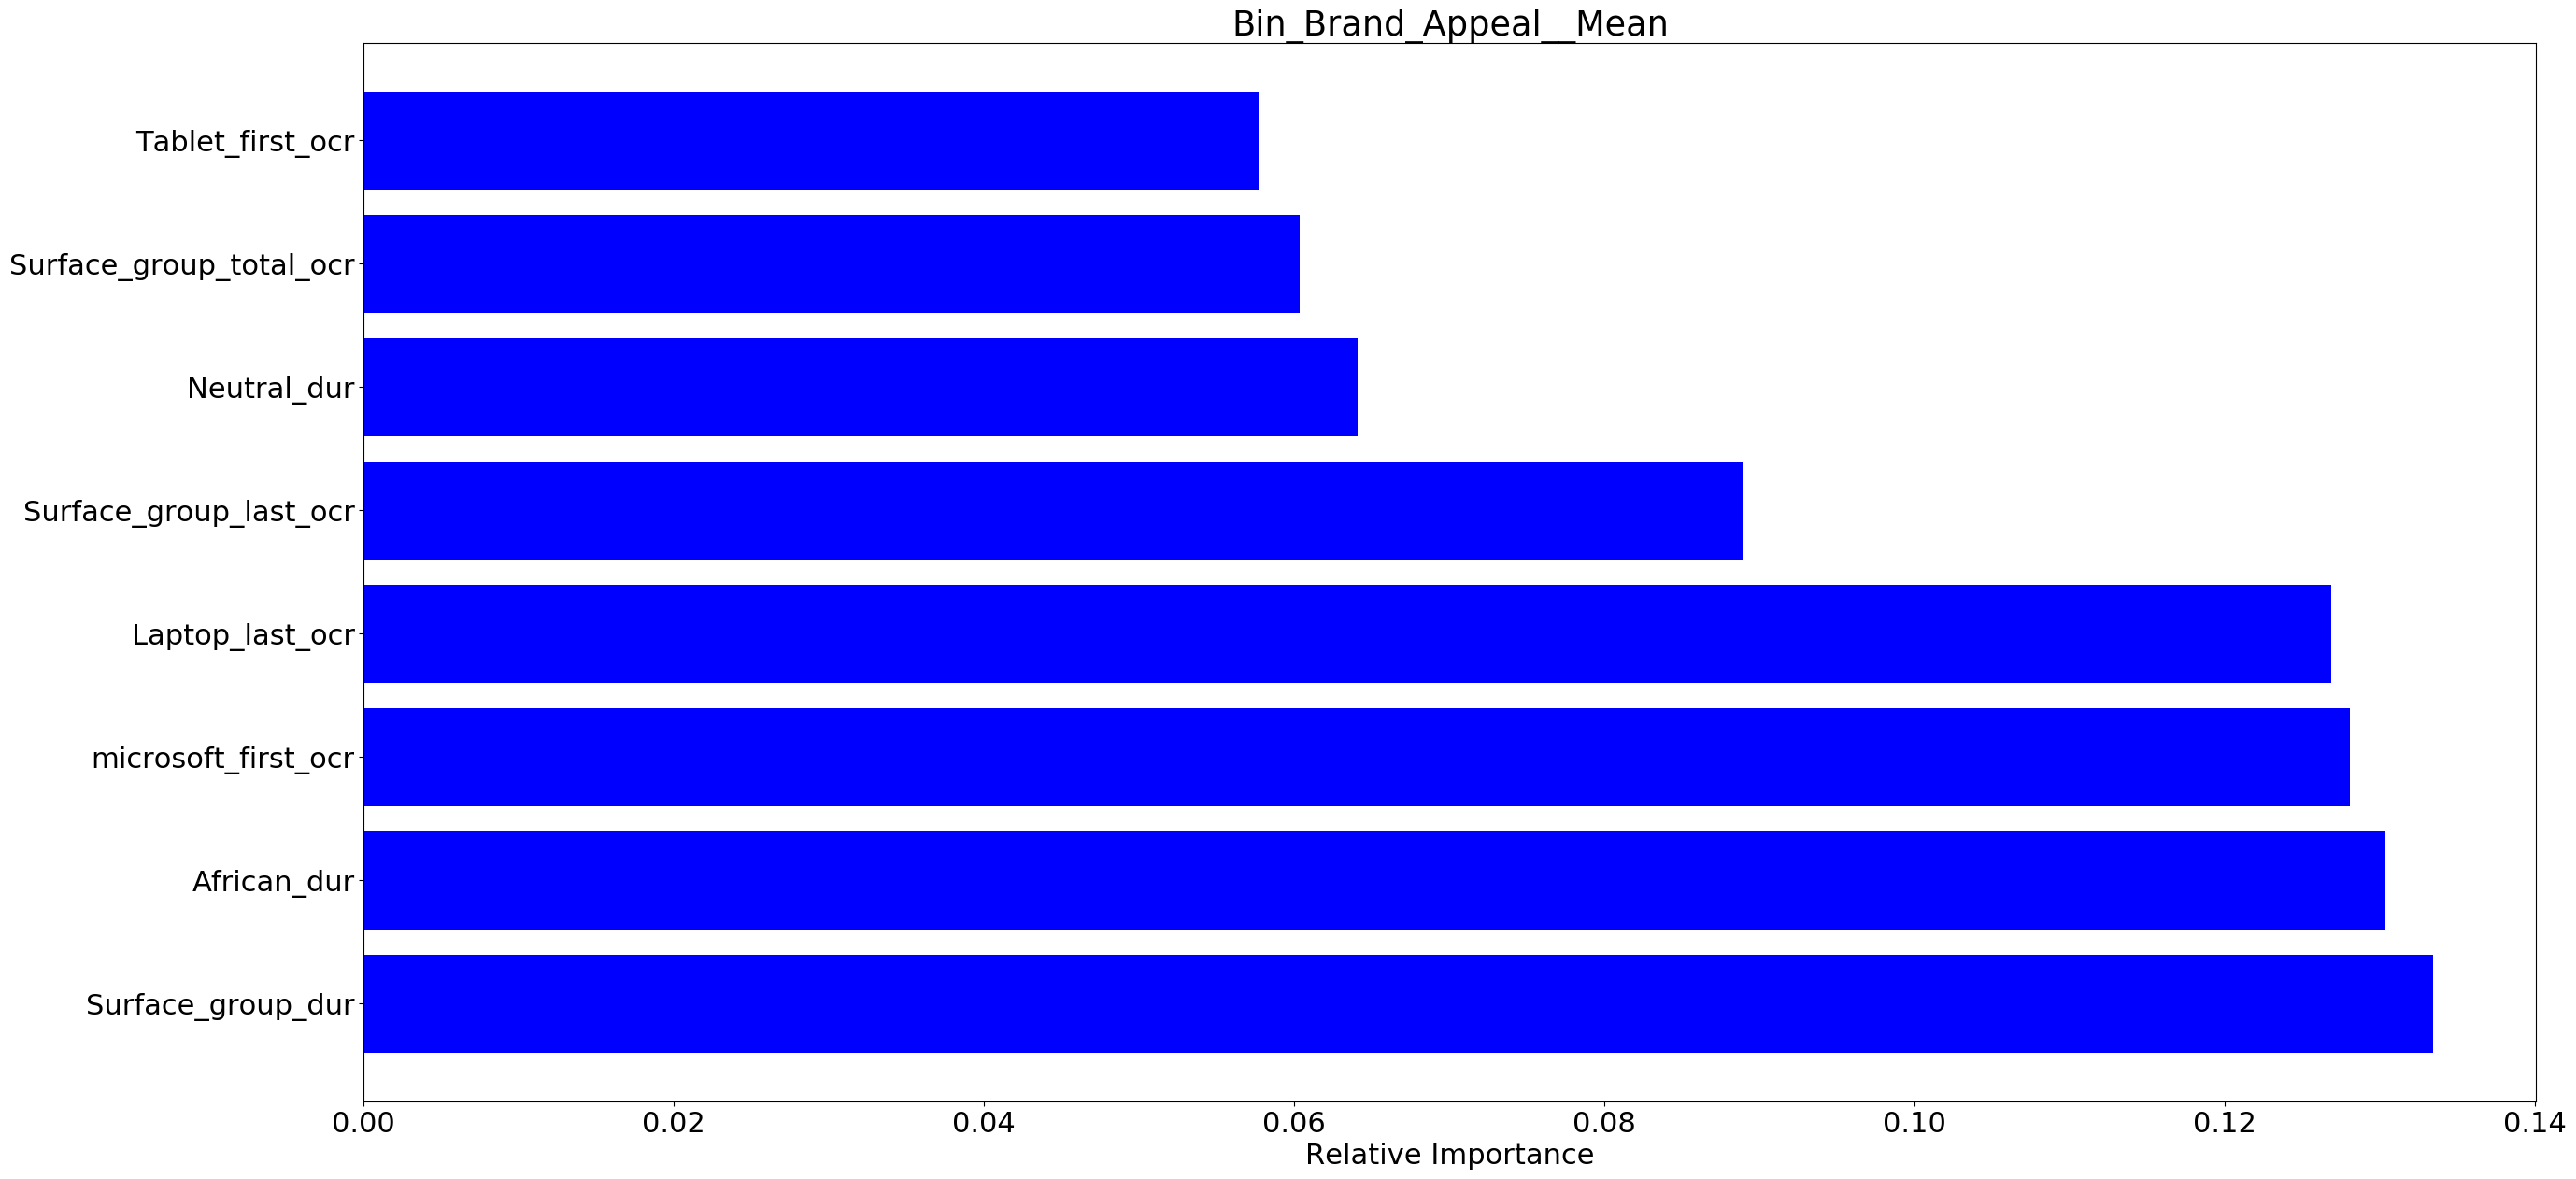

Bin_Understanding__Mean
Feature ranking:
African_dur
microsoft_first_ocr
Caucasian_dur
Surface_group_dur
Neutral_dur
Tablet_first_ocr
Laptop_first_ocr
Laptop_last_ocr
Surface_group_total_ocr
Tablet_last_ocr
microsoft_last_ocr
microsoft_dur
microsoft_total_ocr
Female_dur
Male_dur
length_of_ad_15


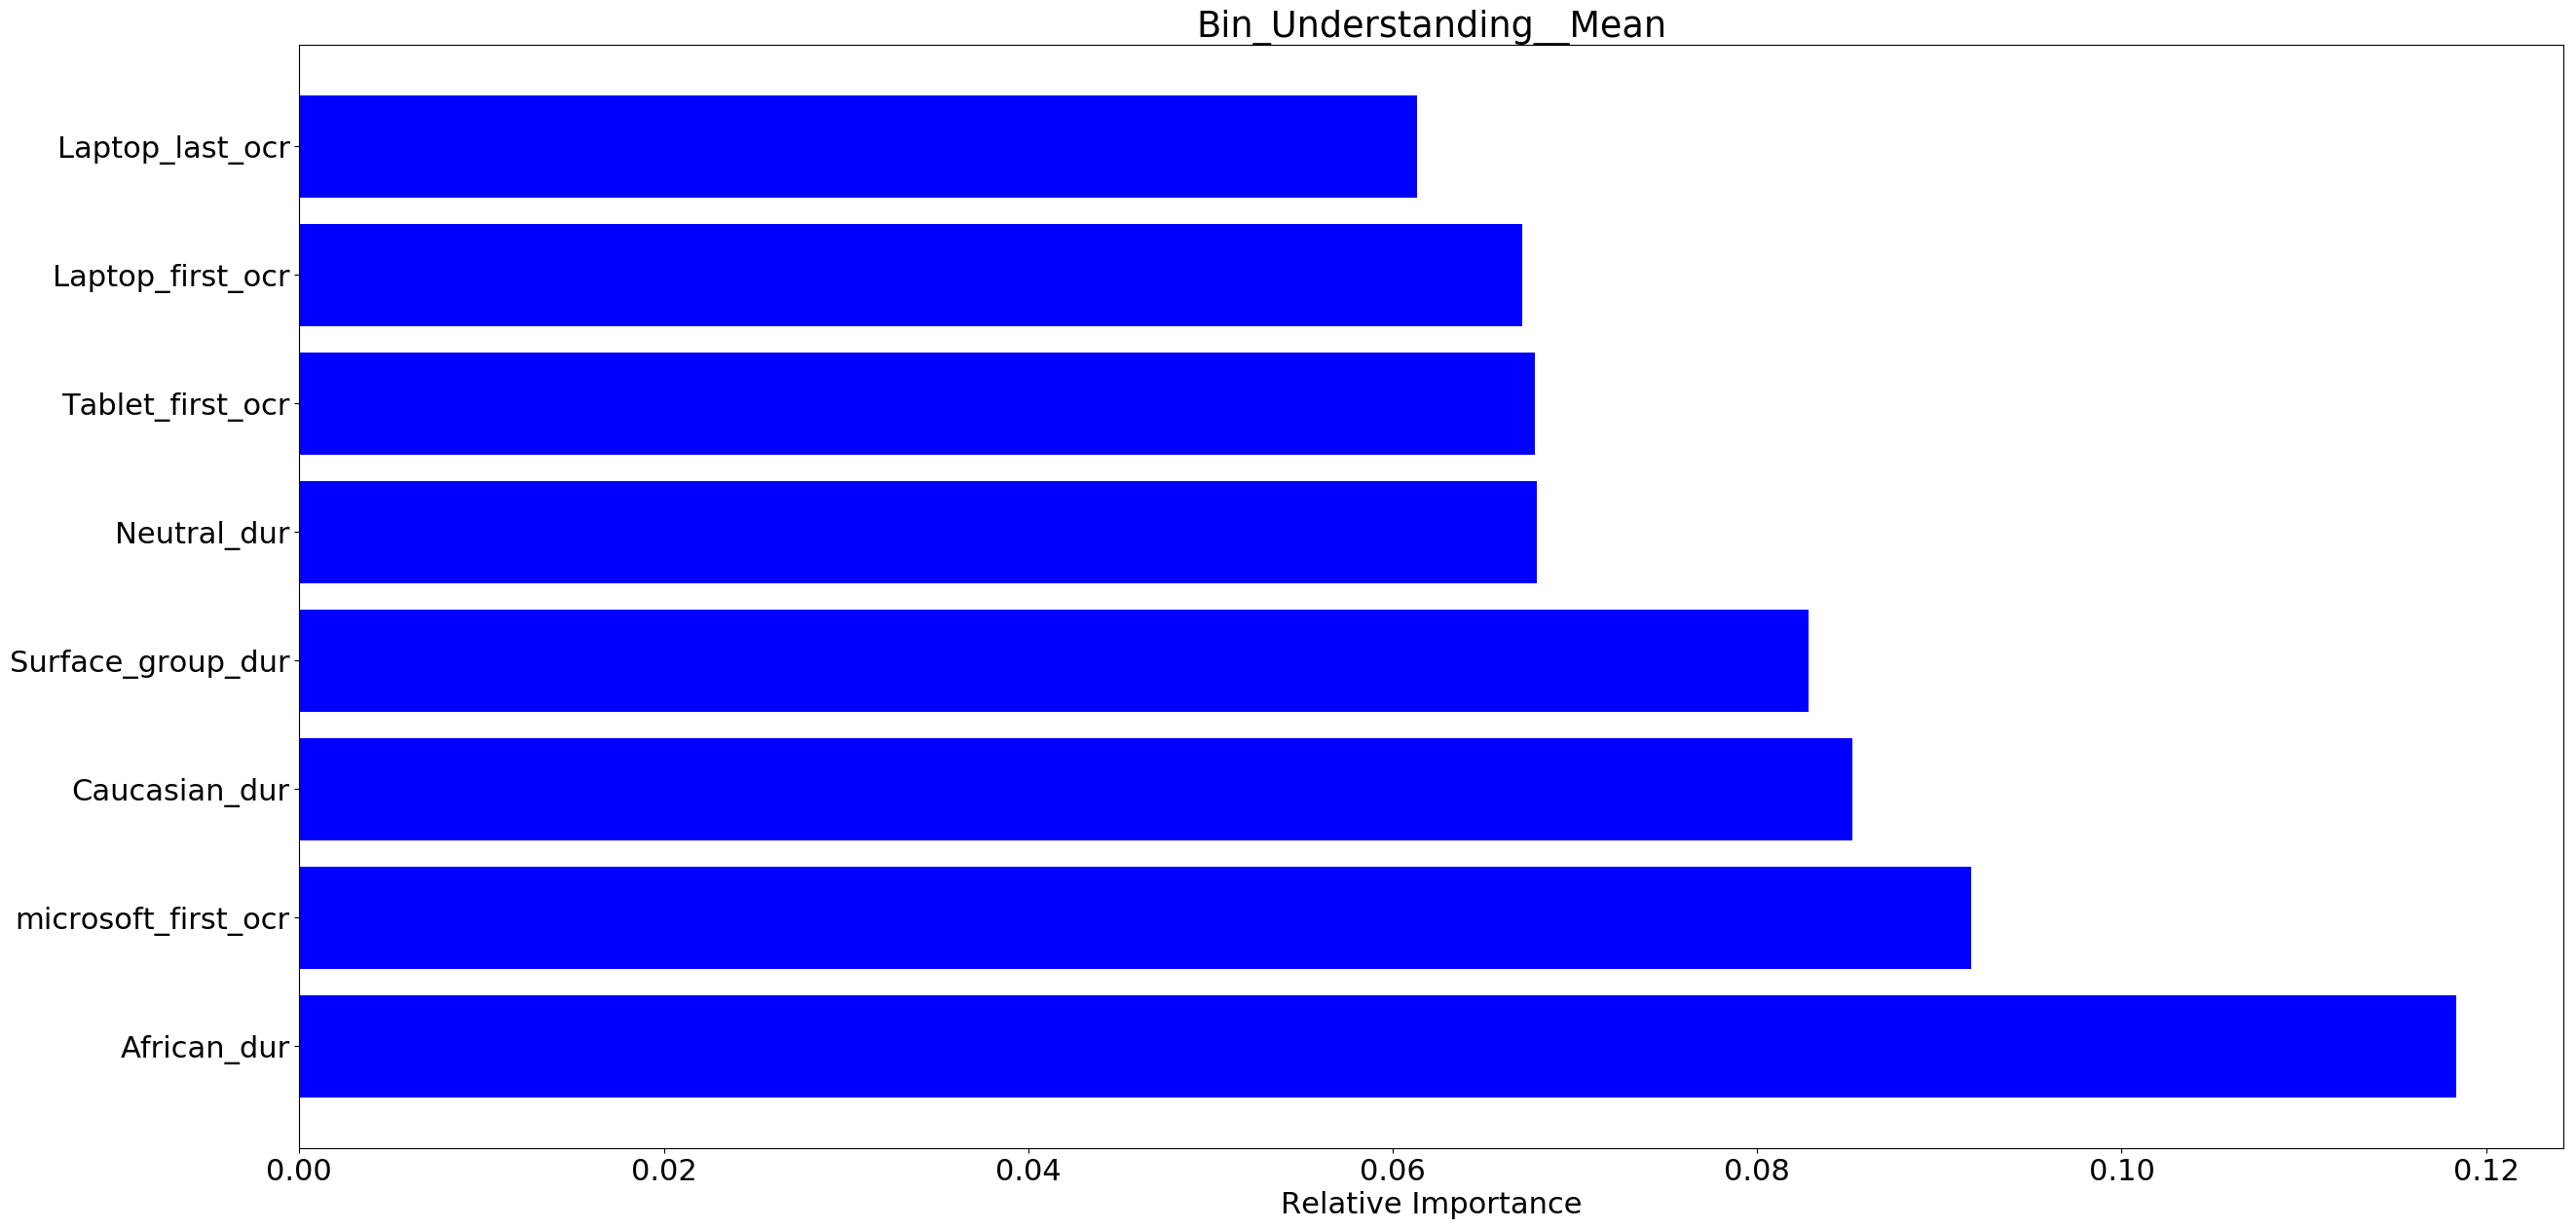

Bin_Relevance_of_Information__Mean
Feature ranking:
Tablet_dur
Surface_group_last_ocr
Male_dur
African_dur
Caucasian_dur
microsoft_first_ocr
Tablet_last_ocr
microsoft_dur
Age: 25-34_dur
Laptop_dur
Tablet_first_ocr
microsoft_last_ocr
Eastasian_dur
Macbook_group_dur


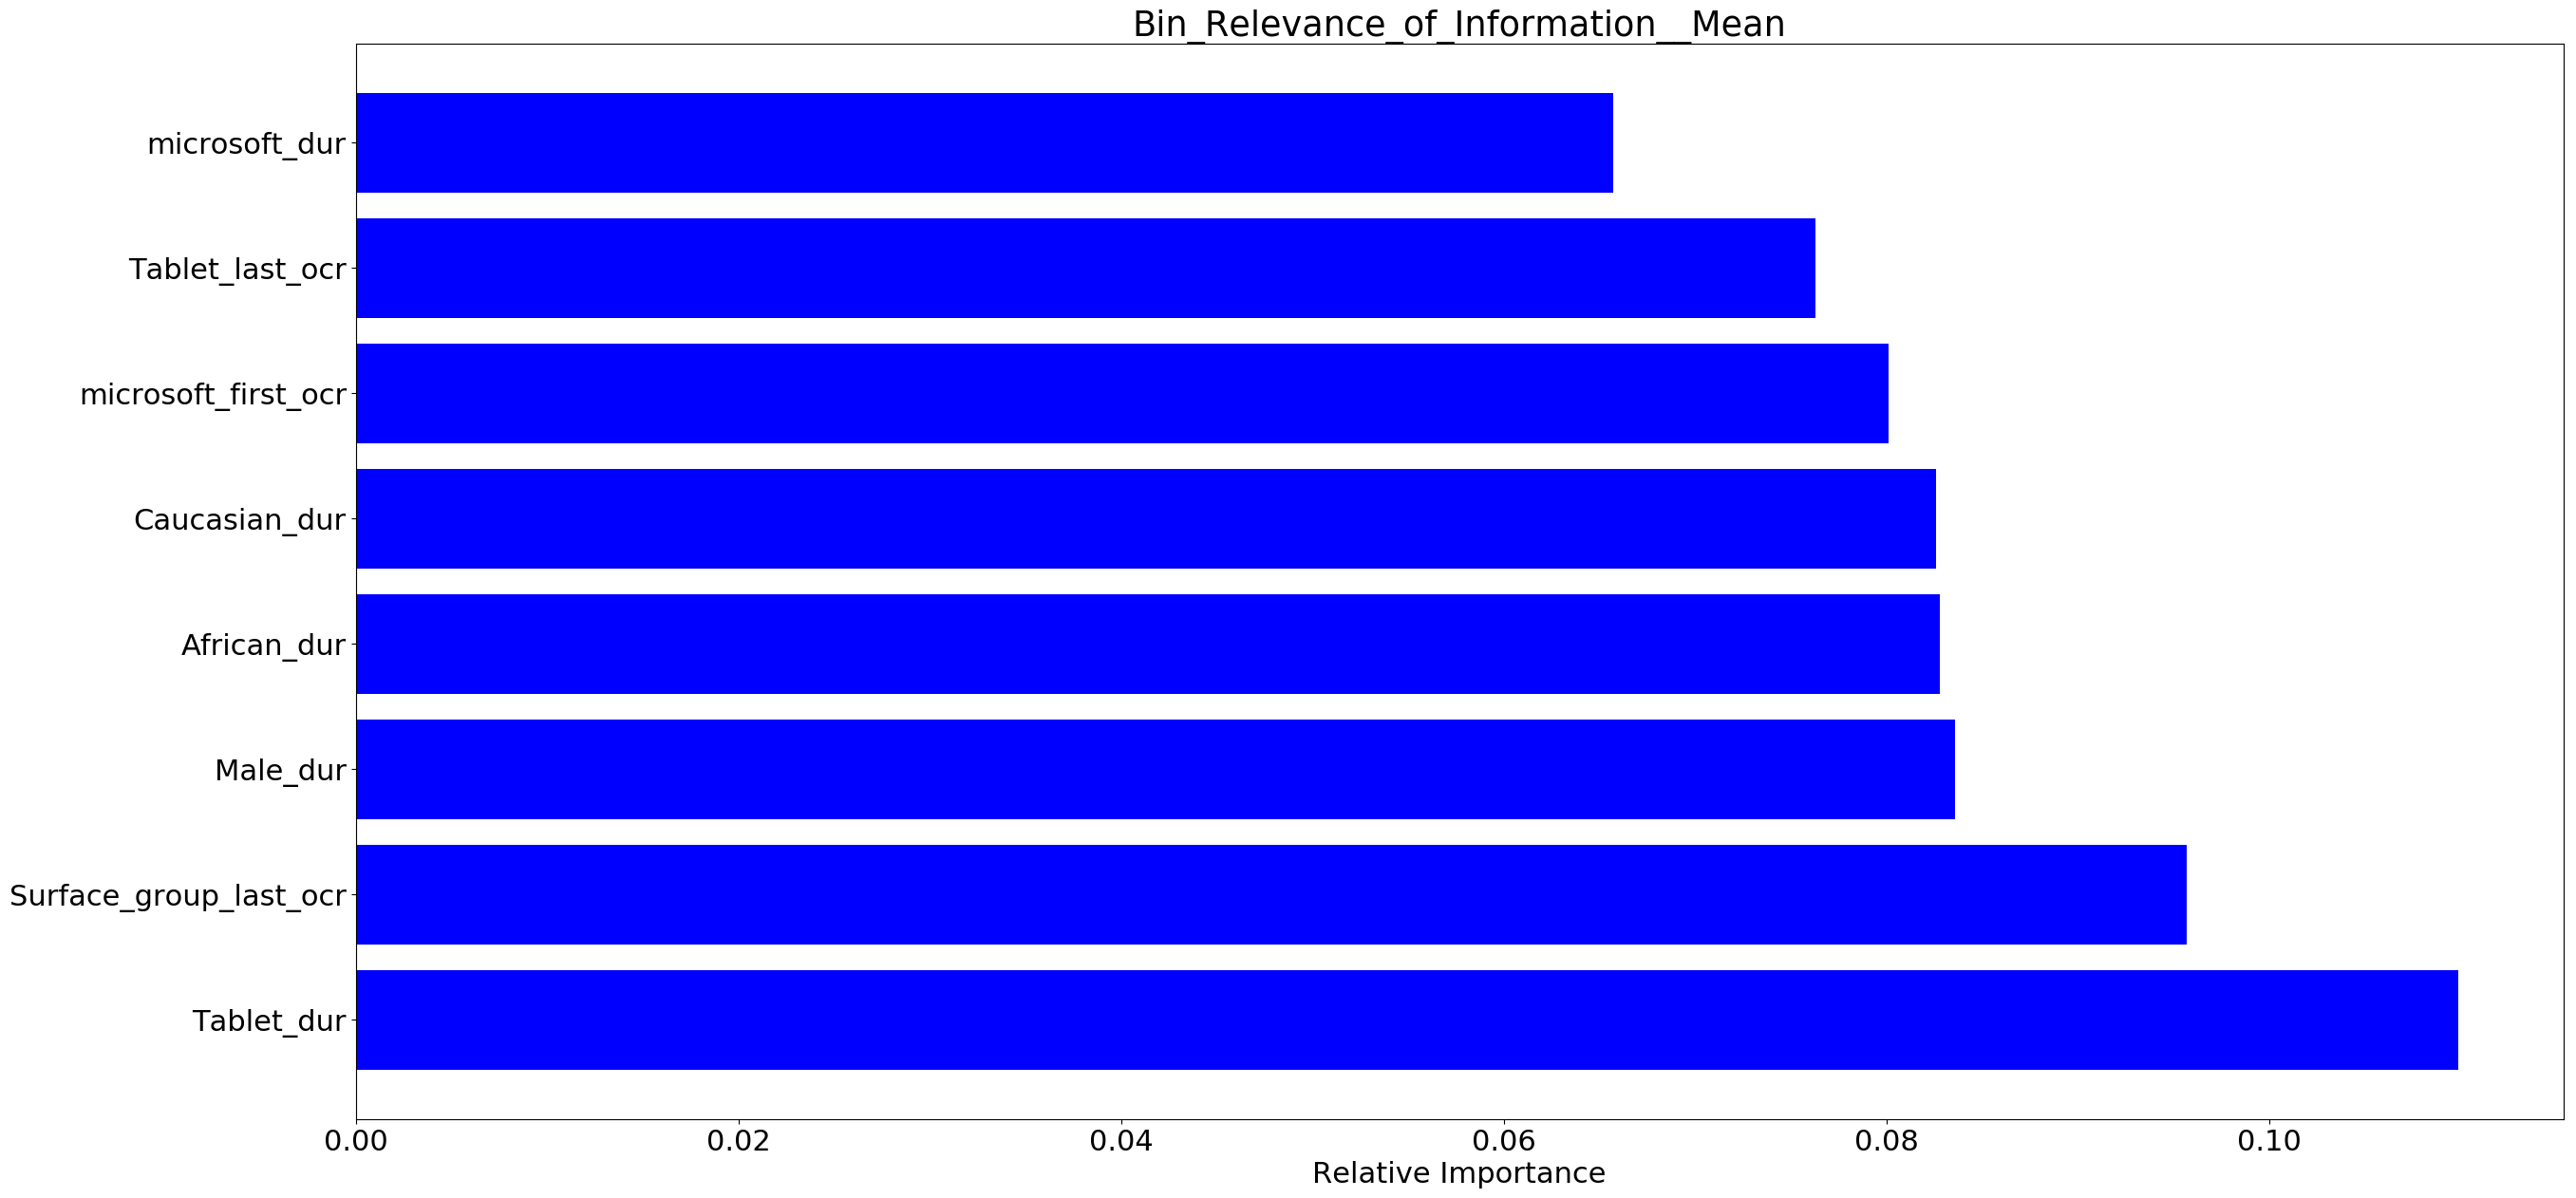

Bin_Credibility_of_Information__Mean
Feature ranking:
Laptop_first_ocr
Macbook_group_dur
African_dur
Eastasian_dur
Male_dur
Caucasian_dur
Surface_group_last_ocr
Tablet_first_ocr
Laptop_total_ocr
Laptop_last_ocr
Tablet_last_ocr
Tablet_total_ocr
microsoft_total_ocr
Tablet_dur
microsoft_last_ocr
length_of_ad_15


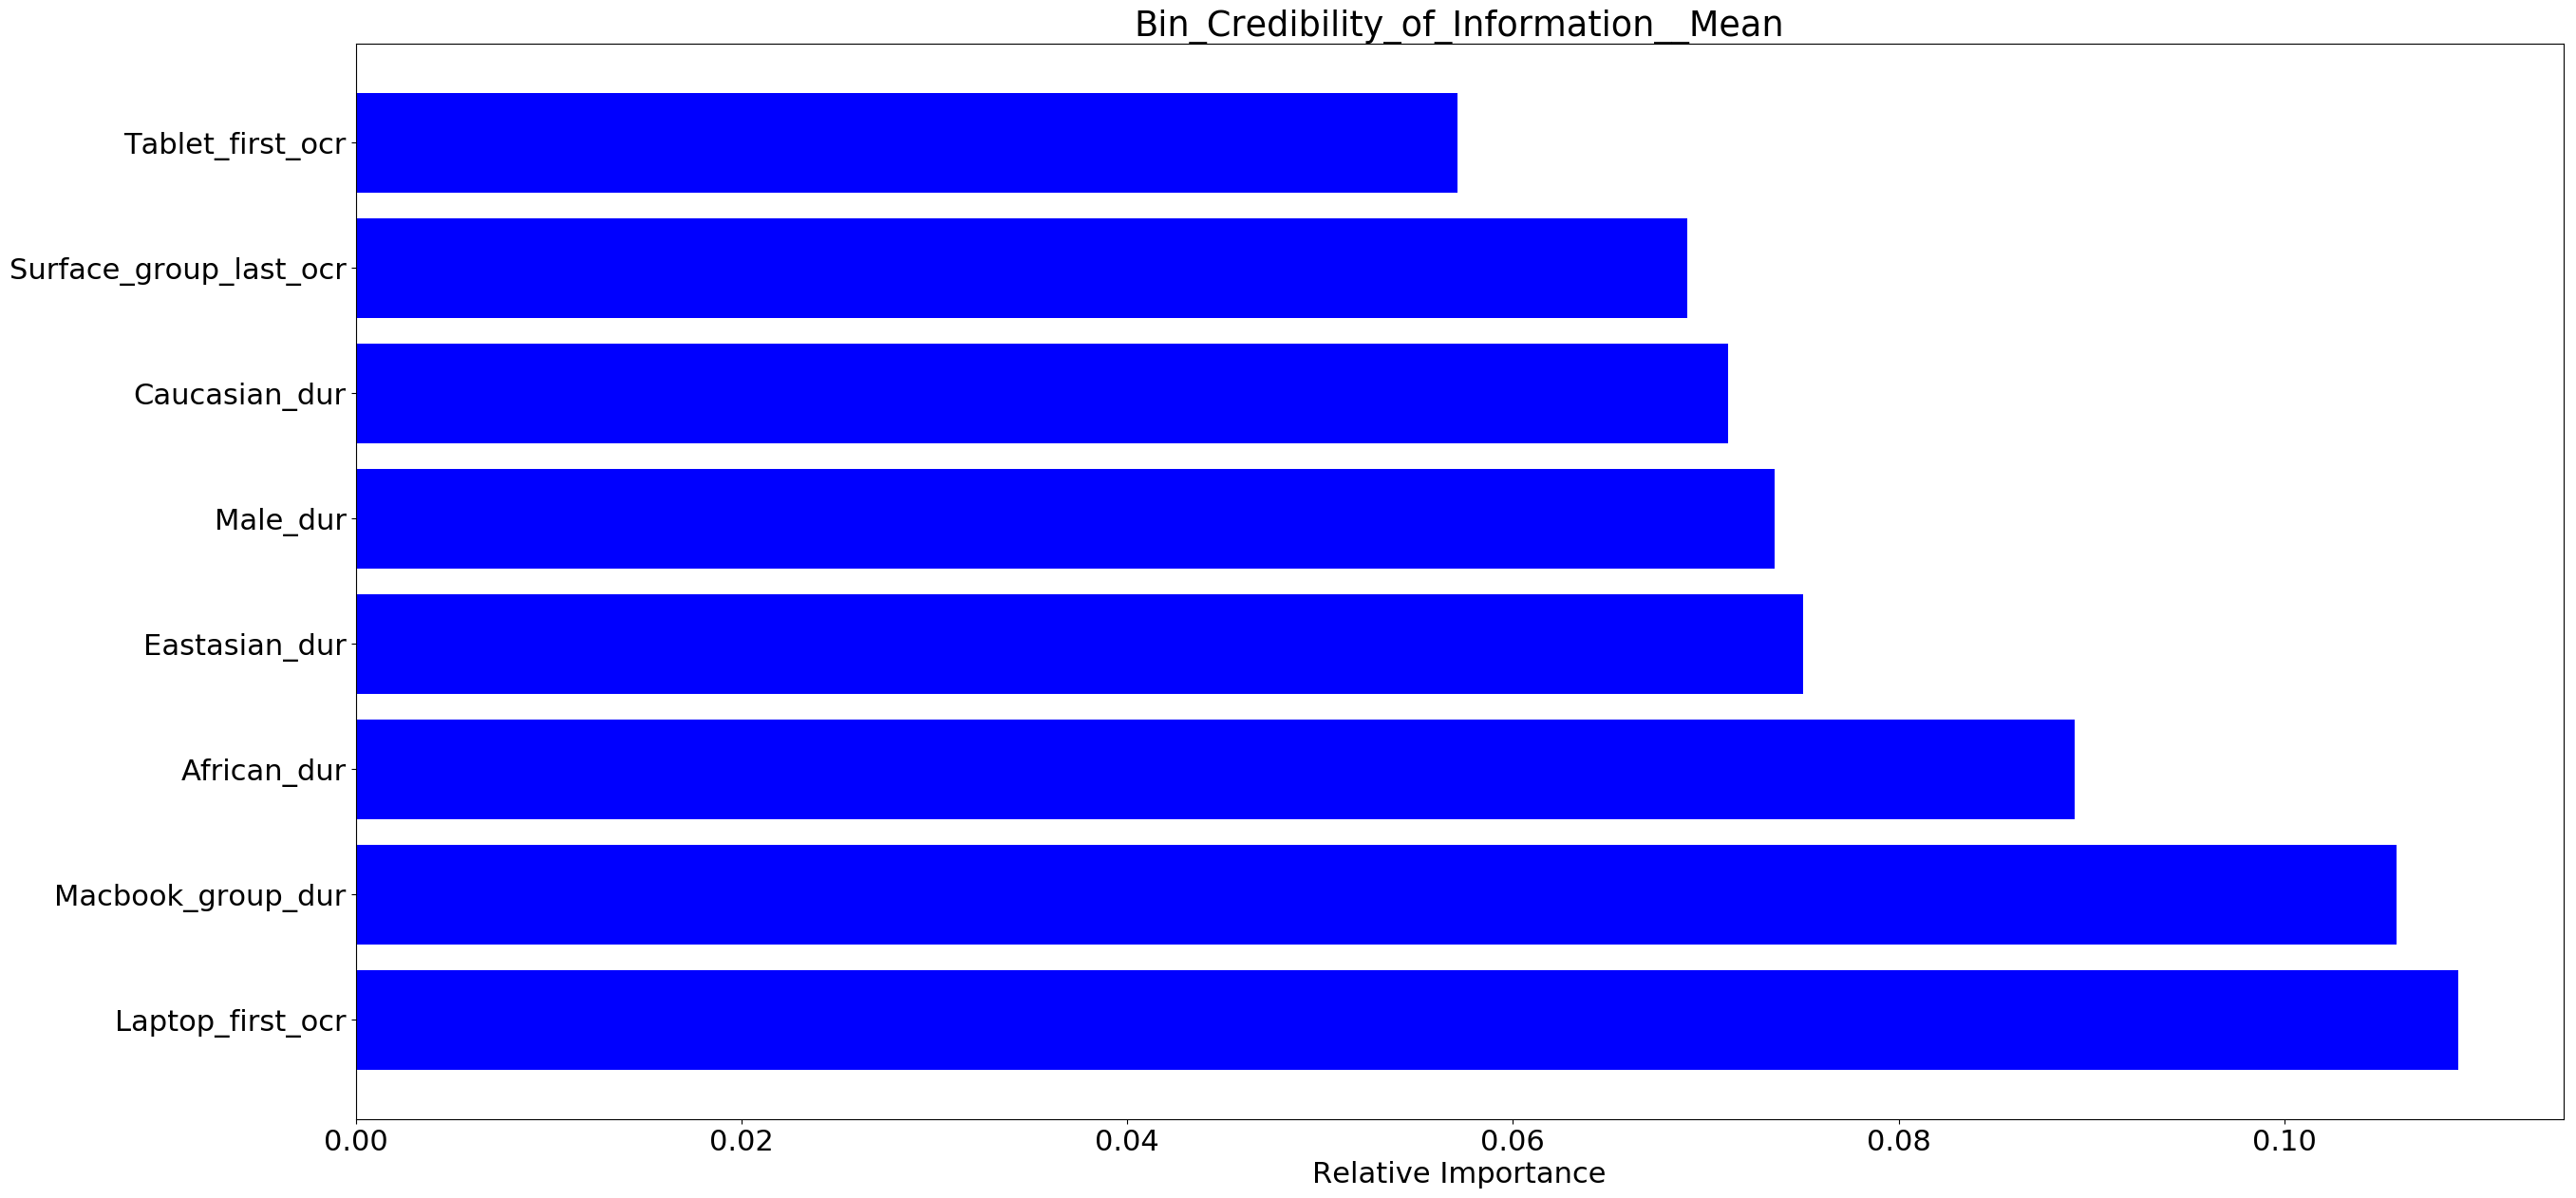

Bin_Brand_Difference__Mean
Feature ranking:
Surface_group_last_ocr
Surface_group_first_ocr
Tablet_first_ocr
Surface_group_dur
microsoft_first_ocr
Age: 25-34_dur
Neutral_dur
microsoft_last_ocr
Laptop_last_ocr
African_dur
length_of_ad_15
Macbook_group_dur


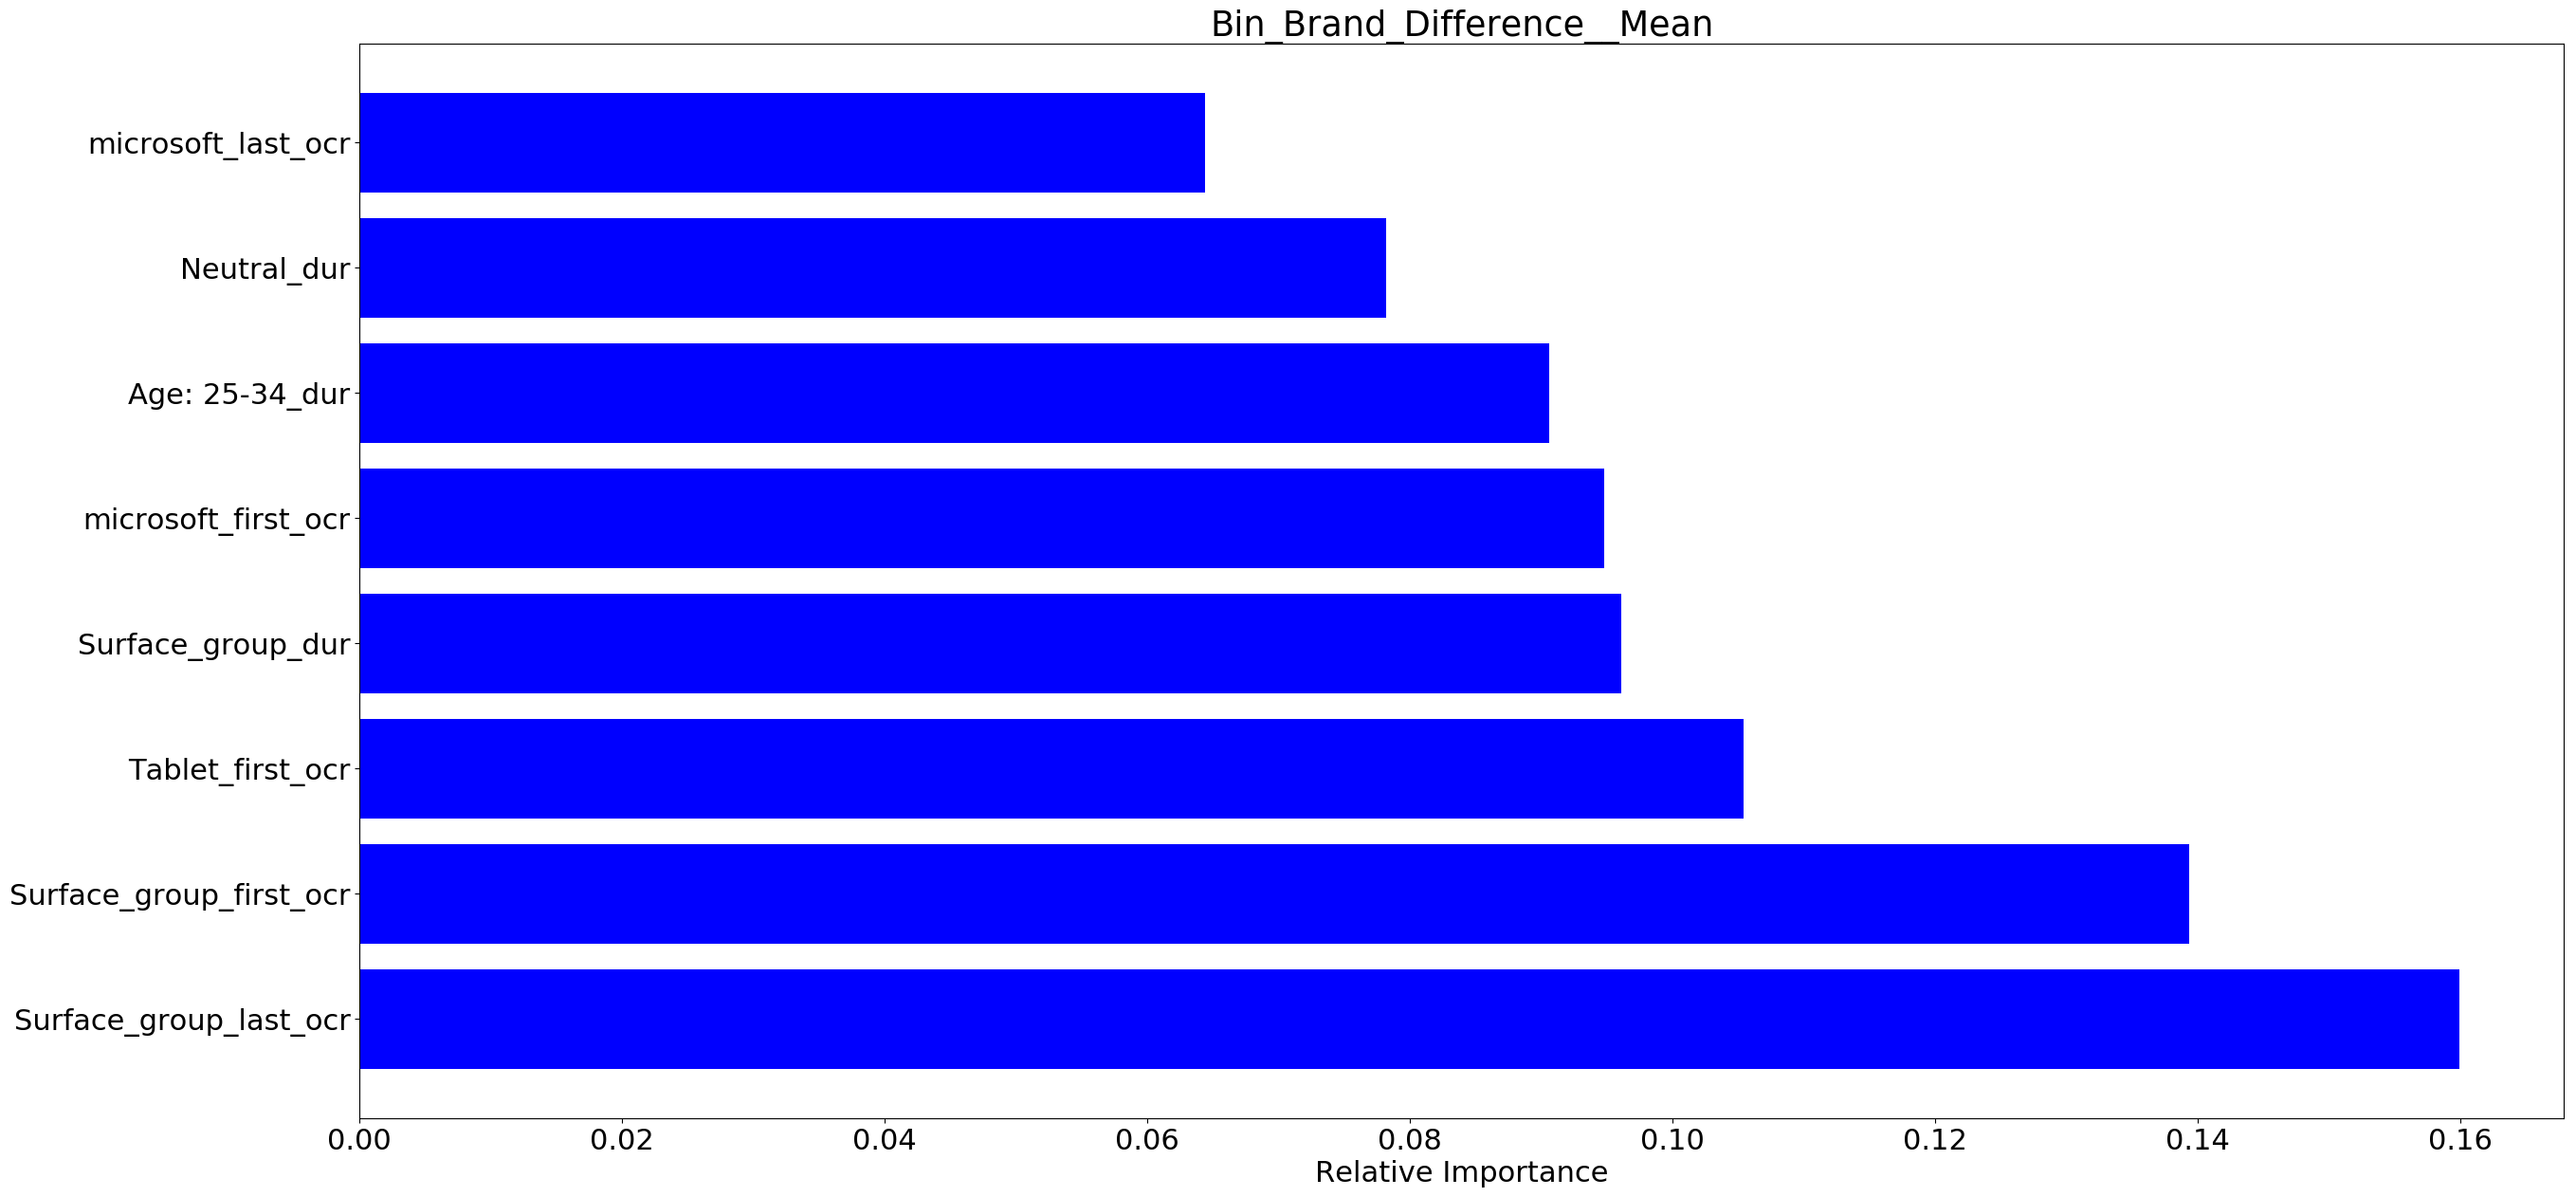

array([array(['microsoft_first_ocr', 'Laptop_first_ocr', 'microsoft_last_ocr',
       'Surface_group_dur', 'length_of_ad_15', 'Caucasian_dur',
       'Surface_group_total_ocr', 'Female_dur', 'microsoft_dur',
       'Sadness_dur', 'Laptop_last_ocr', 'Surface_group_last_ocr'],
      dtype=object),
       array(['Laptop_total_ocr', 'microsoft_first_ocr', 'Laptop_first_ocr',
       'Eastasian_dur', 'Surface_group_last_ocr',
       'Surface_group_first_ocr', 'Caucasian_dur', 'Neutral_dur',
       'African_dur', 'Laptop_dur', 'Laptop_last_ocr',
       'microsoft_last_ocr', 'Macbook_group_dur'], dtype=object),
       array(['Laptop_total_ocr', 'Surface_group_last_ocr',
       'Surface_group_first_ocr', 'microsoft_first_ocr',
       'Laptop_last_ocr', 'Tablet_total_ocr', 'Laptop_dur',
       'Tablet_last_ocr', 'Tablet_first_ocr', 'microsoft_last_ocr',
       'Tablet_dur', 'African_dur', 'Macbook_group_dur',
       'length_of_ad_15'], dtype=object),
       array(['microsoft_last_ocr', 'Surface_

In [58]:
model_rf_set.plot_feature_importance(m_rf_set,10,Y.columns,x_train_set,savefig=False)

In [59]:
model_rf_set.evaluate(x_train_set,y_train_set,m_rf_set,metrics='accuracy')

Bin_Unaided_Branding
[1. 1. 1.] 

Bin_Brand_Cues__Mean
[1. 1. 1.] 

Bin_Aided_Branding__Mean
[1. 1. 1.] 

Bin_Active_Involvement__Mean


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[1. 1. 1.] 

Bin_New_Information__Mean
[1. 1. 1.] 

Bin_Enjoyment__Mean
[1. 1. 1.] 

Bin_Brand_Appeal__Mean


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[1. 1. 1.] 

Bin_Understanding__Mean
[1. 1. 1.] 

Bin_Relevance_of_Information__Mean
[1. 1. 1.] 

Bin_Credibility_of_Information__Mean
[1. 1. 1.] 

Bin_Brand_Difference__Mean
[1. 1. 1.] 



[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


In [60]:
model_xgb_set = Model('xgb','class')
print("------------------------ 11 Models XGB Training ----------------------------\n")
models_xgb_11_set=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_xgb_11_set.append(model_xgb_set.train(x_train_set[i],y_train_set[i],x_test_set[i],y_test_set[i],metrics='accuracy',plot_error=False))

------------------------ 11 Models XGB Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


For training set
accuracy_score: 0.986904
For test set
accuracy_score: 0.983333


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
accuracy_score: 0.985671
For test set
accuracy_score: 0.994444


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
accuracy_score: 0.971471
For test set
accuracy_score: 0.986111


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
accuracy_score: 0.994033
For test set
accuracy_score: 0.991667


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


For training set
accuracy_score: 0.994062
For test set
accuracy_score: 0.994444


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
accuracy_score: 0.986912
For test set
accuracy_score: 0.994444


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


For training set
accuracy_score: 0.990504
For test set
accuracy_score: 0.988889


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


For training set
accuracy_score: 0.996428
For test set
accuracy_score: 1.000000


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
accuracy_score: 0.985714
For test set
accuracy_score: 0.983333


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


For training set
accuracy_score: 0.991688
For test set
accuracy_score: 0.997222


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


For training set
accuracy_score: 0.970229
For test set
accuracy_score: 0.988889




In [61]:
m_xgb_set = [m[0] for m in models_xgb_11_set]
model_xgb_set.evaluate(x_test_set,y_test_set,m_xgb_set,metrics='accuracy')

Bin_Unaided_Branding
[1.   0.98 0.96] 

Bin_Brand_Cues__Mean
[0.98 1.   1.  ] 

Bin_Aided_Branding__Mean
[0.98 1.   0.98] 

Bin_Active_Involvement__Mean
[1.   0.99 0.98] 

Bin_New_Information__Mean
[0.99 1.   0.99] 

Bin_Enjoyment__Mean
[1.   0.99 0.99] 

Bin_Brand_Appeal__Mean
[1.   0.98 0.98] 

Bin_Understanding__Mean
[1. 1. 1.] 

Bin_Relevance_of_Information__Mean
[0.98 0.98 0.99] 

Bin_Credibility_of_Information__Mean
[1.   1.   0.99] 

Bin_Brand_Difference__Mean
[0.99 0.98 0.99] 



Bin_Unaided_Branding
length_of_ad_15
microsoft_first_ocr
microsoft_last_ocr
Surface_group_total_ocr
Laptop_first_ocr
Surface_group_dur
Laptop_last_ocr
Caucasian_dur
microsoft_dur
Surface_group_last_ocr
Sadness_dur
Female_dur


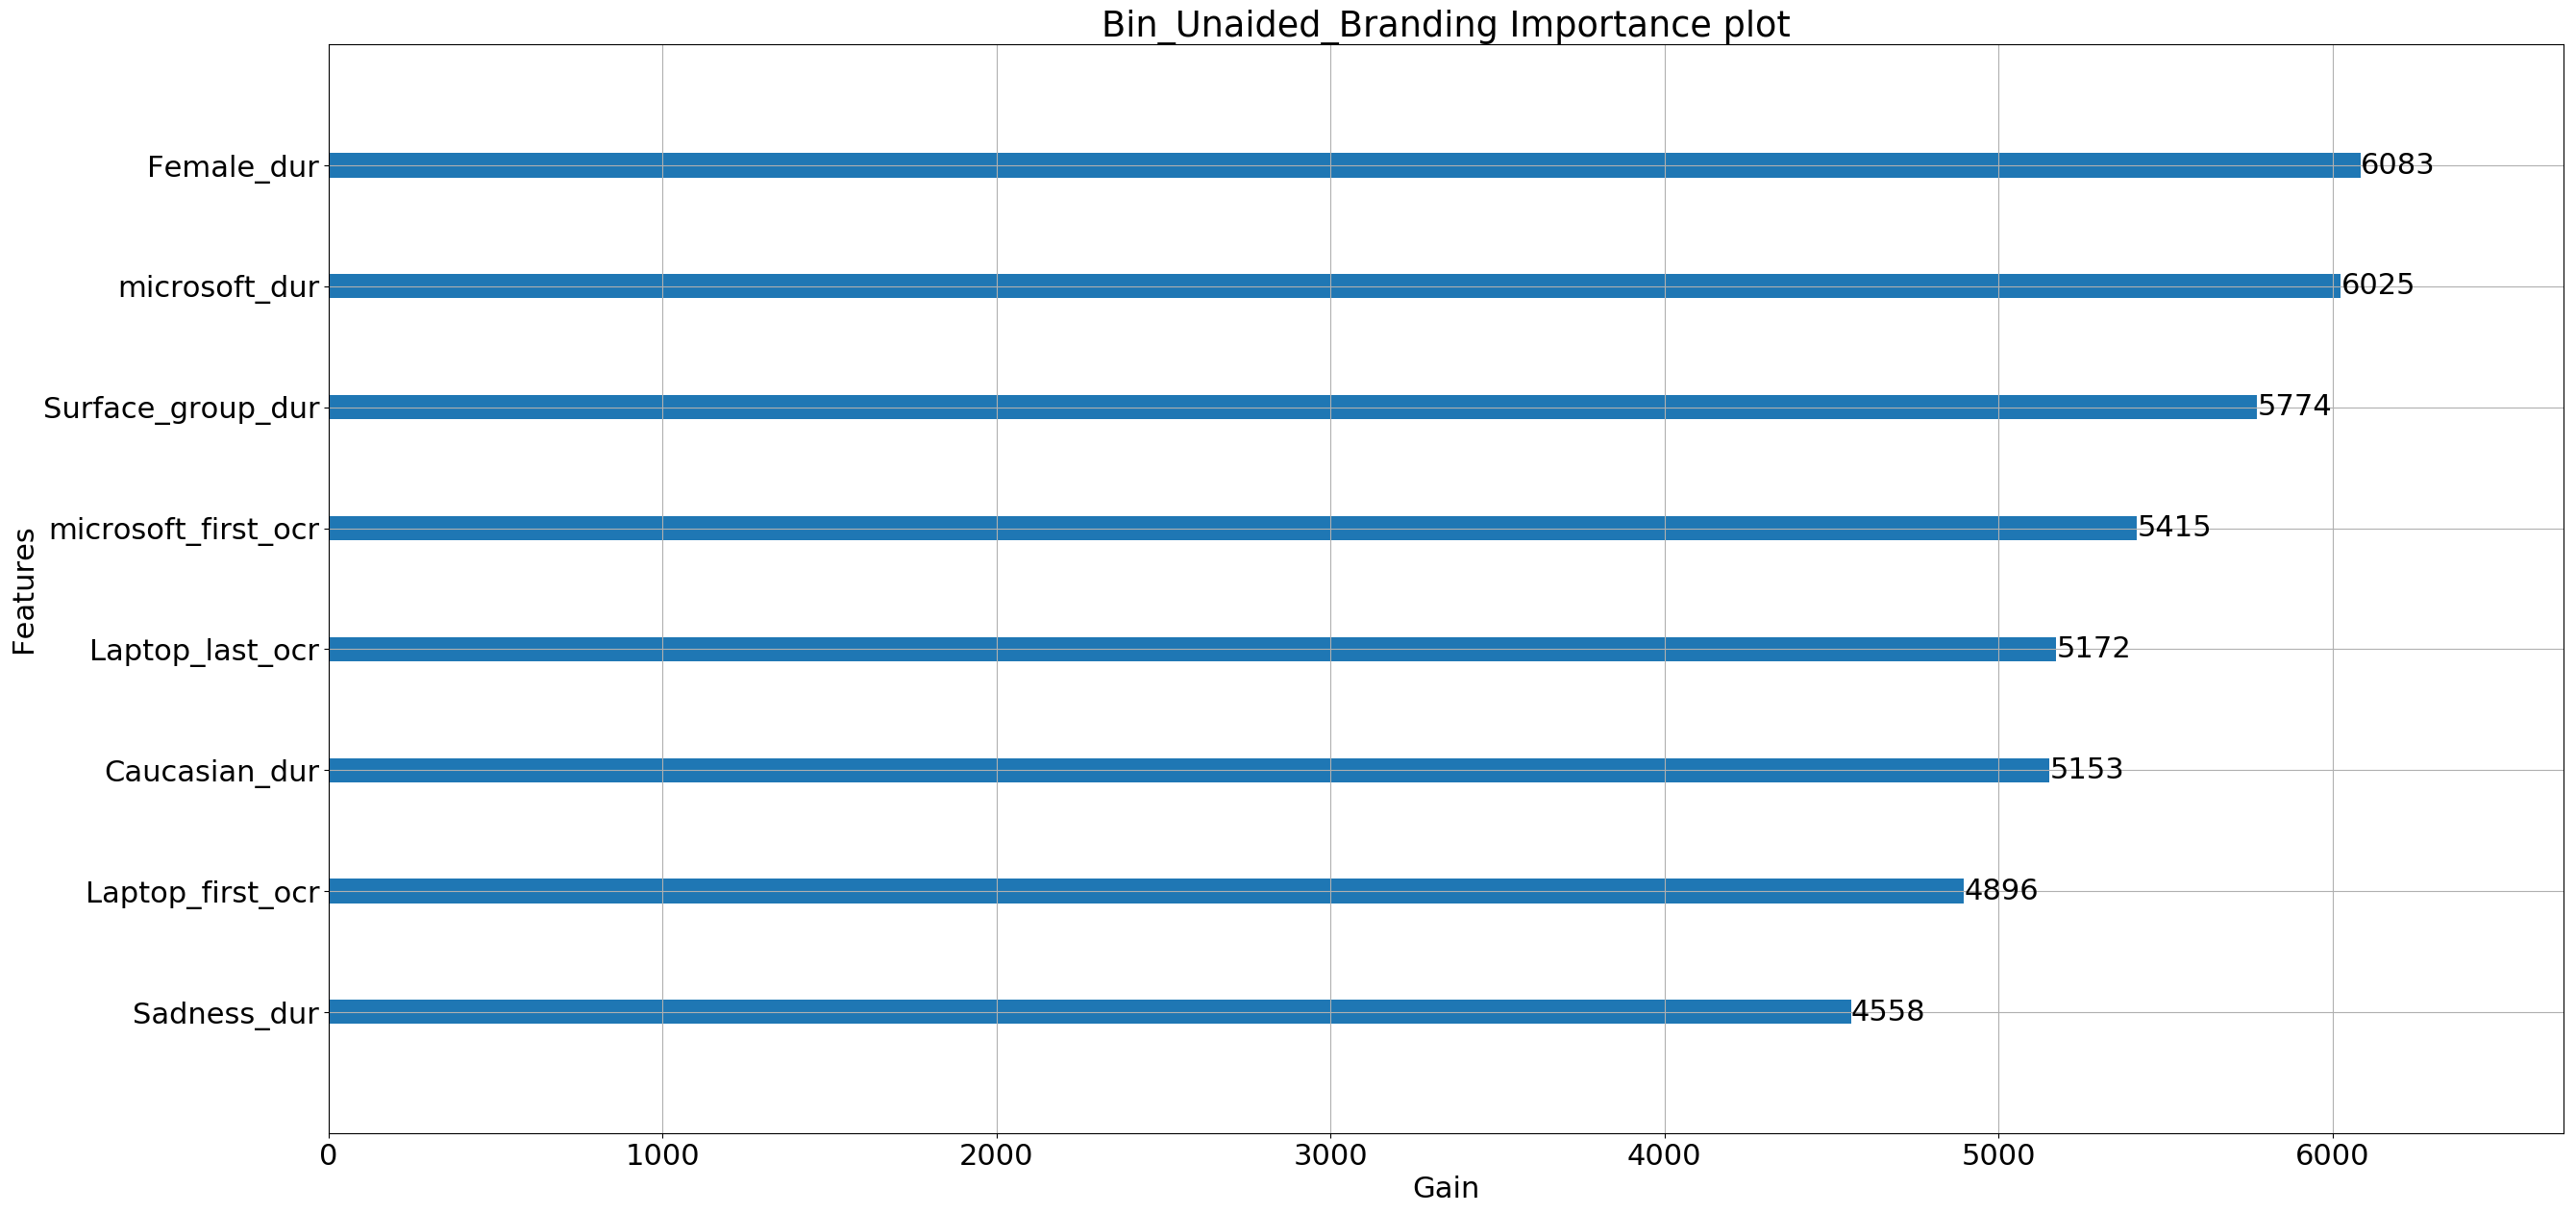

Bin_Brand_Cues__Mean
African_dur
Macbook_group_dur
microsoft_last_ocr
microsoft_first_ocr
Laptop_last_ocr
Laptop_total_ocr
Surface_group_last_ocr
Surface_group_first_ocr
Neutral_dur
Eastasian_dur
Laptop_first_ocr
Caucasian_dur
Laptop_dur


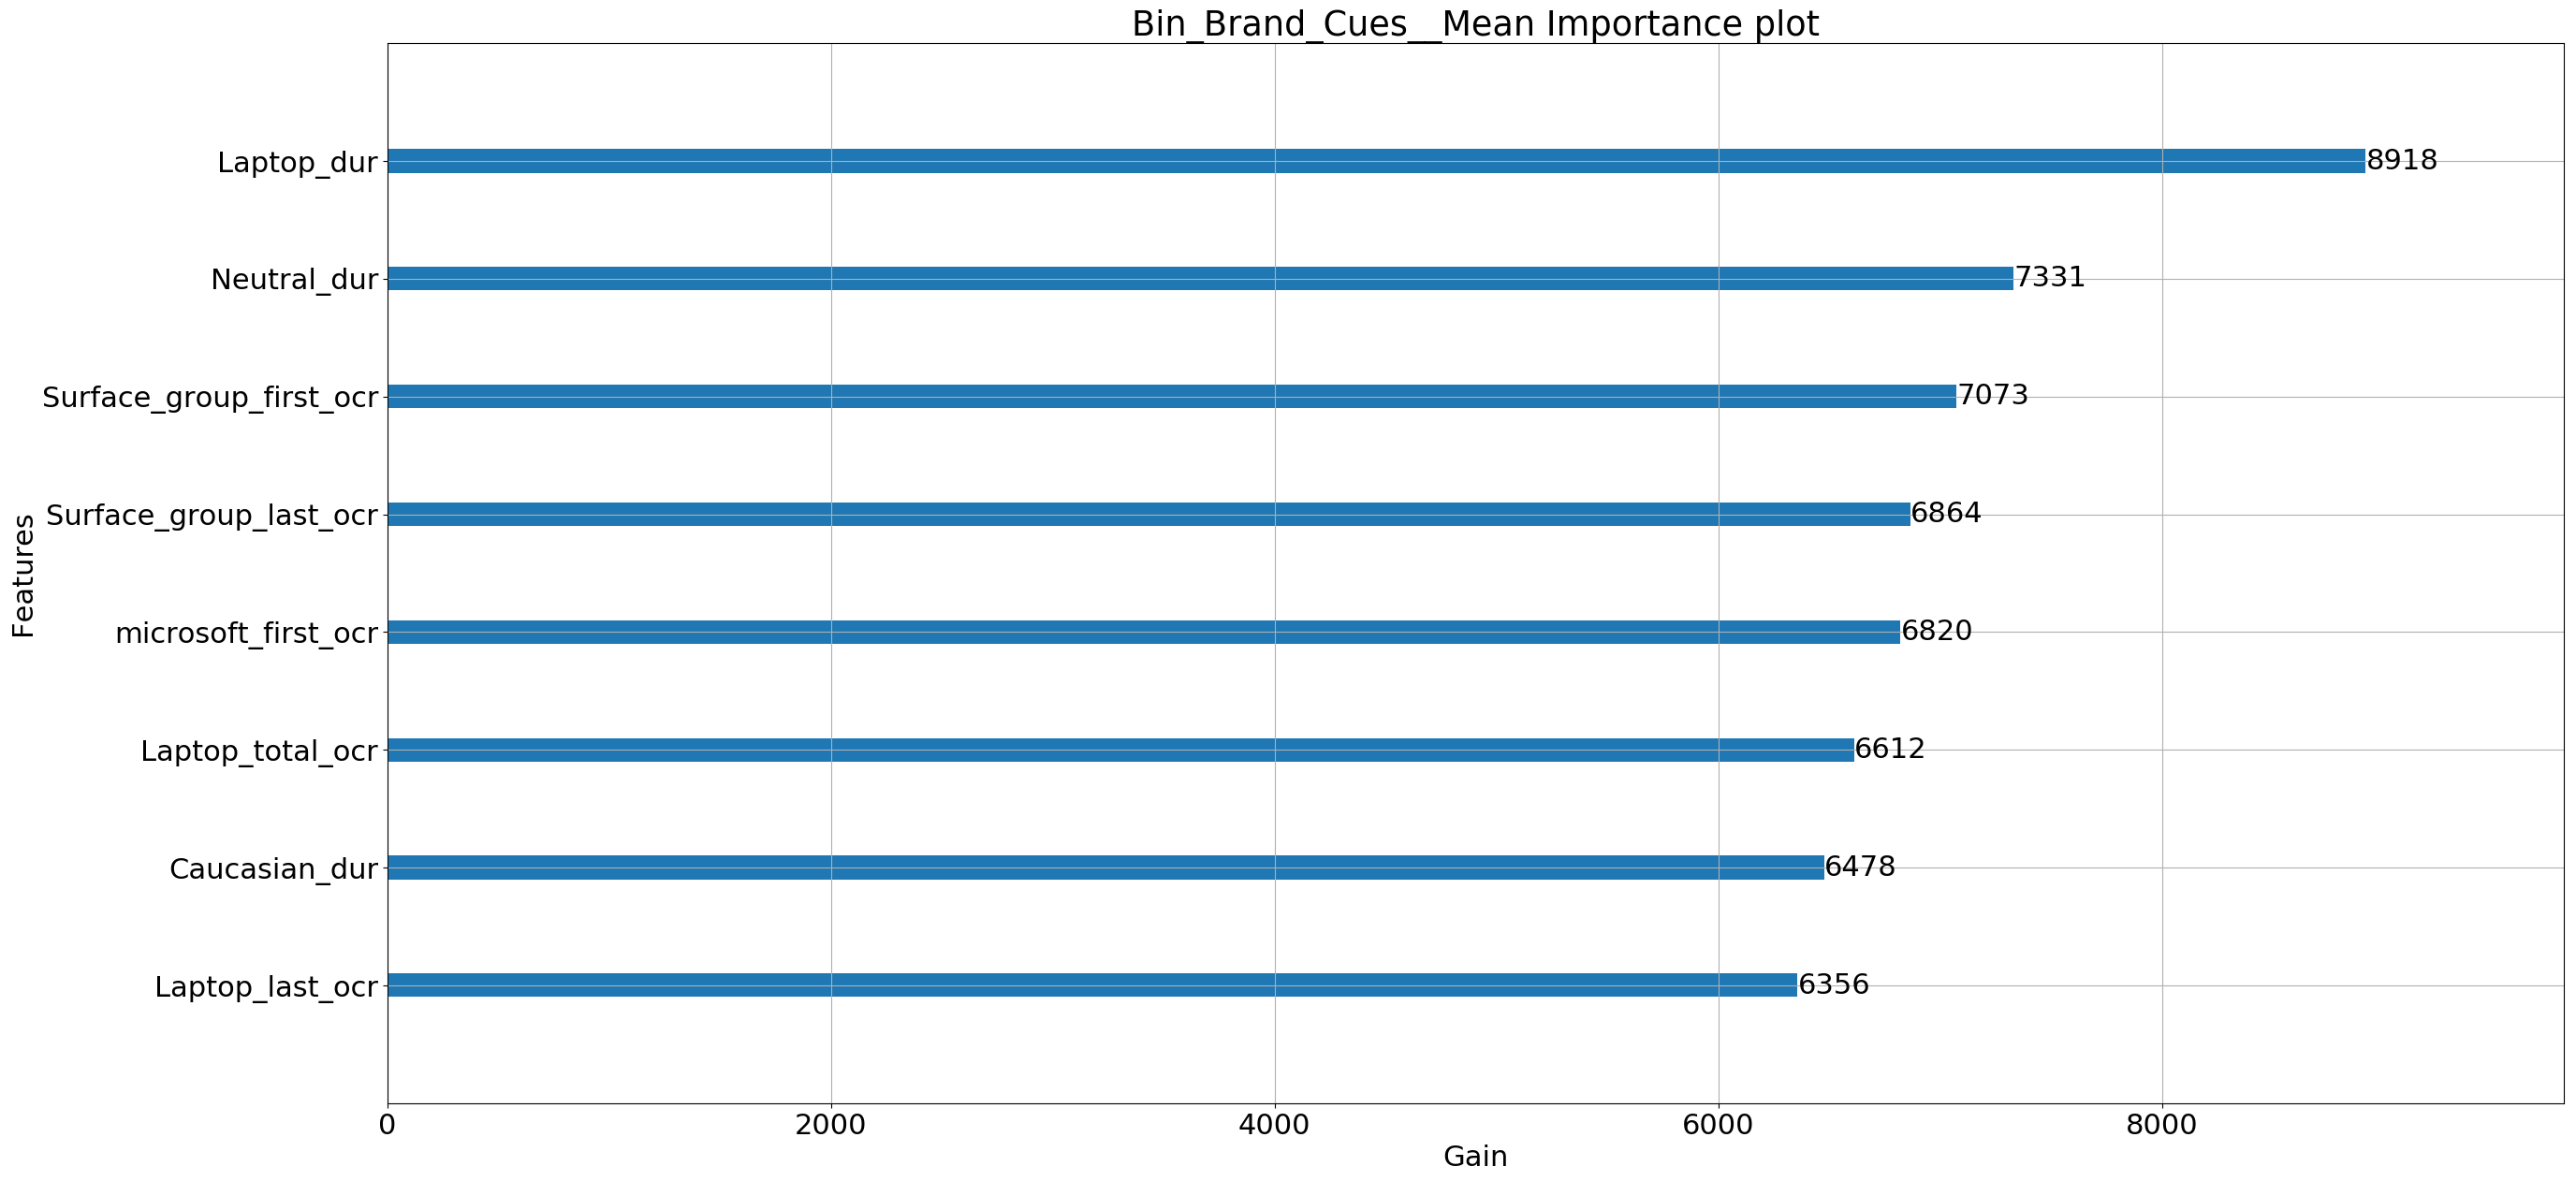

Bin_Aided_Branding__Mean
Tablet_last_ocr
length_of_ad_15
Macbook_group_dur
African_dur
Surface_group_last_ocr
microsoft_last_ocr
Laptop_last_ocr
Tablet_first_ocr
Tablet_total_ocr
Laptop_dur
Tablet_dur
Surface_group_first_ocr
Laptop_total_ocr
microsoft_first_ocr


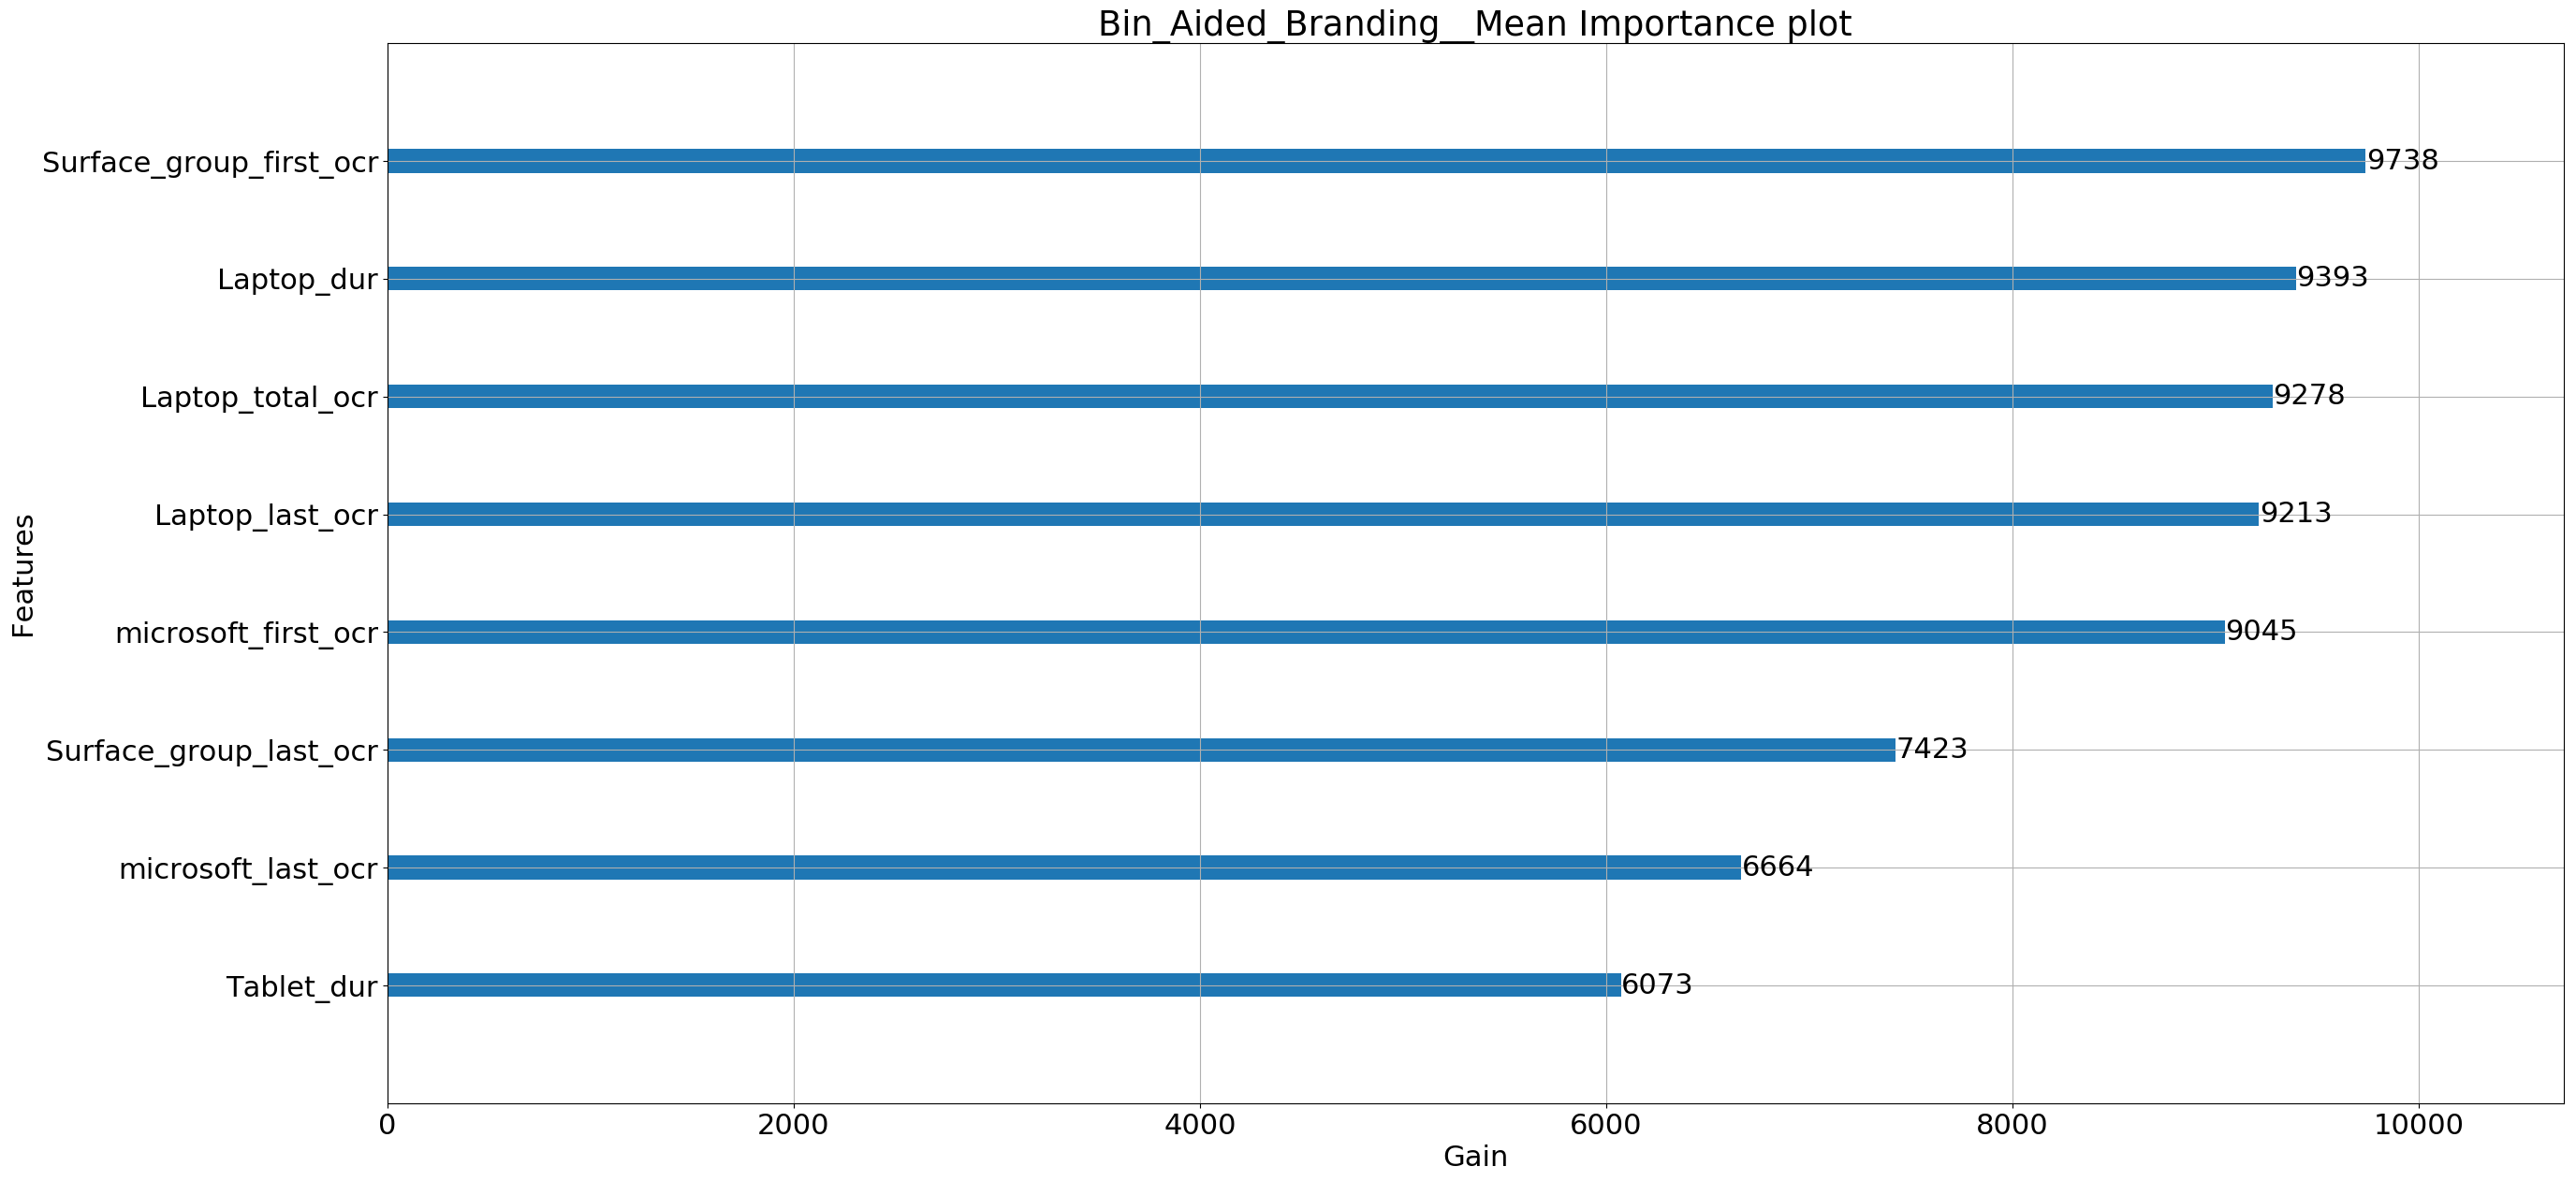

Bin_Active_Involvement__Mean
Surface_group_last_ocr
length_of_ad_15
microsoft_last_ocr
Tablet_dur
microsoft_first_ocr
Tablet_last_ocr
Tablet_total_ocr
Surface_group_dur
Eastasian_dur
Caucasian_dur
Laptop_last_ocr
Laptop_total_ocr
Surface_group_first_ocr
microsoft_total_ocr
microsoft_dur


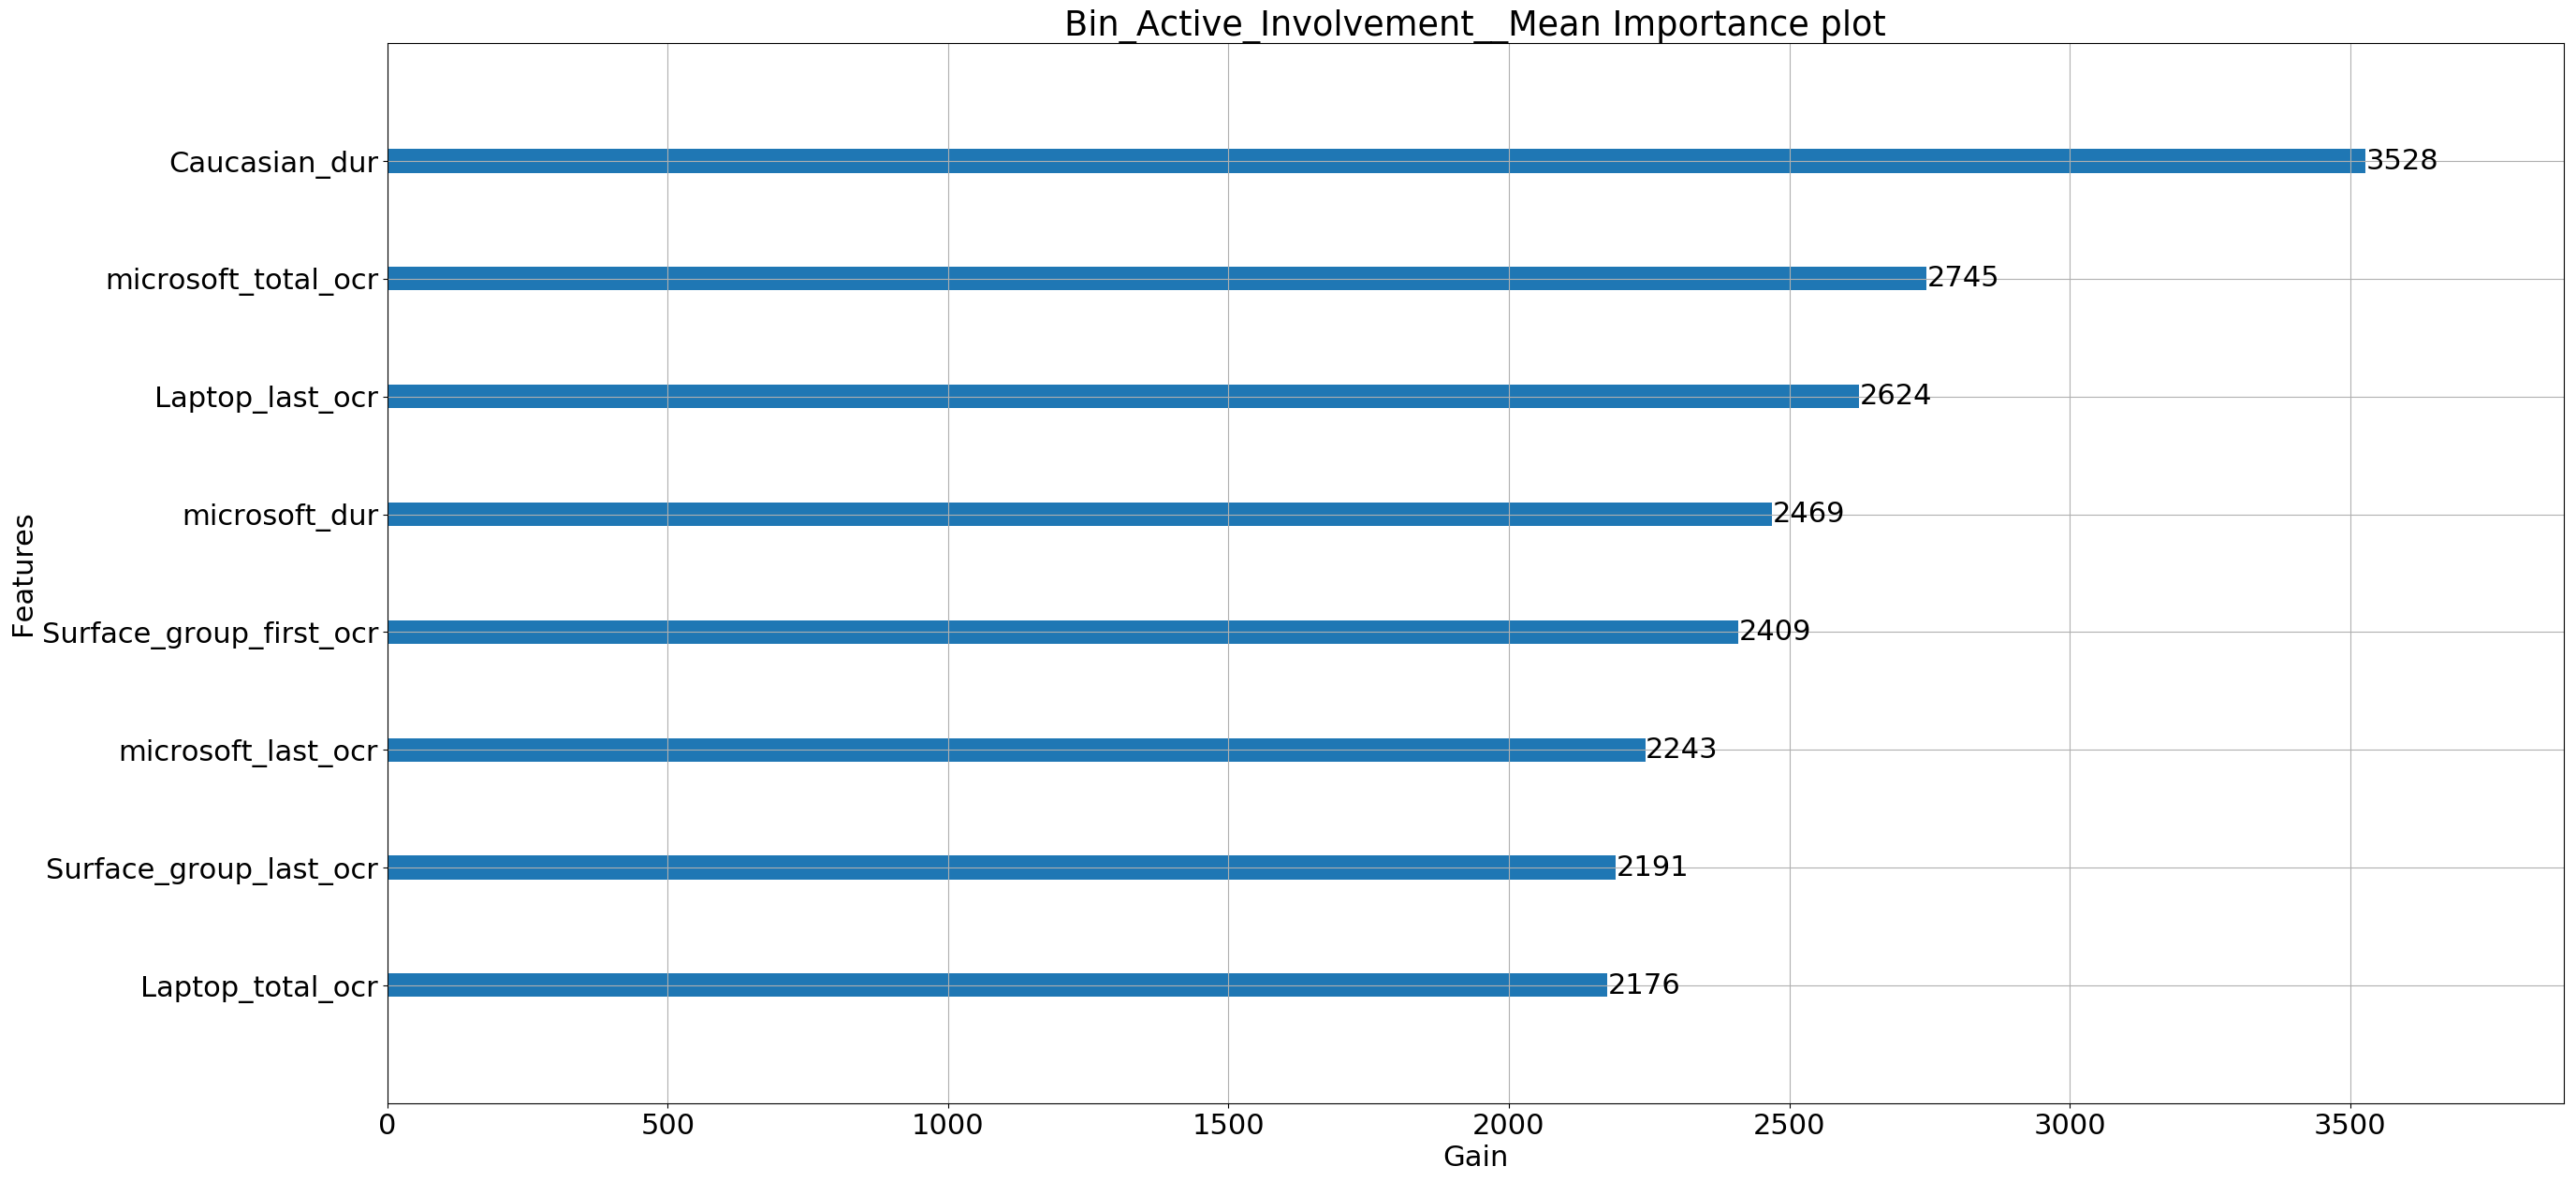

Bin_New_Information__Mean
Surface_group_total_ocr
African_dur
Surface_group_first_ocr
Tablet_total_ocr
Tablet_last_ocr
microsoft_last_ocr
Tablet_dur
microsoft_first_ocr
Surface_group_last_ocr
Tablet_first_ocr
Surface_group_dur
Neutral_dur
Sadness_dur
Happiness_dur


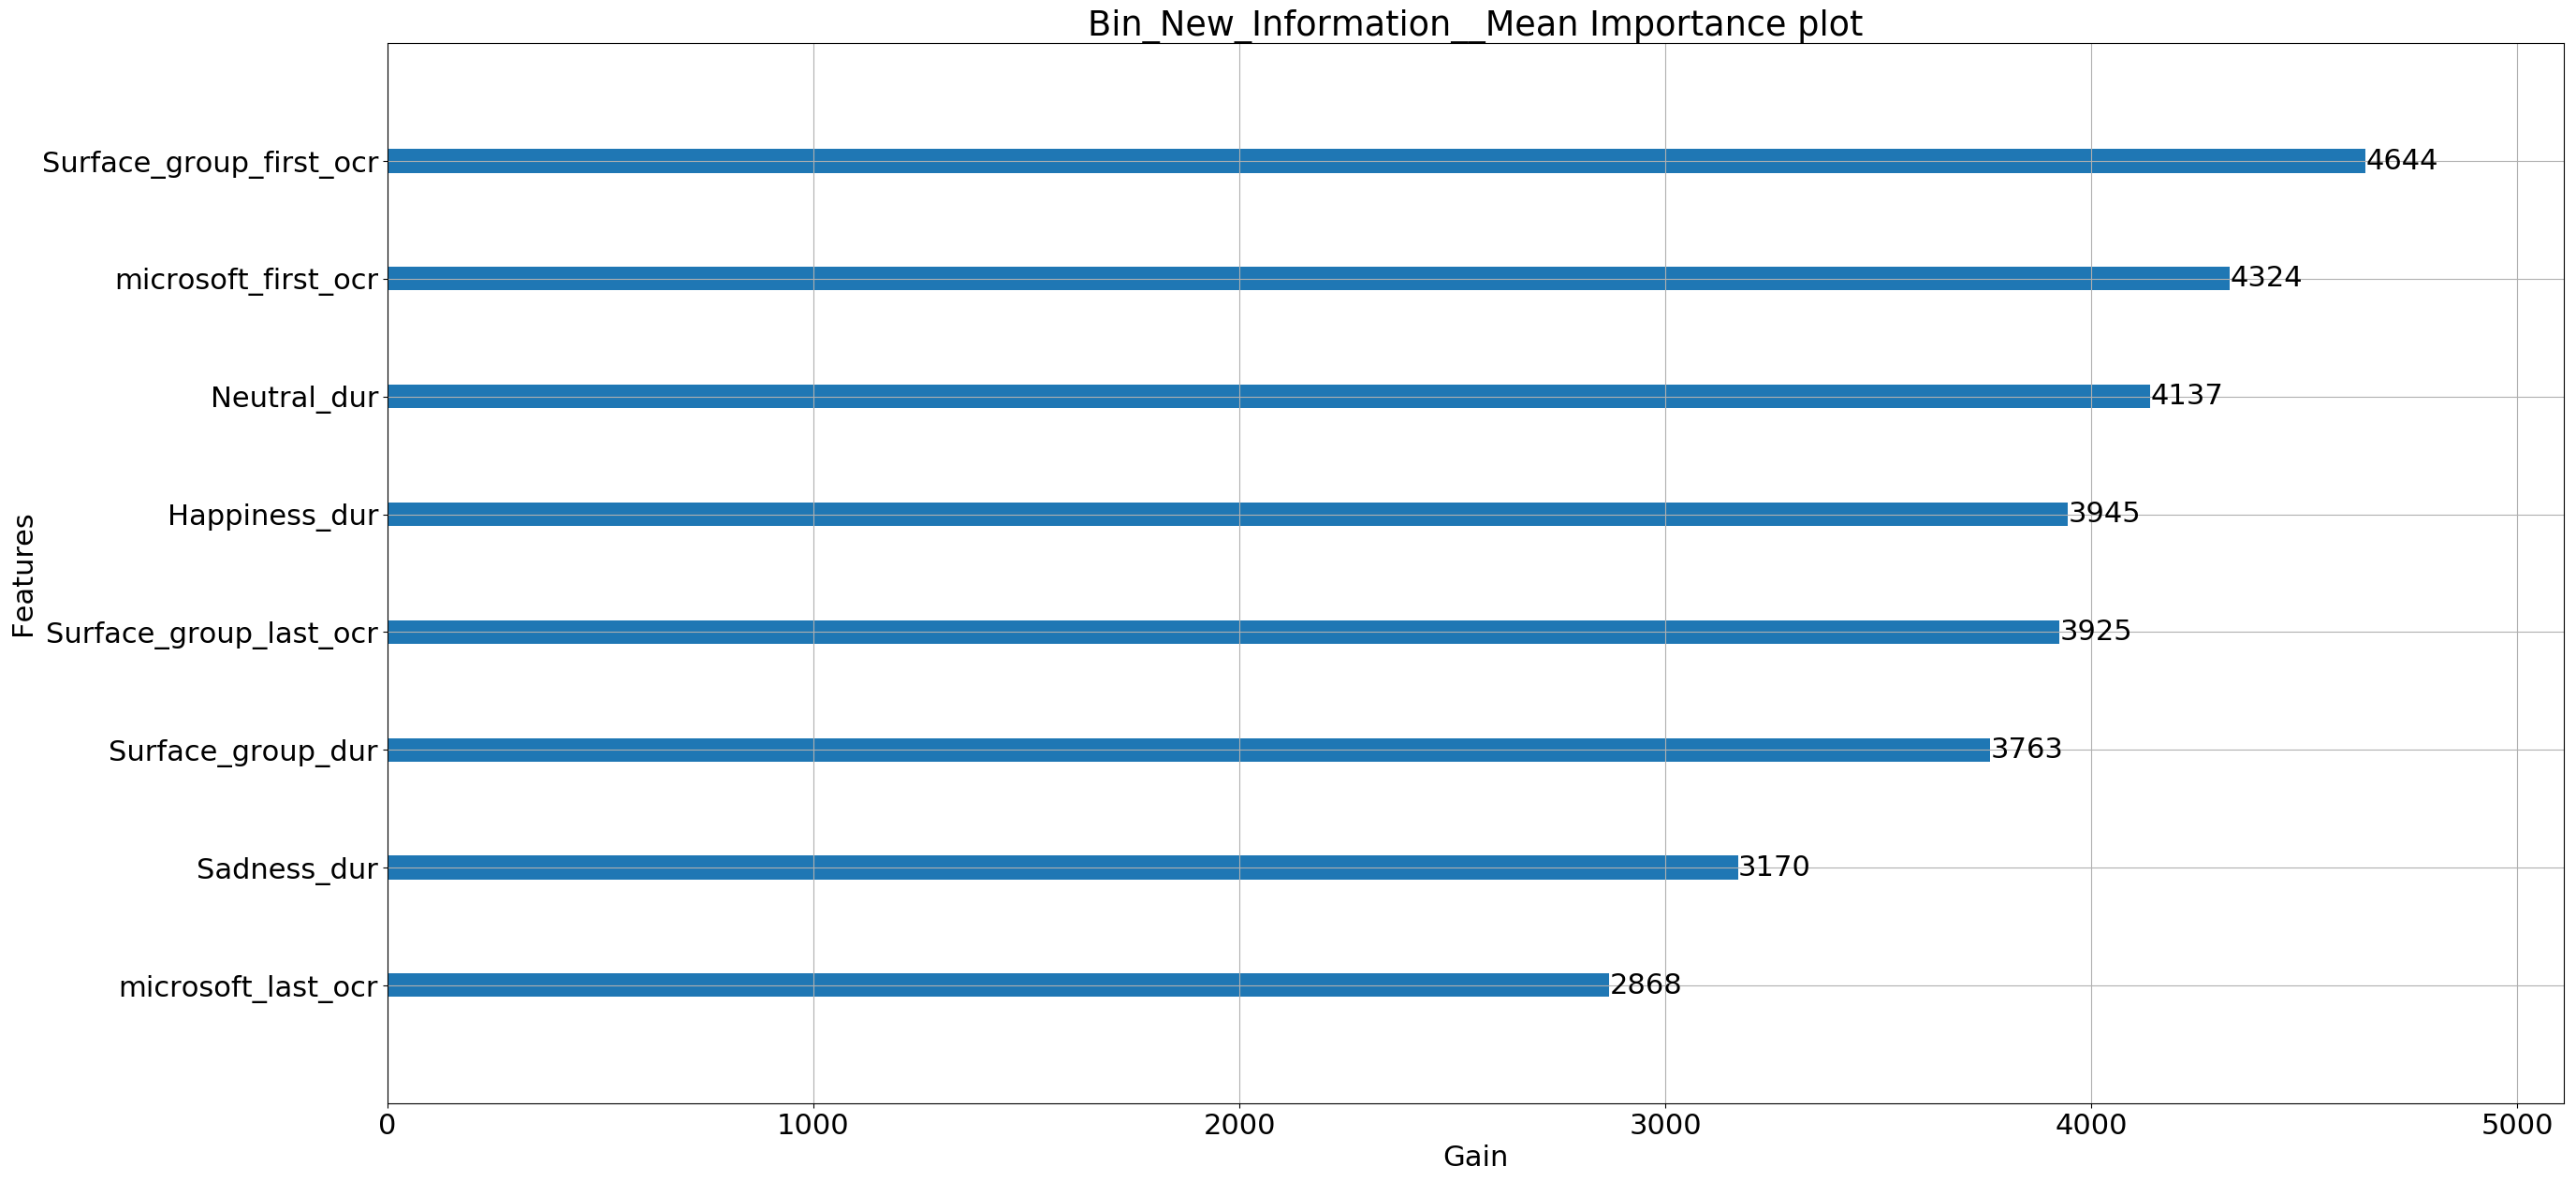

Bin_Enjoyment__Mean
Macbook_group_dur
length_of_ad_15
Neutral_dur
microsoft_last_ocr
microsoft_total_ocr
Surface_group_first_ocr
microsoft_dur
Laptop_dur
microsoft_first_ocr
Surface_group_dur
African_dur
Age: 25-34_dur


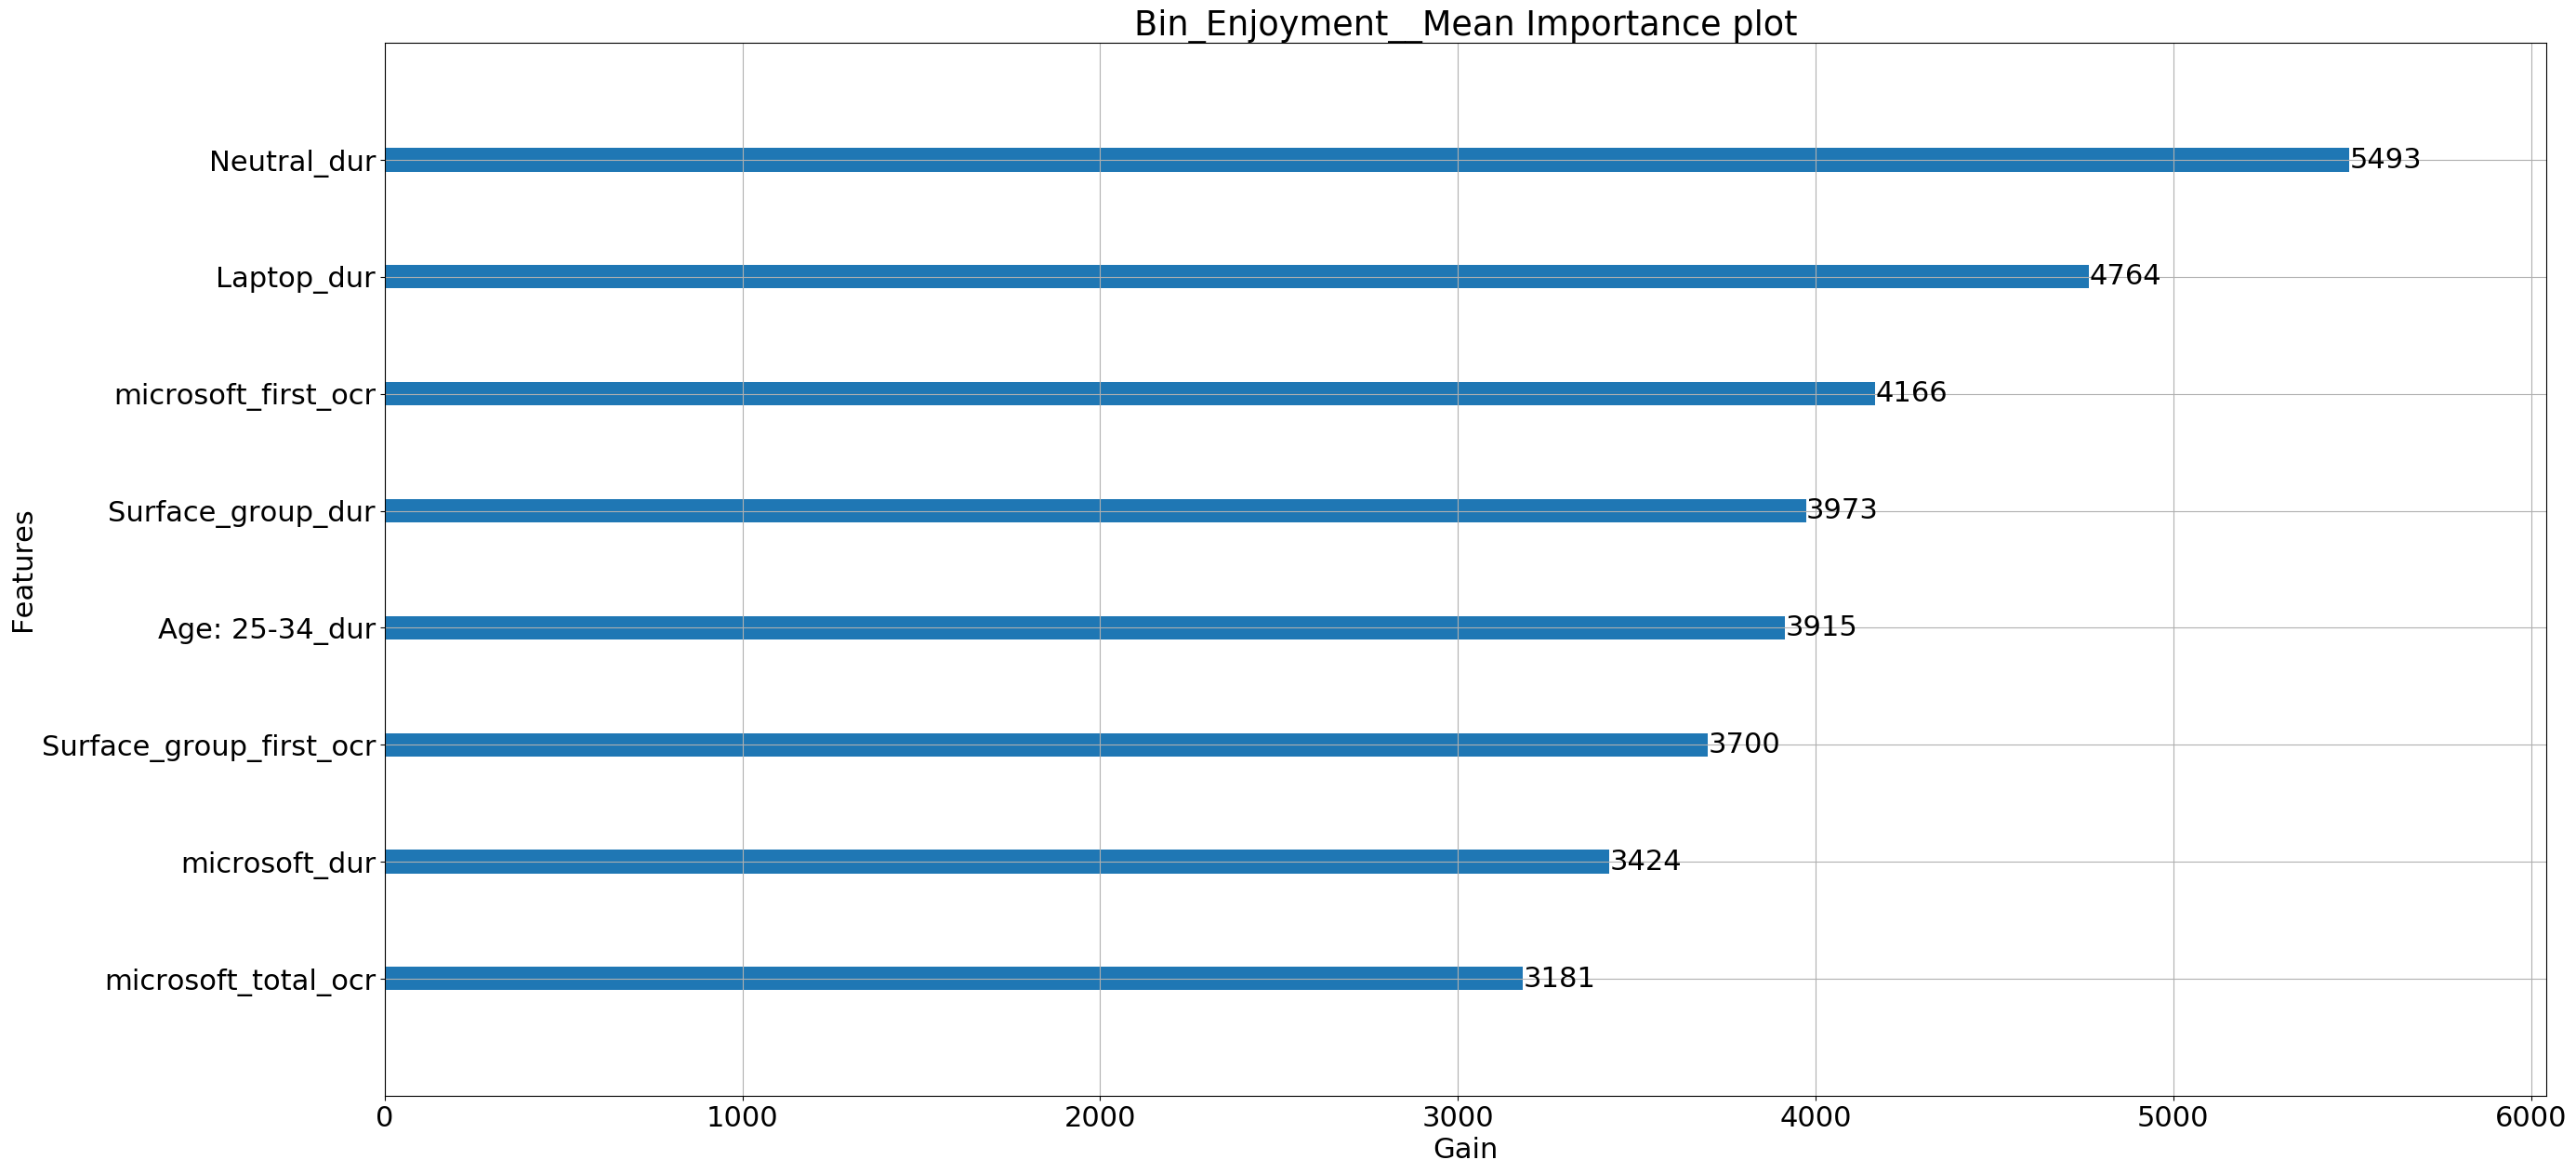

Bin_Brand_Appeal__Mean
African_dur
microsoft_first_ocr
Surface_group_last_ocr
Surface_group_total_ocr
Macbook_group_dur
Surface_group_dur
length_of_ad_15
Laptop_last_ocr
Neutral_dur
Female_dur
Tablet_first_ocr
microsoft_last_ocr
Caucasian_dur
microsoft_dur


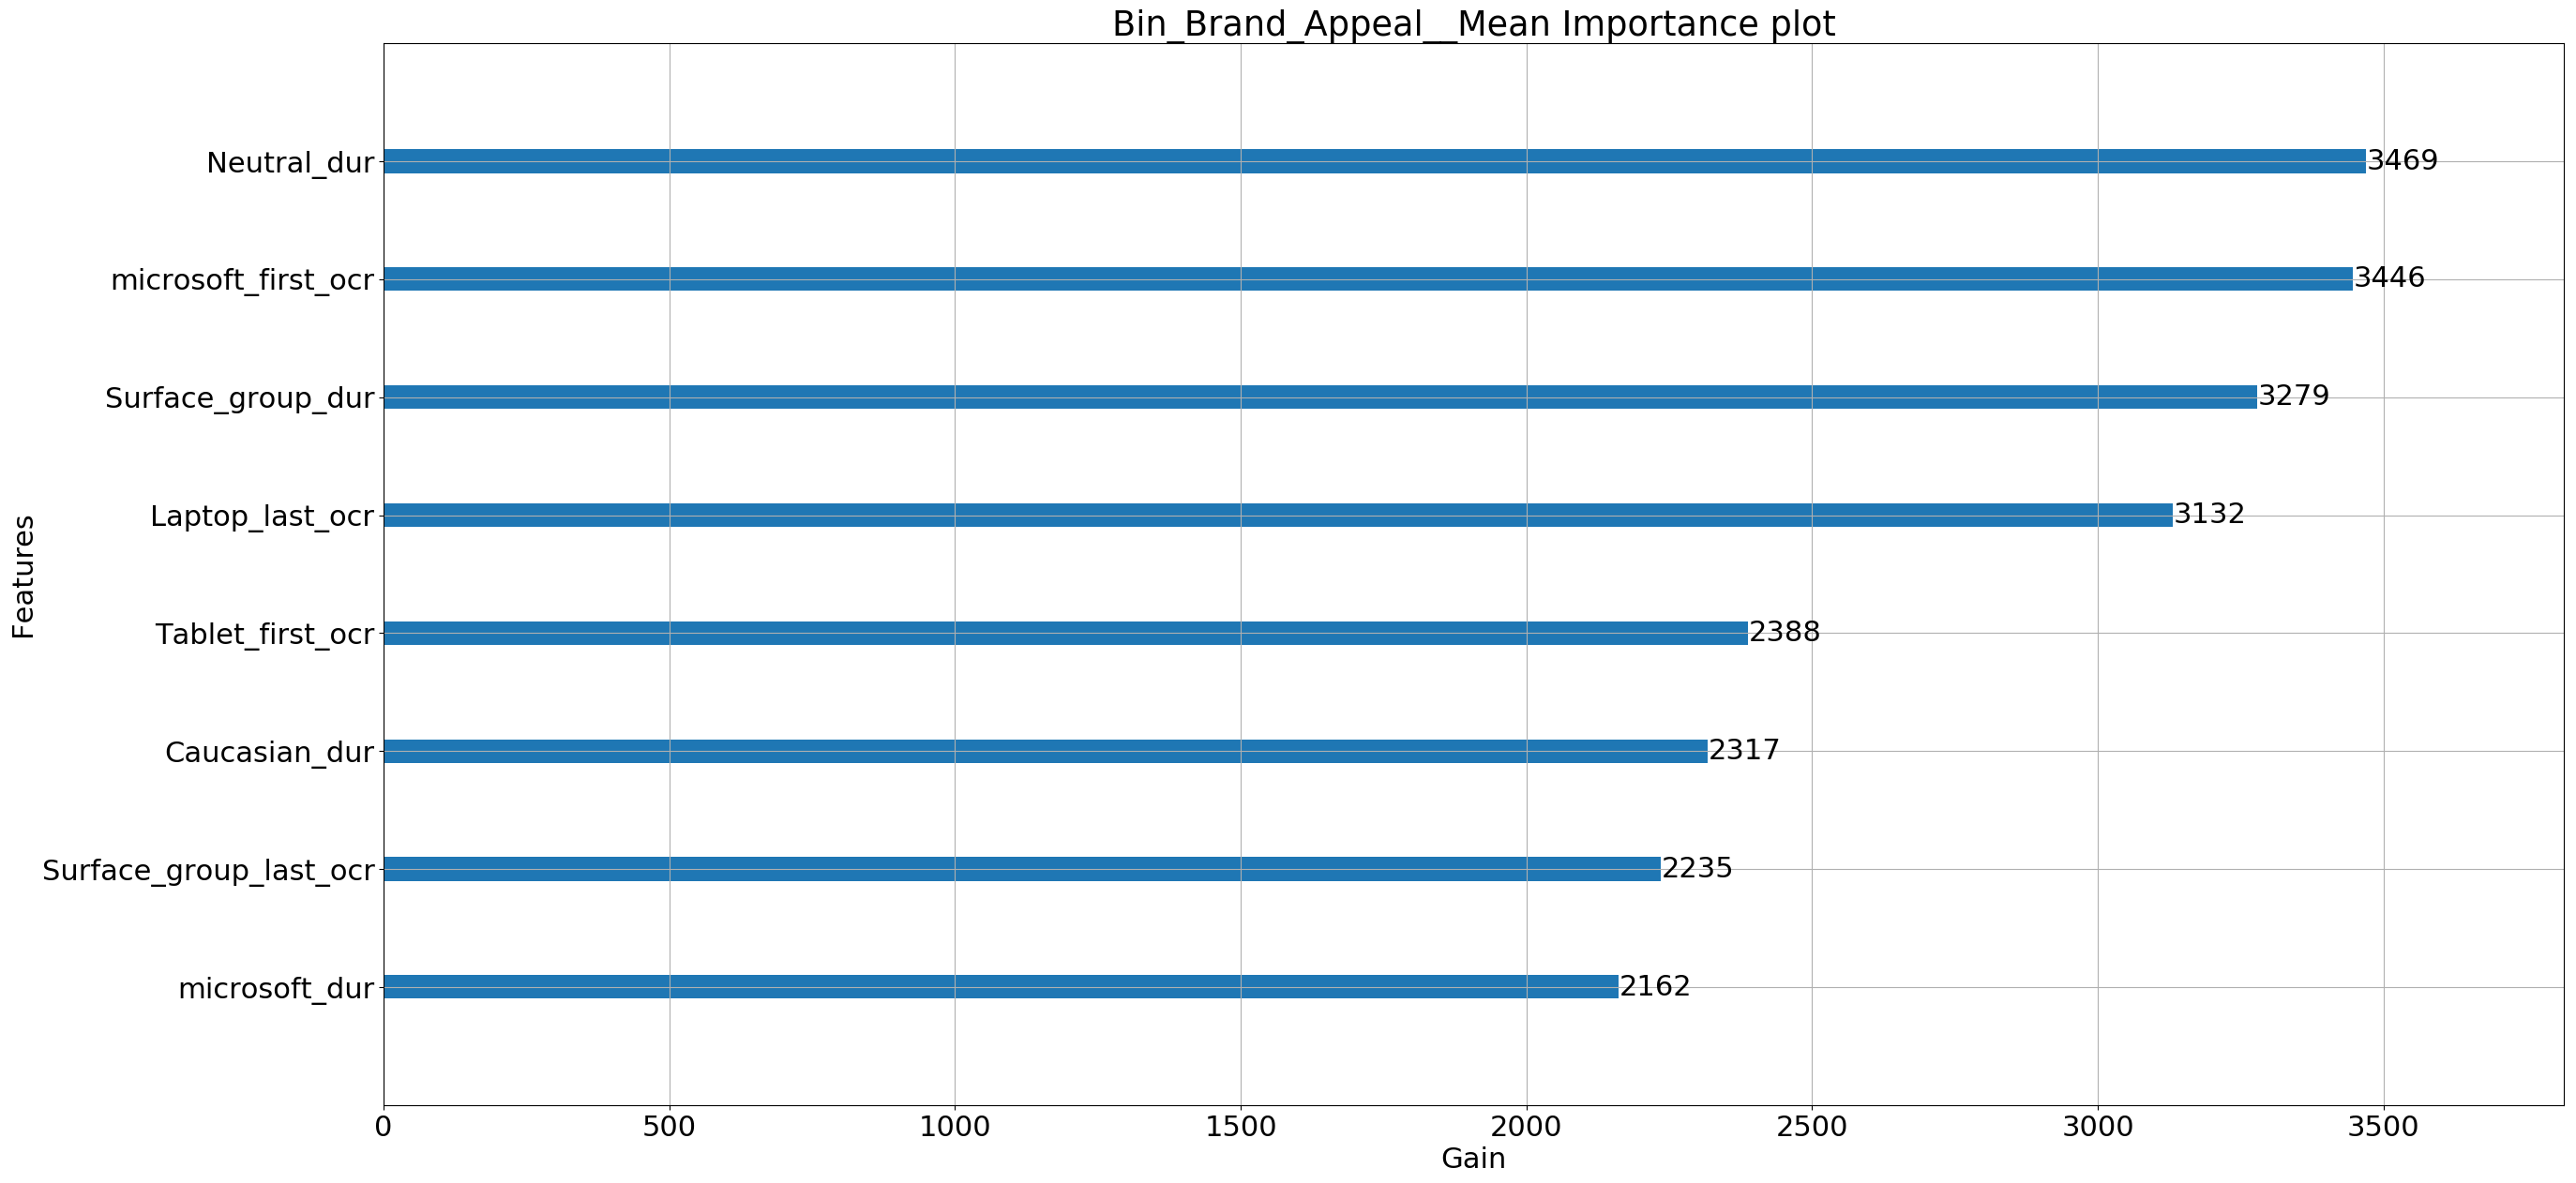

Bin_Understanding__Mean
African_dur
length_of_ad_15
Surface_group_total_ocr
Neutral_dur
microsoft_last_ocr
Tablet_last_ocr
Surface_group_dur
microsoft_first_ocr
microsoft_total_ocr
Laptop_first_ocr
Tablet_first_ocr
Laptop_last_ocr
Caucasian_dur
Male_dur
microsoft_dur
Female_dur


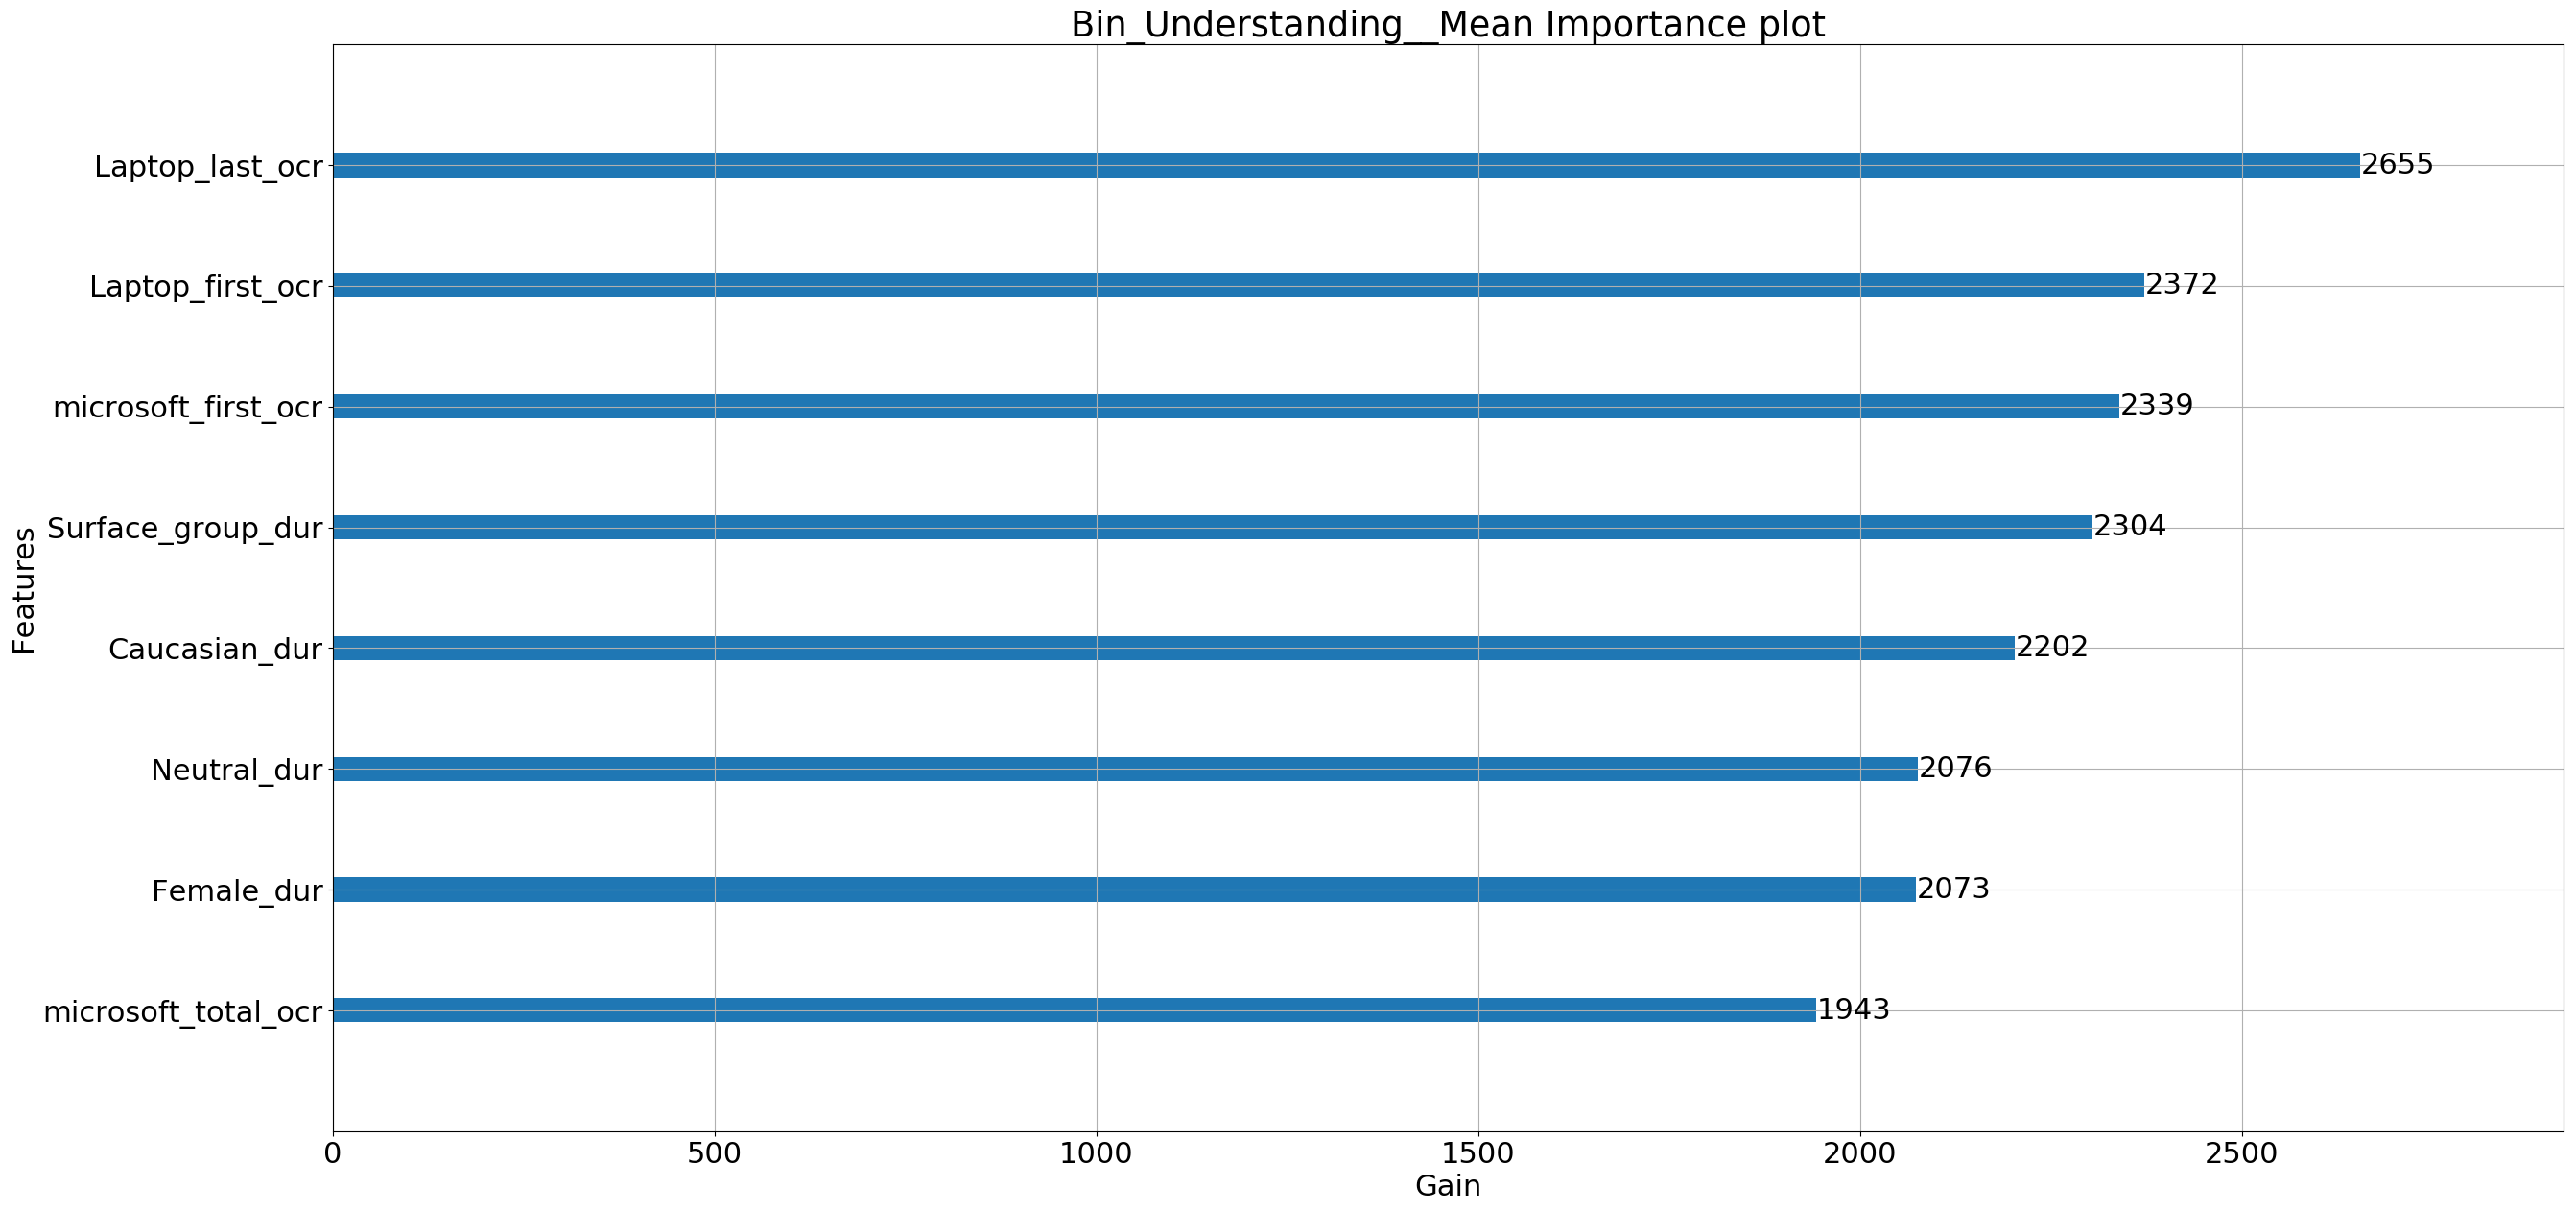

Bin_Relevance_of_Information__Mean
African_dur
Macbook_group_dur
Surface_group_last_ocr
microsoft_last_ocr
Tablet_dur
Tablet_last_ocr
microsoft_first_ocr
Tablet_first_ocr
Laptop_dur
Caucasian_dur
Male_dur
microsoft_dur
Age: 25-34_dur
Eastasian_dur


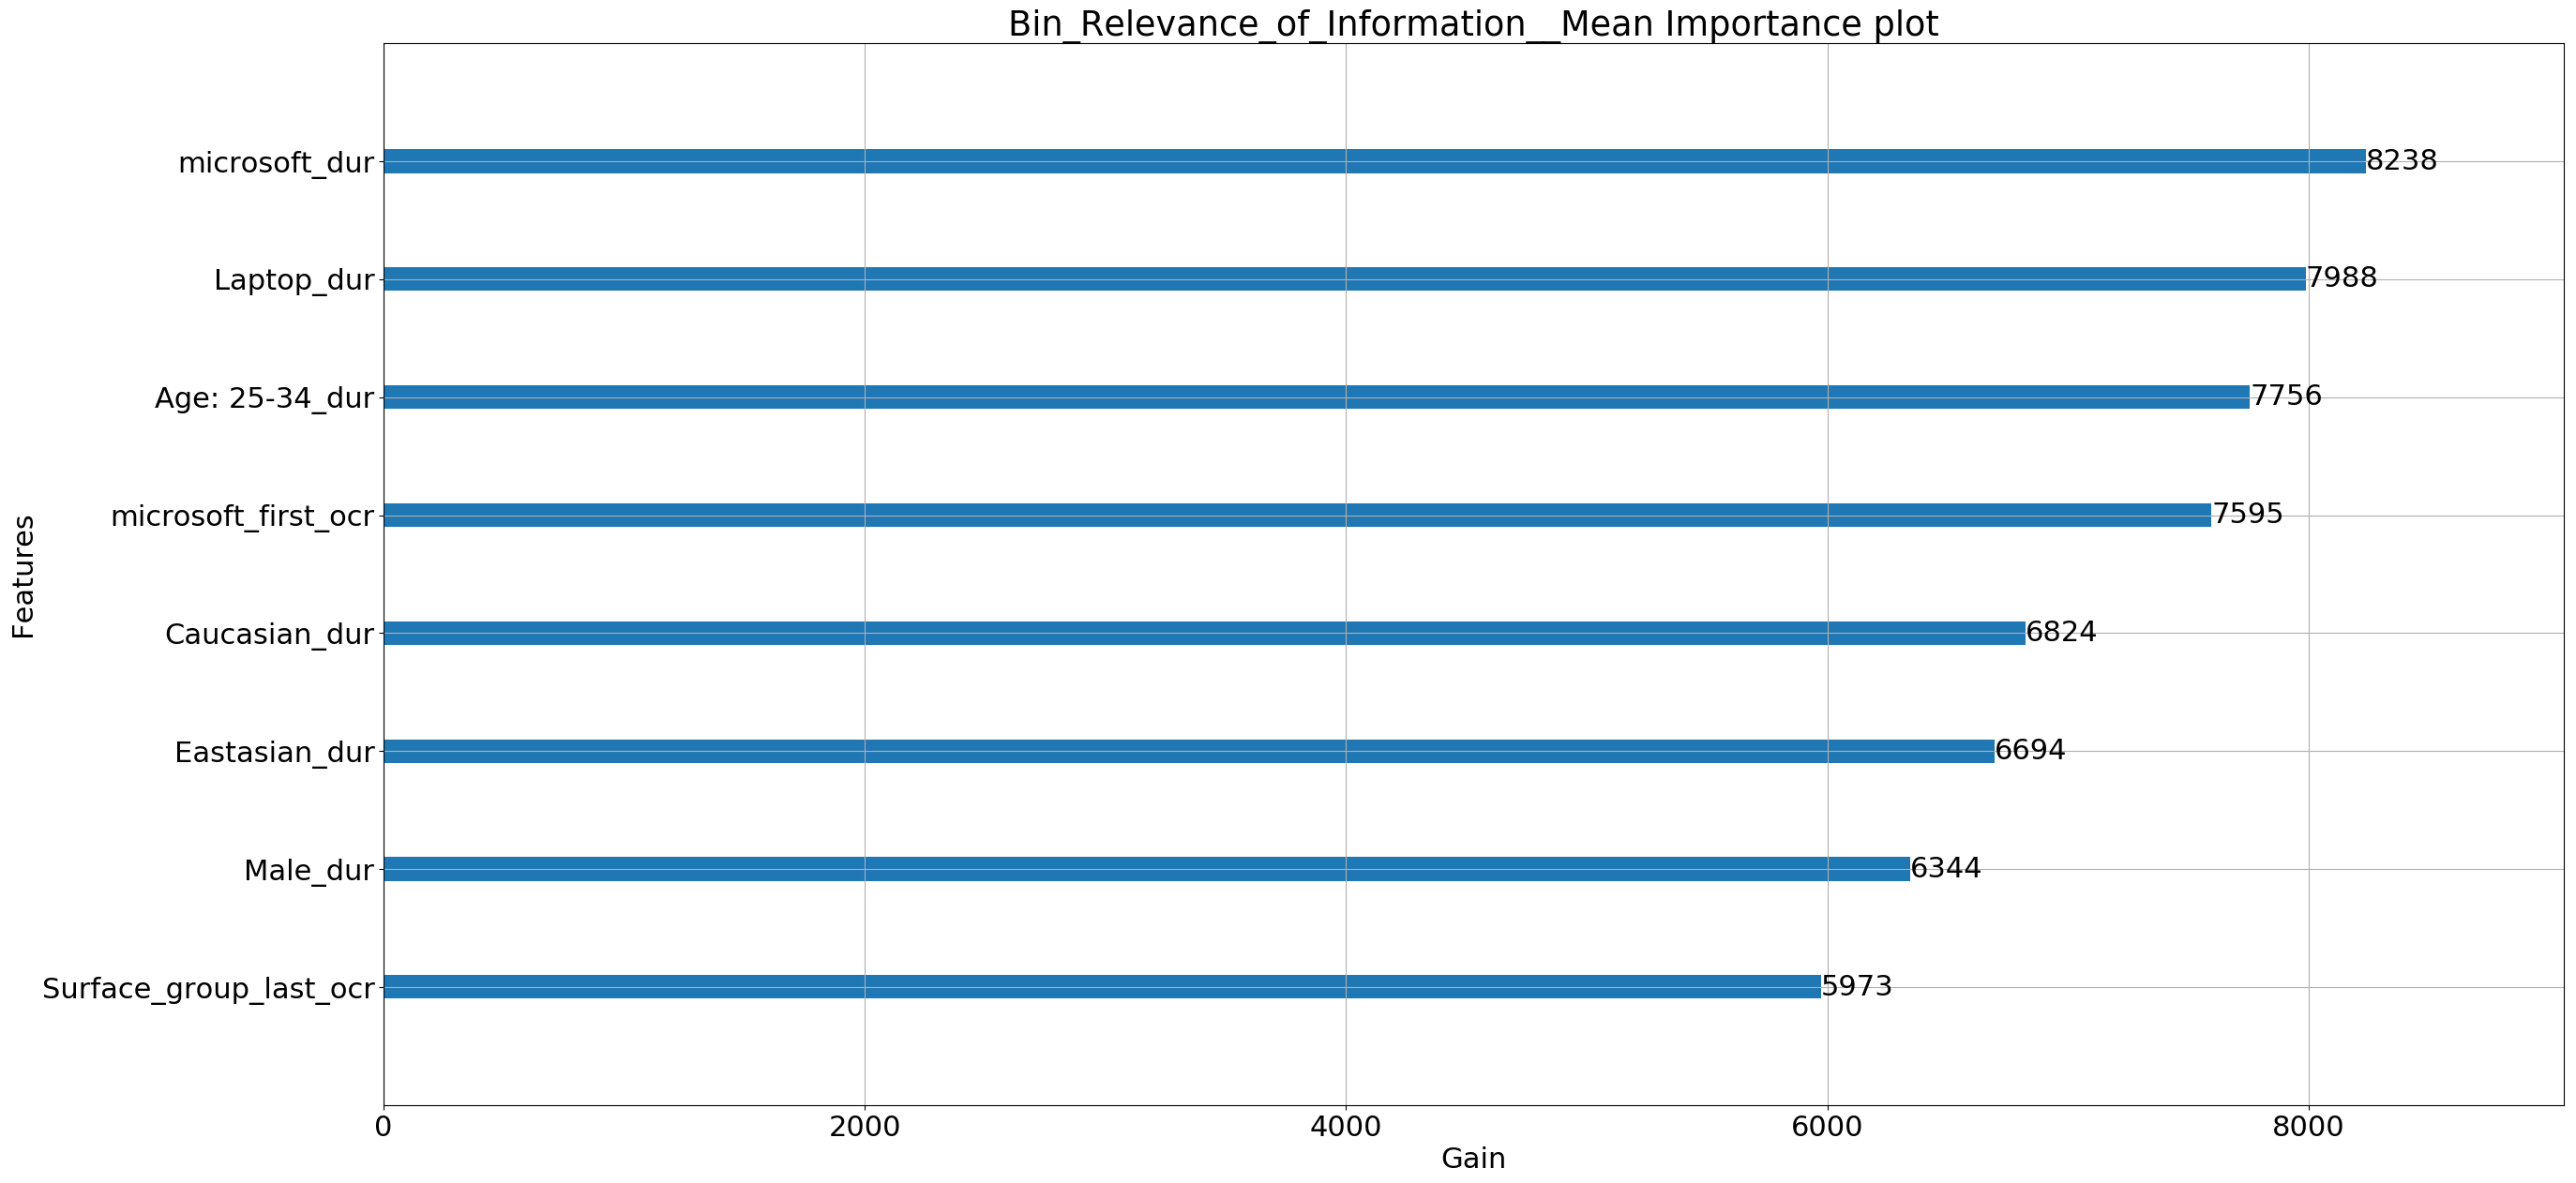

Bin_Credibility_of_Information__Mean
Macbook_group_dur
African_dur
Tablet_total_ocr
Laptop_first_ocr
microsoft_last_ocr
Male_dur
Laptop_last_ocr
length_of_ad_15
Surface_group_last_ocr
Tablet_first_ocr
Tablet_last_ocr
Laptop_total_ocr
Tablet_dur
Caucasian_dur
Eastasian_dur
microsoft_total_ocr


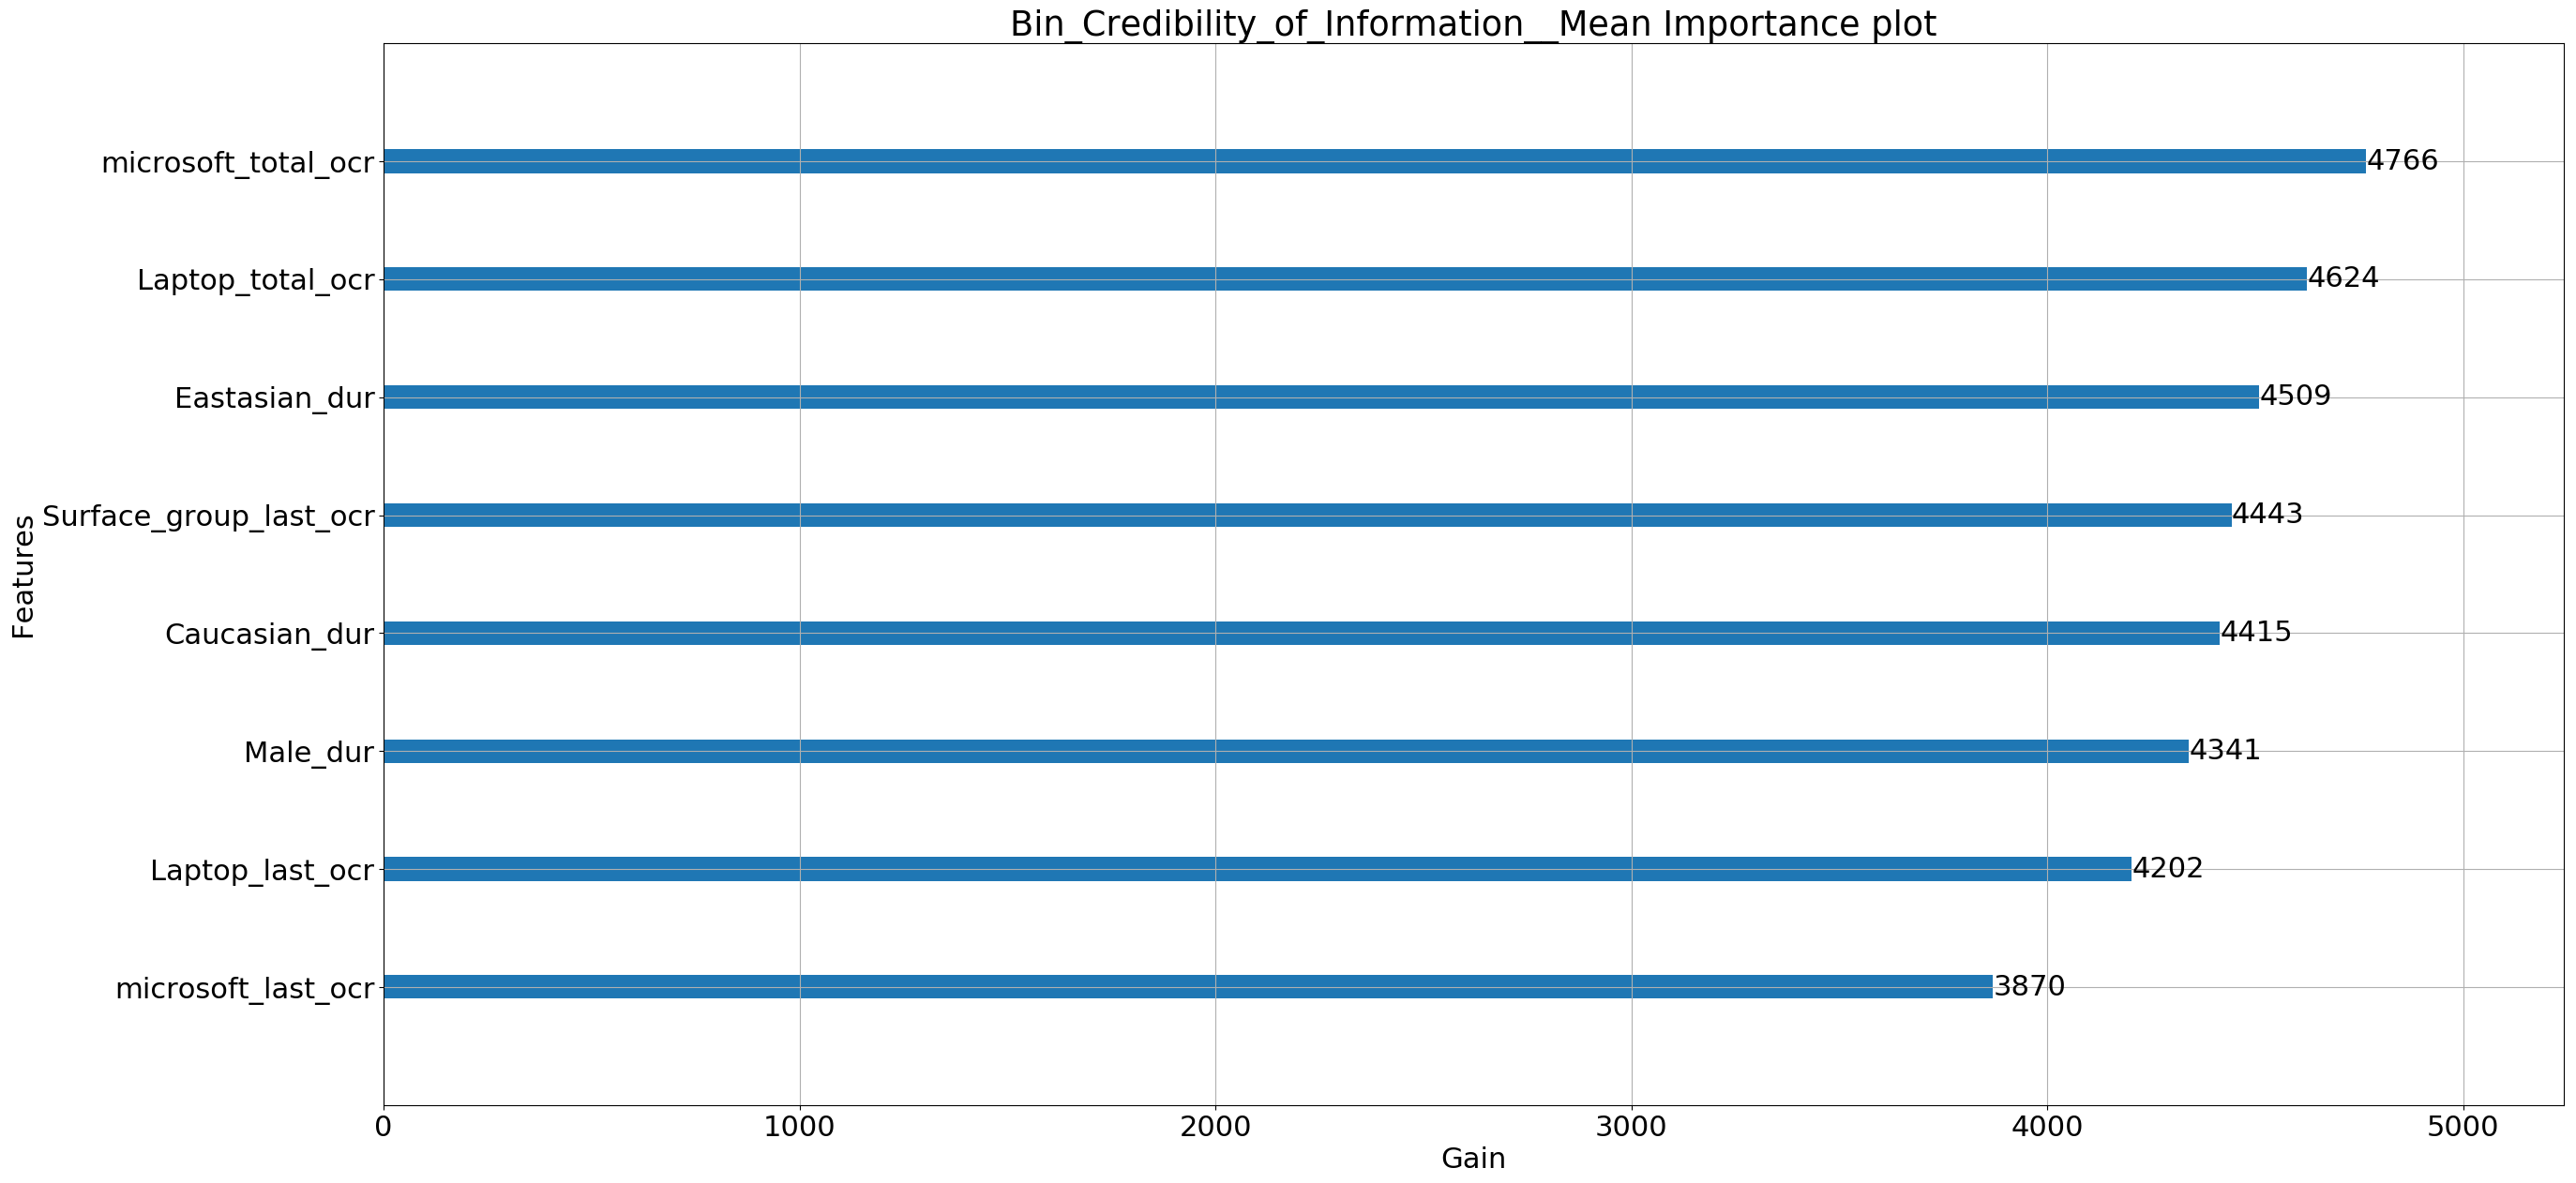

Bin_Brand_Difference__Mean
length_of_ad_15
African_dur
Surface_group_last_ocr
Macbook_group_dur
microsoft_last_ocr
Surface_group_first_ocr
microsoft_first_ocr
Laptop_last_ocr
Surface_group_dur
Neutral_dur
Age: 25-34_dur
Tablet_first_ocr


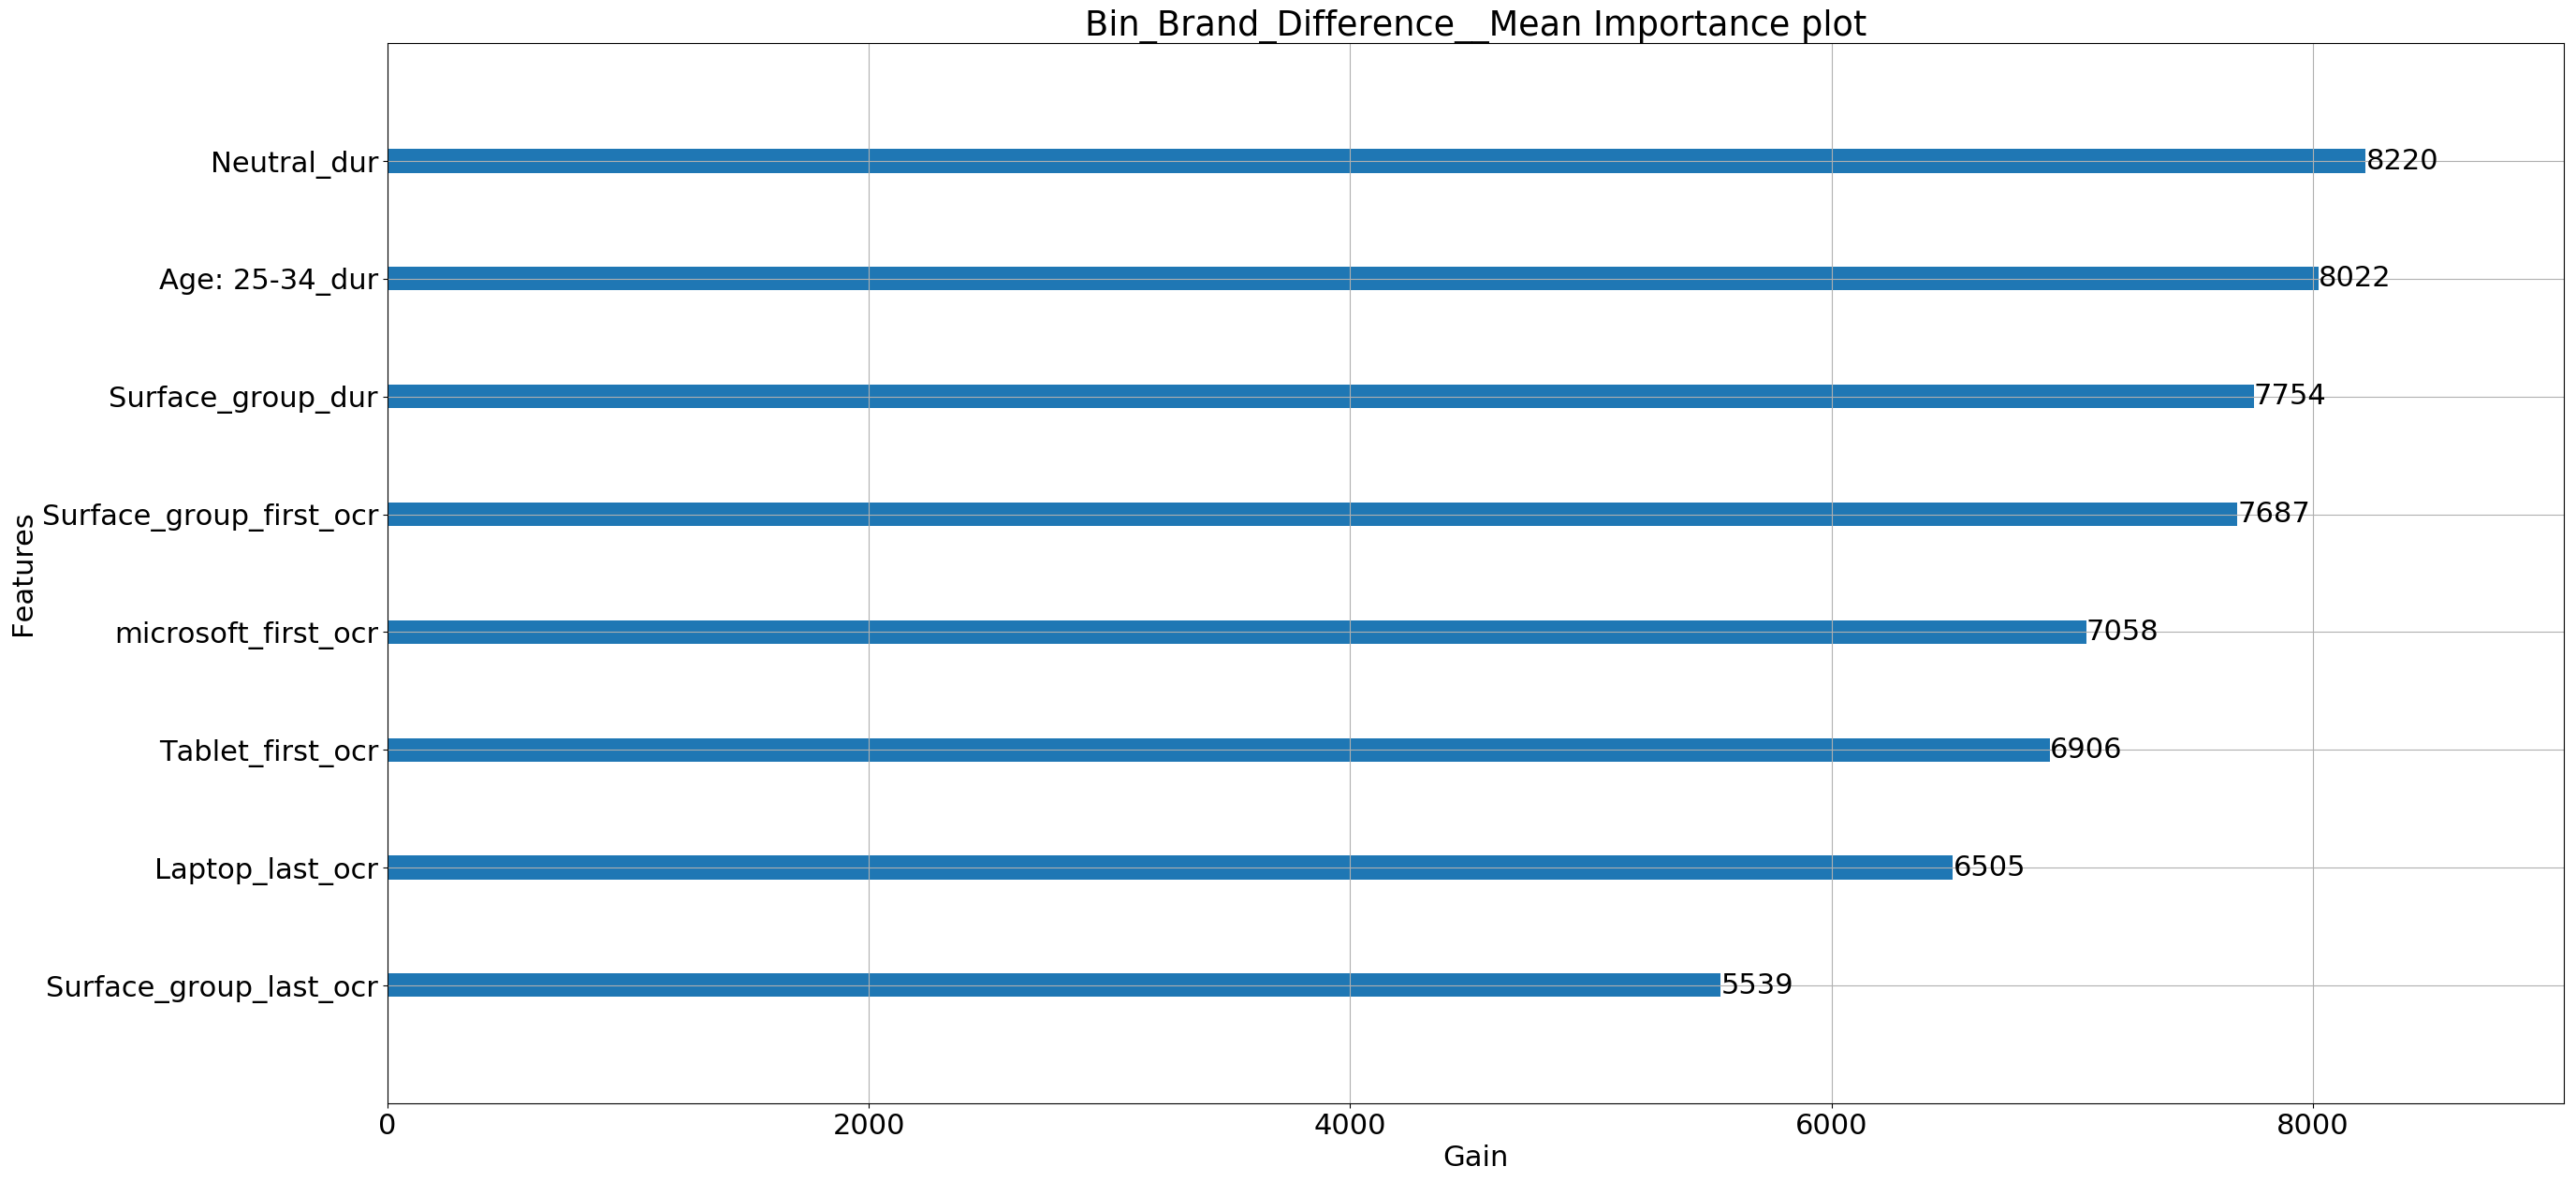

array([array(['length_of_ad_15', 'microsoft_first_ocr', 'microsoft_last_ocr',
       'Surface_group_total_ocr', 'Laptop_first_ocr', 'Surface_group_dur',
       'Laptop_last_ocr', 'Caucasian_dur', 'microsoft_dur',
       'Surface_group_last_ocr', 'Sadness_dur', 'Female_dur'],
      dtype=object),
       array(['African_dur', 'Macbook_group_dur', 'microsoft_last_ocr',
       'microsoft_first_ocr', 'Laptop_last_ocr', 'Laptop_total_ocr',
       'Surface_group_last_ocr', 'Surface_group_first_ocr', 'Neutral_dur',
       'Eastasian_dur', 'Laptop_first_ocr', 'Caucasian_dur', 'Laptop_dur'],
      dtype=object),
       array(['Tablet_last_ocr', 'length_of_ad_15', 'Macbook_group_dur',
       'African_dur', 'Surface_group_last_ocr', 'microsoft_last_ocr',
       'Laptop_last_ocr', 'Tablet_first_ocr', 'Tablet_total_ocr',
       'Laptop_dur', 'Tablet_dur', 'Surface_group_first_ocr',
       'Laptop_total_ocr', 'microsoft_first_ocr'], dtype=object),
       array(['Surface_group_last_ocr', 'length_of_ad

In [63]:
model_xgb_set.plot_feature_importance(m_xgb_set,10,Y.columns,x_train_set,savefig=False)

In [79]:
model_xgb_set.evaluate(x_train_set,y_train_set,m_xgb_set,metrics='accuracy')

Bin_Unaided_Branding
[1. 1. 1.] 

Bin_Brand_Cues__Mean
[1. 1. 1.] 

Bin_Aided_Branding__Mean
[1. 1. 1.] 

Bin_Active_Involvement__Mean
[1. 1. 1.] 

Bin_New_Information__Mean
[1. 1. 1.] 

Bin_Enjoyment__Mean
[1. 1. 1.] 

Bin_Brand_Appeal__Mean
[1. 1. 1.] 

Bin_Understanding__Mean
[1. 1. 1.] 

Bin_Relevance_of_Information__Mean
[1. 1. 1.] 

Bin_Credibility_of_Information__Mean
[1. 1. 1.] 

Bin_Brand_Difference__Mean
[1. 1. 1.] 



In [68]:
model_dt_set = Model('DT','class')
print("------------------------ 11 Models DT Training ----------------------------\n")
models_dt_11_set=[]
for i,target in enumerate(Y.columns.values):
    print("Training for ",target," start\n")
    models_dt_11_set.append(model_dt_set.train(x_train_set[i],y_train_set[i],x_test_set[i],y_test_set[i],metrics='accuracy',plot_error=False))
    model_dt_set.plot_tree(savefig=True,folder='../../Version_1_class/Decision_tree_surface/')    

------------------------ 11 Models DT Training ----------------------------

Training for  Bin_Unaided_Branding  start

Bin_Unaided_Branding
For training set
accuracy_score: 0.885748
For test set
accuracy_score: 0.888889




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Cues__Mean  start

Bin_Brand_Cues__Mean
For training set
accuracy_score: 0.834486
For test set
accuracy_score: 0.891667




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Aided_Branding__Mean  start

Bin_Aided_Branding__Mean
For training set
accuracy_score: 0.827321
For test set
accuracy_score: 0.786111




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Active_Involvement__Mean  start

Bin_Active_Involvement__Mean
For training set
accuracy_score: 0.910641
For test set
accuracy_score: 0.908333




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_New_Information__Mean  start

Bin_New_Information__Mean
For training set
accuracy_score: 0.864213
For test set
accuracy_score: 0.844444




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Enjoyment__Mean  start

Bin_Enjoyment__Mean
For training set
accuracy_score: 0.847530
For test set
accuracy_score: 0.863889




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Appeal__Mean  start

Bin_Brand_Appeal__Mean
For training set
accuracy_score: 0.913175
For test set
accuracy_score: 0.911111


Training for  Bin_Understanding__Mean  start

Bin_Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


For training set
accuracy_score: 0.919108
For test set
accuracy_score: 0.966667


Training for  Bin_Relevance_of_Information__Mean  start

Bin_Relevance_of_Information__Mean
For training set
accuracy_score: 0.886873
For test set
accuracy_score: 0.877778




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Credibility_of_Information__Mean  start

Bin_Credibility_of_Information__Mean
For training set
accuracy_score: 0.860618
For test set
accuracy_score: 0.933333




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Training for  Bin_Brand_Difference__Mean  start

Bin_Brand_Difference__Mean
For training set
accuracy_score: 0.848737
For test set
accuracy_score: 0.880556




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [65]:
m_dt_set = [m[0] for m in models_dt_11_set]
model_dt_set.evaluate(x_test_set,y_test_set,m_dt_set,metrics='accuracy')

Bin_Unaided_Branding
[0.94 0.81 0.91] 

Bin_Brand_Cues__Mean
[0.93 0.8  0.94] 

Bin_Aided_Branding__Mean
[0.86 0.66 0.83] 

Bin_Active_Involvement__Mean
[0.94 0.87 0.91] 

Bin_New_Information__Mean
[0.98 0.77 0.76] 

Bin_Enjoyment__Mean
[0.99 0.81 0.78] 

Bin_Brand_Appeal__Mean
[0.95 0.9  0.88] 

Bin_Understanding__Mean
[0.99 0.98 0.92] 

Bin_Relevance_of_Information__Mean
[0.86 0.87 0.9 ] 

Bin_Credibility_of_Information__Mean
[0.95 0.94 0.91] 

Bin_Brand_Difference__Mean
[0.93 0.84 0.86] 



In [66]:
model_dt_set.evaluate(x_train_set,y_train_set,m_dt_set,metrics='accuracy')

Bin_Unaided_Branding
[0.93 0.92 0.97] 

Bin_Brand_Cues__Mean
[0.94 0.83 0.96] 

Bin_Aided_Branding__Mean
[0.87 0.85 0.9 ] 

Bin_Active_Involvement__Mean
[0.98 0.93 0.96] 

Bin_New_Information__Mean
[0.99 0.82 0.84] 

Bin_Enjoyment__Mean
[0.99 0.84 0.82] 

Bin_Brand_Appeal__Mean
[0.96 0.93 0.93] 

Bin_Understanding__Mean
[0.99 0.96 0.9 ] 

Bin_Relevance_of_Information__Mean
[0.89 0.96 0.93] 

Bin_Credibility_of_Information__Mean
[0.92 0.93 0.9 ] 

Bin_Brand_Difference__Mean
[0.97 0.87 0.92] 

